In [6]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']


BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stdfont = 14
stdyfrac = 0.06

M2_FRmod_baseline_median = 2.3
AC_FRmod_baseline_median = 3.5

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



In [8]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

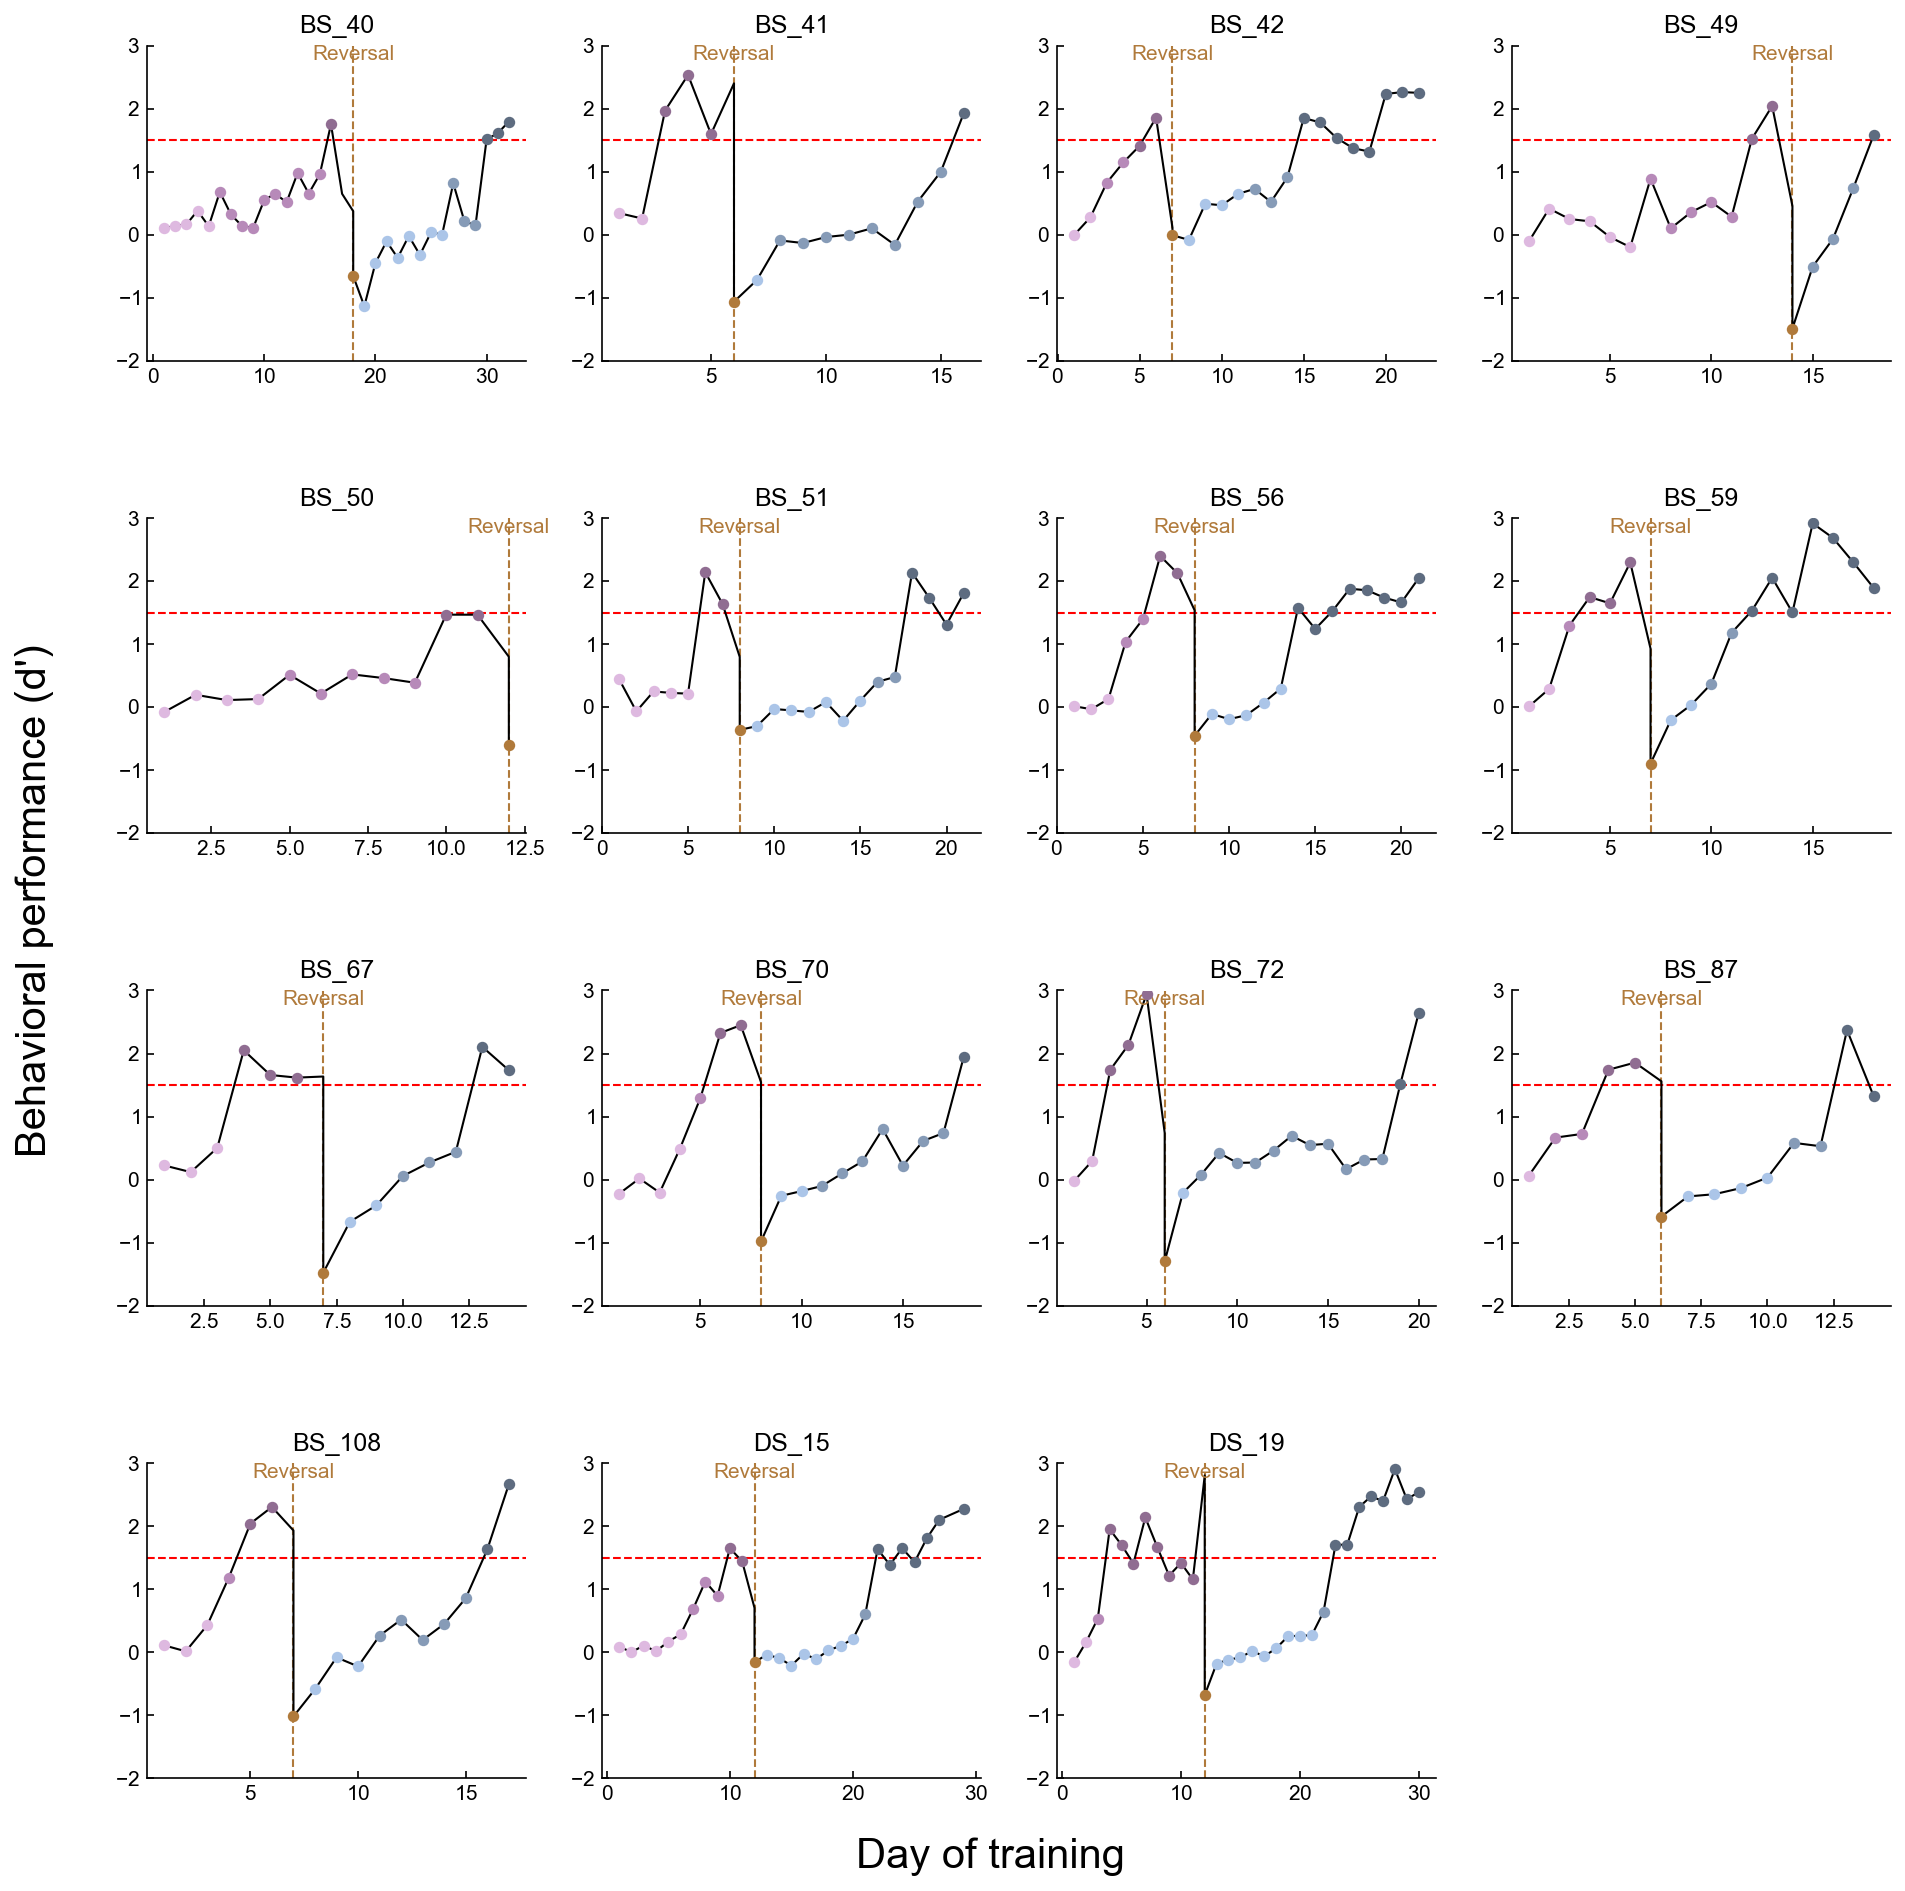

In [9]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [10]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 554/554 [00:09<00:00, 59.01it/s]

AC       : 1831
M2       : 1624


In [11]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1624/1624 [00:31<00:00, 51.56it/s] 

errors for: []


In [12]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1831/1831 [00:35<00:00, 52.09it/s] 

errors for: []


In [13]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

1624it [00:31, 51.58it/s] 


In [14]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

1831it [00:35, 52.25it/s] 


In [15]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87' 'DS_15' 'DS_19']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87' 'DS_15'
 'DS_19']


In [16]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

AC_sessions = list(AC_sessions)
M2_sessions = list(M2_sessions)

In [17]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 131/131 [00:01<00:00, 85.06it/s]

errors for: []


In [18]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))


100%|██████████| 102/102 [00:01<00:00, 82.62it/s]

errors for: []


In [106]:
sessionfile.trials.response

array([   64851.,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,  2268678.,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,  3397543.,
             nan,       nan,       nan,  3872347.,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
        5403582.,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,  7016685.,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

In [107]:
visualizeClusterInternal(10,'BS_49_1_AC.pickle','Preearly')

meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 6.919602529358627,
 18)

### check latency above 300ms, below 20ms

In [68]:
def visualizeClusterInternal(sessionfile,clust,sessionname, Phase):
    bw_scott_factor = 3

    
    ##################
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions['all_trials'].trials

    tone_times = sessionfile.trials.starts
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
        endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - tone_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    
    #Plot PSTH
    starttime = -250-100 #-350
    endtime = 1500+100 #1600
    PSTHstart = starttime - 100
    PSTHend = endtime + 100
    xrange = np.linspace(starttime,endtime,num=1950)
    #numSplits=10
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ######
    
    baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
    
    diff_from_baseline = np.abs(avg_FR[350:850] - baseline_FR) #0-500ms
    
    peak = np.max(diff_from_baseline) 
    peak_time = np.argmax(diff_from_baseline) #ms
    
    return peak_time

In [69]:
M2_peaklatency_preearly = []
M2_peaklatency_prelate = []
M2_peaklatency_preexpert = []
M2_peaklatency_postearly = []
M2_peaklatency_postlate = []
M2_peaklatency_postexpert = []

In [70]:
for session in tqdm(M2_preearly):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Preearly')
            M2_peaklatency_preearly.append(peak_time)
            #if peak_time >=300:
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

 14%|█▍        | 1/7 [00:17<01:45, 17.66s/it]

BS_49_2_M2.pickle29= 33FRmod= 5.756862745098036
BS_49_2_M2.pickle50= 29FRmod= 8.423529411764713


 43%|████▎     | 3/7 [00:26<00:28,  7.23s/it]

BS_49_5_M2.pickle45= 49FRmod= 7.28888888888889


 57%|█████▋    | 4/7 [00:29<00:16,  5.56s/it]

BS_50_1_M2.pickle19= 46FRmod= 10.658307210031346
BS_50_1_M2.pickle83= 20FRmod= 8.25496342737722


100%|██████████| 7/7 [01:16<00:00, 10.99s/it]


In [71]:
for session in tqdm(M2_prelate):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Prelate')
            M2_peaklatency_prelate.append(peak_time)
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

100%|██████████| 13/13 [02:39<00:00, 12.28s/it]


In [72]:
for session in tqdm(M2_preexpert):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Preexpert')
            M2_peaklatency_preexpert.append(peak_time)
            #if peak_time >=300:
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  0%|          | 0/10 [00:00<?, ?it/s]

BS_108_1_M2.pickle128= 17FRmod= 2.473118279569892


 10%|█         | 1/10 [00:03<00:28,  3.12s/it]

BS_108_1_M2.pickle190= 36FRmod= 3.978494623655913
BS_108_2_M2.pickle18= 38FRmod= 6.091954022988506


 60%|██████    | 6/10 [00:24<00:18,  4.66s/it]

BS_70_3_M2.pickle64= 50FRmod= 3.596491228070177


 80%|████████  | 8/10 [00:30<00:07,  3.64s/it]

BS_87_1_M2.pickle109= 48FRmod= 5.614035087719299
BS_87_1_M2.pickle112= 32FRmod= 4.390243902439025


 90%|█████████ | 9/10 [00:37<00:04,  4.63s/it]

BS_87_1_M2.pickle113= 10FRmod= 2.9268292682926806


100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


In [73]:
for session in tqdm(M2_postearly):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postearly')
            M2_peaklatency_postearly.append(peak_time)
            #if peak_time >=300:
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

 69%|██████▉   | 11/16 [03:40<02:20, 28.04s/it]

BS_72_4_M2.pickle51= 26FRmod= 2.4489795918367374


100%|██████████| 16/16 [04:25<00:00, 16.62s/it]


In [74]:
for session in tqdm(M2_postlate):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postlate')
            M2_peaklatency_postlate.append(peak_time)
            #if peak_time >=300:
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

 33%|███▎      | 9/27 [02:00<02:46,  9.27s/it]

BS_49_14_M2.pickle19= 26FRmod= 5.637727759914256


100%|██████████| 27/27 [03:25<00:00,  7.60s/it]


In [75]:
for session in tqdm(M2_postexpert):
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_M2 = session_M2.clusters.good
    #for clust in tqdm(clust_M2):
    for clust in clust_M2:
        FRmod = session_M2.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=M2_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postexpert')
            M2_peaklatency_postexpert.append(peak_time)
            #if peak_time >=300:
            if peak_time <=50:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

100%|██████████| 15/15 [01:39<00:00,  6.62s/it]


In [107]:
# M2_peaklatency = SimpleNamespace(prereversal_early=M2_peaklatency_preearly,
#                       prereversal_late=M2_peaklatency_prelate,
#                       prereversal_expert=M2_peaklatency_preexpert,
#                       postreversal_early=M2_peaklatency_postearly,
#                       postreversal_late=M2_peaklatency_postlate,
#                       postreversal_expert=M2_peaklatency_postexpert
#                      )

# #Save to pickle
# filename = 'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\M2\\M2_peaklatency500.pickle'
# with open(filename, 'wb') as f:
#     pickle.dump(M2_peaklatency, f, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
M2_peaklatency_post_expert

array([206, 132, 290, 136, 269, 140, 116,  73, 373, 172, 102, 121, 161,
       159, 186,  93, 102, 267, 241, 168, 140, 168, 204, 153, 138, 119,
       110, 127, 106, 119, 125, 143, 162, 159, 208, 140, 157, 183, 132,
       204, 125, 124, 121, 155, 162, 133, 184, 165, 151, 125, 128, 134,
       173, 150, 159, 199, 156, 136, 190, 130, 135, 149, 137, 177, 205,
       197, 212, 133, 116, 163, 151, 204, 160, 145, 145, 137, 170, 159,
       170, 135, 101, 292, 109, 115,  87, 119, 150, 143, 121,  74, 120,
       142,  71, 162, 165, 363, 246, 195, 132,  89, 193, 123, 212, 125,
       179, 219, 108, 363,  56,  76, 124, 110, 168,  77,  99, 101, 277,
       195, 484, 164, 275, 154, 215, 417,  93, 120,  93], dtype=int64)

In [106]:
np.array(M2_peaklatency_postexpert)

array([172, 102, 121, 161, 159, 186,  93, 102, 267, 241, 168, 140, 168,
       204, 153, 138, 119, 110, 127, 106, 119, 125, 143, 162, 159, 208,
       140, 157, 183, 132, 204, 125, 124, 121, 155, 162, 133, 184, 165,
       151, 125, 128, 134, 173, 150, 159, 199, 156, 136, 190, 130, 135,
       149, 137, 177, 205, 197, 212, 133, 116, 163, 151, 204, 160, 145,
       145, 137, 170, 159, 170, 135, 101, 292, 109, 115,  87, 119, 150,
       143, 121,  74, 120, 142,  71, 162, 165, 363, 246, 195, 132,  89,
       193, 123, 212, 125, 179, 219, 108, 363,  56,  76, 124, 110, 168,
        77,  99, 101, 277, 195, 484, 164, 275, 154], dtype=int64)

In [30]:
def visualizeClusterInternal(clust,sessionname, Phase):
    bw_scott_factor = 3
    
    sessionfile = ilep.loadSessionCached(act_directory,sessionname)
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
 
    mn = M2_FRmod_baseline_median 
    spread = 2.5
    FRmod_color = NCR_CR_cmap( (FRmod-(mn-spread/2))/ (spread) )
    color_to_use = FRmod_color
    
    ##################
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions['all_trials'].trials

    tone_times = sessionfile.trials.starts
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
        endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - tone_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0)
    ax1.fill_betweenx(range(len(trialsToPlot)), 0, 100, alpha=0.3, color=FRmod_color, lw=0,) #shading stim
    
    #Plot PSTH
    starttime = -250-100 #-350
    endtime = 1500+100 #1600
    PSTHstart = starttime - 100
    PSTHend = endtime + 100
    xrange = np.linspace(starttime,endtime,num=1950)
    #numSplits=10
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)],size=12)
    ax2.set_ylabel('Firing rate (spikes/s)',size=12)
    ax2.plot([0,100],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone
    ax2.set_xlim([-250,1000])
    ax2.set_xticks([0,100,300,500,1000])
    ax2.set_xticklabels(['0','100','300','500','1000'],size=12)
    ax2.set_xlabel('Time (ms)',size=12)
    
    ######
    baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
    diff_from_baseline = np.abs(avg_FR[350:850] - baseline_FR) #0-500ms
    peak = np.max(diff_from_baseline) 
    peak_time = np.argmax(diff_from_baseline) #ms
    
    ######
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod>=M2_FRmod_baseline_median:
        ax2.axvline(x=peak_time,color='green')
    
    
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\cell check\\M2\\'+Phase+str(sessionname)+',clust'+str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    plt.close(fig)
    return fig,[ax1,ax2],FRmod,peak_time

In [31]:
visualizeClusterInternal(0,'BS_49_4_M2.pickle','Preearly')
visualizeClusterInternal(35,'BS_49_4_M2.pickle','Preearly')
visualizeClusterInternal(37,'BS_49_4_M2.pickle','Preearly')

visualizeClusterInternal(44,'BS_49_5_M2.pickle','Preearly')
visualizeClusterInternal(77,'BS_49_5_M2.pickle','Preearly')

visualizeClusterInternal(17,'BS_50_1_M2.pickle','Preearly')
visualizeClusterInternal(26,'BS_50_1_M2.pickle','Preearly')

visualizeClusterInternal(37,'BS_50_2_M2.pickle','Preearly')
visualizeClusterInternal(71,'BS_50_2_M2.pickle','Preearly')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.496124031007752,
 423)

In [32]:
visualizeClusterInternal(120,'BS_40_10_M2.pickle','Prelate')

visualizeClusterInternal(13,'BS_40_11_M2.pickle','Prelate')

visualizeClusterInternal(2,'BS_40_7_M2.pickle','Prelate')

visualizeClusterInternal(71,'BS_50_6_M2.pickle','Prelate')

visualizeClusterInternal(5,'BS_50_7_M2.pickle','Prelate')
visualizeClusterInternal(29,'BS_50_7_M2.pickle','Prelate')
visualizeClusterInternal(60,'BS_50_7_M2.pickle','Prelate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 2.337662337662339,
 317)

In [33]:
visualizeClusterInternal(45,'BS_108_1_M2.pickle','Preexpert')

visualizeClusterInternal(7,'BS_108_2_M2.pickle','Preexpert')
visualizeClusterInternal(166,'BS_108_2_M2.pickle','Preexpert')

visualizeClusterInternal(167,'BS_108_2_M2.pickle','Preexpert')

visualizeClusterInternal(1,'BS_70_2_M2.pickle','Preexpert')
visualizeClusterInternal(25,'BS_70_2_M2.pickle','Preexpert')
visualizeClusterInternal(36,'BS_70_2_M2.pickle','Preexpert')
visualizeClusterInternal(39,'BS_70_2_M2.pickle','Preexpert')
visualizeClusterInternal(59,'BS_70_2_M2.pickle','Preexpert')

visualizeClusterInternal(12,'BS_70_3_M2.pickle','Preexpert')
visualizeClusterInternal(27,'BS_70_3_M2.pickle','Preexpert')

visualizeClusterInternal(75,'BS_72_1_M2.pickle','Preexpert')

visualizeClusterInternal(0,'BS_87_1_M2.pickle','Preexpert')
visualizeClusterInternal(33,'BS_87_1_M2.pickle','Preexpert')
visualizeClusterInternal(59,'BS_87_1_M2.pickle','Preexpert')

visualizeClusterInternal(13,'BS_87_2_M2.pickle','Preexpert')
visualizeClusterInternal(23,'BS_87_2_M2.pickle','Preexpert')
visualizeClusterInternal(35,'BS_87_2_M2.pickle','Preexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.02035623409669,
 316)

In [34]:
visualizeClusterInternal(130,'BS_108_6_M2.pickle','Postearly')

visualizeClusterInternal(13,'BS_42_2_M2.pickle','Postearly')
visualizeClusterInternal(124,'BS_42_2_M2.pickle','Postearly')

visualizeClusterInternal(79,'BS_42_4_M2.pickle','Postearly')
visualizeClusterInternal(109,'BS_42_4_M2.pickle','Postearly')

visualizeClusterInternal(35,'BS_42_5_M2.pickle','Postearly')

visualizeClusterInternal(2,'BS_70_5_M2.pickle','Postearly')

visualizeClusterInternal(40,'BS_87_4_M2.pickle','Postearly')

visualizeClusterInternal(156,'BS_87_5_M2.pickle','Postearly')

visualizeClusterInternal(77,'BS_87_7_M2.pickle','Postearly')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 3.5809523809523776,
 499)

In [35]:
visualizeClusterInternal(22,'BS_41_7_M2.pickle','Postlate')

visualizeClusterInternal(8,'BS_42_6_M2.pickle','Postlate')

visualizeClusterInternal(6,'BS_70_12_M2.pickle','Postlate')
visualizeClusterInternal(46,'BS_70_12_M2.pickle','Postlate')

visualizeClusterInternal(24,'BS_72_13_M2.pickle','Postlate')

visualizeClusterInternal(5,'BS_72_6_M2.pickle','Postlate')
visualizeClusterInternal(26,'BS_72_6_M2.pickle','Postlate')
visualizeClusterInternal(35,'BS_72_6_M2.pickle','Postlate')
visualizeClusterInternal(45,'BS_72_6_M2.pickle','Postlate')

visualizeClusterInternal(17,'BS_72_7_M2.pickle','Postlate')
visualizeClusterInternal(21,'BS_72_7_M2.pickle','Postlate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 2.786885245901642,
 357)

In [36]:
visualizeClusterInternal(33,'BS_56_4_M2.pickle','Postexpert')
visualizeClusterInternal(10,'BS_59_3_M2.pickle','Postexpert')
visualizeClusterInternal(10,'BS_59_4_M2.pickle','Postexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 5.138121546961325,
 484)

In [ ]:
PreexpertBS_108_1_M2.pickle,clust45.pdf????

In [77]:
AC_peaklatency_preearly = []
AC_peaklatency_prelate = []
AC_peaklatency_preexpert = []
AC_peaklatency_postearly = []
AC_peaklatency_postlate = []
AC_peaklatency_postexpert = []

In [78]:
for session in tqdm(AC_preearly):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Preearly')
            AC_peaklatency_preearly.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  0%|          | 0/6 [00:00<?, ?it/s]

BS_49_1_AC.pickle10= 18FRmod= 6.919602529358627
BS_49_1_AC.pickle124= 4FRmod= 4.433497536945816


 17%|█▋        | 1/6 [00:24<02:03, 24.74s/it]

BS_49_2_AC.pickle12= 26FRmod= 17.731481481481474
BS_49_2_AC.pickle17= 18FRmod= 8.800000000000006
BS_49_2_AC.pickle26= 2FRmod= 8.586387434554972
BS_49_2_AC.pickle30= 14FRmod= 12.909803921568626
BS_49_2_AC.pickle31= 15FRmod= 11.921568627450982
BS_49_2_AC.pickle47= 23FRmod= 10.149019607843137
BS_49_2_AC.pickle105= 17FRmod= 3.8745098039215673
BS_49_2_AC.pickle110= 18FRmod= 8.594771241830069
BS_49_2_AC.pickle127= 8FRmod= 4.128902316213494


 33%|███▎      | 2/6 [00:47<01:33, 23.44s/it]

BS_49_2_AC.pickle128= 21FRmod= 15.647382920110184
BS_49_4_AC.pickle20= 18FRmod= 13.666666666666664
BS_49_4_AC.pickle45= 20FRmod= 17.599999999999994
BS_49_4_AC.pickle46= 7FRmod= 22.866666666666656
BS_49_4_AC.pickle53= 25FRmod= 34.66666666666667
BS_49_4_AC.pickle56= 24FRmod= 16.20000000000001


100%|██████████| 6/6 [01:15<00:00, 12.66s/it]


In [79]:
for session in tqdm(AC_prelate):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Prelate')
            AC_peaklatency_prelate.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  7%|▋         | 1/14 [00:08<01:47,  8.25s/it]

BS_40_10_AC.pickle23= 6FRmod= 5.944444444444457
BS_40_2_AC.pickle18= 18FRmod= 3.911564625850337
BS_40_2_AC.pickle61= 13FRmod= 14.625850340136058
BS_40_2_AC.pickle65= 26FRmod= 3.962585034013606
BS_40_2_AC.pickle96= 14FRmod= 27.6360544217687
BS_40_2_AC.pickle103= 20FRmod= 18.82653061224488
BS_40_2_AC.pickle115= 5FRmod= 10.26365348399247
BS_40_2_AC.pickle154= 25FRmod= 6.51360544217687
BS_40_2_AC.pickle189= 22FRmod= 9.727891156462585
BS_40_2_AC.pickle206= 11FRmod= 8.588435374149663
BS_40_2_AC.pickle212= 30FRmod= 8.418367346938783
BS_40_2_AC.pickle225= 12FRmod= 28.21428571428572


 14%|█▍        | 2/14 [00:42<04:43, 23.62s/it]

BS_40_3_AC.pickle14= 17FRmod= 11.430745814307462
BS_40_3_AC.pickle23= 21FRmod= 18.396624472573816
BS_40_3_AC.pickle57= 10FRmod= 13.850837138508362
BS_40_3_AC.pickle111= 3FRmod= 12.860360360360373
BS_40_3_AC.pickle114= 17FRmod= 15.34936998854525
BS_40_3_AC.pickle115= 25FRmod= 4.279835390946501
BS_40_3_AC.pickle121= 28FRmod= 12.571428571428571


 21%|██▏       | 3/14 [00:52<03:11, 17.41s/it]

BS_40_3_AC.pickle155= 16FRmod= 16.910197869101975
BS_40_4_AC.pickle15= 23FRmod= 11.140939597315437
BS_40_4_AC.pickle18= 26FRmod= 18.91472868217054


 29%|██▊       | 4/14 [00:59<02:12, 13.24s/it]

BS_40_4_AC.pickle29= 19FRmod= 7.160000000000004


 36%|███▌      | 5/14 [01:01<01:21,  9.02s/it]

BS_40_5_AC.pickle27= 27FRmod= 15.003599712023021
BS_40_6_AC.pickle15= 22FRmod= 15.859766277128557


 86%|████████▌ | 12/14 [01:21<00:08,  4.03s/it]

BS_70_1_AC.pickle15= 23FRmod= 8.901734104046245


100%|██████████| 14/14 [01:29<00:00,  6.41s/it]


In [80]:
for session in tqdm(AC_preexpert):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Preexpert')
            AC_peaklatency_preexpert.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  0%|          | 0/10 [00:00<?, ?it/s]

BS_108_1_AC.pickle8= 19FRmod= 21.7741935483871


 20%|██        | 2/10 [00:03<00:12,  1.59s/it]

BS_40_12_AC.pickle2= 0FRmod= 3.647798742138366
BS_40_12_AC.pickle52= 11FRmod= 7.169811320754717


 40%|████      | 4/10 [00:09<00:17,  2.88s/it]

BS_72_1_AC.pickle0= 9FRmod= 12.38546603475514
BS_72_1_AC.pickle30= 13FRmod= 12.922590837282781


 60%|██████    | 6/10 [00:20<00:17,  4.35s/it]

BS_72_2_AC.pickle52= 29FRmod= 4.9350649350649345
BS_87_1_AC.pickle14= 25FRmod= 13.550135501355012
BS_87_1_AC.pickle15= 24FRmod= 20.813008130081297


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]

DS_19_1_AC.pickle65= 27FRmod= 5.91016548463357


In [81]:
for session in tqdm(AC_postearly):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postearly')
            AC_peaklatency_postearly.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  9%|▉         | 3/33 [00:15<02:40,  5.35s/it]

BS_40_15_AC.pickle68= 11FRmod= 27.03488372093023
BS_40_16_AC.pickle21= 27FRmod= 27.48508098891727
BS_40_16_AC.pickle26= 29FRmod= 34.12087912087914


 12%|█▏        | 4/33 [00:24<03:10,  6.58s/it]

BS_41_2_AC.pickle52= 21FRmod= 27.225130890052355


 18%|█▊        | 6/33 [00:26<01:38,  3.63s/it]

BS_41_2_AC.pickle200= 27FRmod= 5.657492354740061
BS_42_2_AC.pickle8= 24FRmod= 26.400000000000002
BS_42_2_AC.pickle12= 21FRmod= 17.21333333333333
BS_42_2_AC.pickle14= 19FRmod= 50.14666666666665
BS_42_2_AC.pickle61= 15FRmod= 8.893333333333334
BS_42_2_AC.pickle68= 28FRmod= 104.28000000000006
BS_42_2_AC.pickle69= 27FRmod= 41.93333333333338
BS_42_2_AC.pickle84= 17FRmod= 16.35756056808688
BS_42_2_AC.pickle86= 26FRmod= 22.45333333333335


 21%|██        | 7/33 [01:12<06:35, 15.21s/it]

BS_42_2_AC.pickle121= 7FRmod= 3.6266666666666616
BS_42_3_AC.pickle53= 25FRmod= 13.3
BS_42_3_AC.pickle61= 23FRmod= 12.15555555555555
BS_42_3_AC.pickle71= 19FRmod= 20.27777777777778
BS_42_3_AC.pickle73= 16FRmod= 8.211111111111105
BS_42_3_AC.pickle92= 24FRmod= 4.523809523809525


 24%|██▍       | 8/33 [01:39<07:43, 18.56s/it]

BS_42_3_AC.pickle107= 23FRmod= 50.97777777777771
BS_42_4_AC.pickle40= 21FRmod= 42.947845804988646
BS_42_4_AC.pickle45= 28FRmod= 18.17225509533202
BS_42_4_AC.pickle48= 29FRmod= 7.920110192837468


 33%|███▎      | 11/33 [02:25<05:25, 14.82s/it]

BS_72_4_AC.pickle9= 18FRmod= 7.363945578231298
BS_72_4_AC.pickle44= 19FRmod= 4.075117370892018
BS_72_4_AC.pickle70= 13FRmod= 18.323108384458077
BS_72_4_AC.pickle79= 16FRmod= 5.986394557823132
BS_72_4_AC.pickle101= 9FRmod= 5.346534653465347


 39%|███▉      | 13/33 [02:46<04:17, 12.85s/it]

BS_72_4_AC.pickle115= 11FRmod= 29.14965986394558
BS_87_4_AC.pickle99= 27FRmod= 22.452830188679236
BS_87_4_AC.pickle156= 30FRmod= 7.64150943396227
BS_87_4_AC.pickle172= 29FRmod= 7.169811320754737
BS_87_4_AC.pickle187= 19FRmod= 24.64285714285714


 52%|█████▏    | 17/33 [03:42<02:39,  9.98s/it]

BS_87_7_AC.pickle6= 30FRmod= 13.504273504273502
DS_15_3_AC.pickle28= 12FRmod= 4.044444444444438
DS_15_3_AC.pickle30= 11FRmod= 4.266666666666674
DS_15_3_AC.pickle43= 27FRmod= 32.651851851851866
DS_15_3_AC.pickle54= 22FRmod= 4.903703703703702
DS_15_3_AC.pickle56= 13FRmod= 4.177777777777774
DS_15_3_AC.pickle65= 26FRmod= 34.14814814814816


 58%|█████▊    | 19/33 [04:05<02:19,  9.98s/it]

DS_15_6_AC.pickle0= 25FRmod= 6.734693877551027


 70%|██████▉   | 23/33 [04:17<00:50,  5.03s/it]

DS_15_9_AC.pickle45= 24FRmod= 7.235926628716004
DS_15_9_AC.pickle134= 14FRmod= 12.692307692307688
DS_15_9_AC.pickle135= 10FRmod= 17.577519379844958
DS_15_9_AC.pickle148= 20FRmod= 5.871559633027517
DS_15_9_AC.pickle161= 24FRmod= 13.234323432343233


 73%|███████▎  | 24/33 [04:27<00:56,  6.26s/it]

DS_19_10_AC.pickle12= 18FRmod= 6.335877862595419


 76%|███████▌  | 25/33 [04:30<00:42,  5.37s/it]

DS_19_10_AC.pickle24= 24FRmod= 6.04244694132334


 79%|███████▉  | 26/33 [04:31<00:30,  4.35s/it]

DS_19_11_AC.pickle45= 28FRmod= 7.599309153713299
DS_19_3_AC.pickle56= 8FRmod= 8.935920047031129
DS_19_3_AC.pickle59= 6FRmod= 12.604350382128136
DS_19_3_AC.pickle64= 4FRmod= 4.56202233980013
DS_19_3_AC.pickle72= 1FRmod= 5.09112286890066
DS_19_3_AC.pickle108= 18FRmod= 4.155844155844159


 82%|████████▏ | 27/33 [04:40<00:33,  5.61s/it]

DS_19_4_AC.pickle32= 18FRmod= 8.839368616527391
DS_19_4_AC.pickle41= 23FRmod= 21.750245821042263
DS_19_4_AC.pickle76= 14FRmod= 9.947916666666668


 85%|████████▍ | 28/33 [04:56<00:42,  8.52s/it]

DS_19_4_AC.pickle99= 19FRmod= 16.94352159468439


 88%|████████▊ | 29/33 [04:59<00:27,  6.82s/it]

DS_19_6_AC.pickle2= 9FRmod= 12.981715893108289
DS_19_6_AC.pickle12= 22FRmod= 5.855181023720357
DS_19_6_AC.pickle54= 13FRmod= 9.739252995066952
DS_19_6_AC.pickle228= 1FRmod= 5.29338327091137
DS_19_6_AC.pickle234= 19FRmod= 4.868913857677901
DS_19_6_AC.pickle263= 15FRmod= 7.340823970037456


 91%|█████████ | 30/33 [05:56<01:03, 21.20s/it]

DS_19_7_AC.pickle13= 1FRmod= 10.866783013379852
DS_19_7_AC.pickle28= 2FRmod= 3.839441535776612
DS_19_7_AC.pickle37= 19FRmod= 32.891215823152976
DS_19_7_AC.pickle88= 19FRmod= 17.89412449098314


 94%|█████████▍| 31/33 [06:20<00:43, 21.95s/it]

DS_19_9_AC.pickle18= 23FRmod= 5.181818181818184


100%|██████████| 33/33 [06:21<00:00, 11.56s/it]

DS_19_9_AC.pickle57= 25FRmod= 7.266666666666667


In [82]:
for session in tqdm(AC_postlate):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postlate')
            AC_peaklatency_postlate.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

  3%|▎         | 1/29 [00:01<00:37,  1.35s/it]

BS_41_4_AC.pickle19= 15FRmod= 14.96183206106869
BS_41_4_AC.pickle110= 27FRmod= 3.9312977099236615
BS_41_4_AC.pickle115= 17FRmod= 6.22137404580154


  7%|▋         | 2/29 [00:38<09:59, 22.21s/it]

BS_41_4_AC.pickle117= 5FRmod= 9.707379134860044


 10%|█         | 3/29 [00:44<06:26, 14.85s/it]

BS_41_6_AC.pickle3= 23FRmod= 12.114093959731518


 14%|█▍        | 4/29 [00:49<04:35, 11.03s/it]

BS_41_6_AC.pickle7= 14FRmod= 7.483221476510067
BS_41_7_AC.pickle59= 11FRmod= 10.240295748613654


 17%|█▋        | 5/29 [01:03<04:46, 11.95s/it]

BS_41_7_AC.pickle64= 13FRmod= 3.9080459770115
BS_41_8_AC.pickle60= 22FRmod= 11.086142322097386
BS_41_8_AC.pickle77= 14FRmod= 7.253333333333332
BS_41_8_AC.pickle79= 25FRmod= 24.862155388471184


 21%|██        | 6/29 [01:21<05:24, 14.13s/it]

BS_41_8_AC.pickle89= 12FRmod= 9.160671462829736
BS_41_9_AC.pickle3= 24FRmod= 9.467162329615856
BS_41_9_AC.pickle80= 22FRmod= 25.0333333333333


 24%|██▍       | 7/29 [01:33<04:56, 13.50s/it]

BS_41_9_AC.pickle109= 13FRmod= 3.5777777777777753
BS_42_6_AC.pickle18= 28FRmod= 4.0


 31%|███       | 9/29 [02:08<05:06, 15.35s/it]

BS_67_1_AC.pickle14= 17FRmod= 4.7047619047619165
BS_67_1_AC.pickle16= 2FRmod= 4.957264957264958
BS_67_1_AC.pickle31= 15FRmod= 10.419047619047602


 52%|█████▏    | 15/29 [02:31<01:14,  5.35s/it]

BS_70_8_AC.pickle21= 23FRmod= 13.699788583509507


 59%|█████▊    | 17/29 [02:40<01:01,  5.14s/it]

BS_70_9_AC.pickle60= 25FRmod= 8.921282798833824


 62%|██████▏   | 18/29 [02:41<00:43,  3.99s/it]

BS_72_10_AC.pickle18= 18FRmod= 13.402061855670107


 69%|██████▉   | 20/29 [02:44<00:26,  2.95s/it]

BS_72_5_AC.pickle10= 13FRmod= 39.34666666666668
BS_72_5_AC.pickle36= 19FRmod= 20.210970464135016
BS_72_5_AC.pickle61= 19FRmod= 12.133333333333331


 72%|███████▏  | 21/29 [03:12<01:10,  8.81s/it]

BS_72_6_AC.pickle14= 11FRmod= 4.483430799220272
BS_72_6_AC.pickle23= 8FRmod= 11.053333333333326
BS_72_6_AC.pickle26= 14FRmod= 11.373333333333322
BS_72_6_AC.pickle27= 22FRmod= 7.605409705648372
BS_72_6_AC.pickle40= 14FRmod= 21.863799283154098


 76%|███████▌  | 22/29 [03:31<01:19, 11.42s/it]

BS_72_6_AC.pickle61= 6FRmod= 9.069373942470387
BS_72_7_AC.pickle13= 24FRmod= 21.69398907103826


 79%|███████▉  | 23/29 [03:46<01:13, 12.27s/it]

BS_72_8_AC.pickle5= 28FRmod= 11.756978653530378
BS_72_8_AC.pickle18= 24FRmod= 4.663382594417079


 83%|████████▎ | 24/29 [03:50<00:50, 10.05s/it]

BS_72_9_AC.pickle8= 3FRmod= 10.048309178743963


 86%|████████▌ | 25/29 [03:52<00:30,  7.65s/it]

BS_87_8_AC.pickle3= 21FRmod= 9.047619047619044


100%|██████████| 29/29 [04:13<00:00,  8.73s/it]


In [83]:
for session in tqdm(AC_postexpert):
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    clust_AC = session_AC.clusters.good
    #for clust in tqdm(clust_AC):
    for clust in clust_AC:
        FRmod = session_AC.responsiveness[clust]['all_trials'].FRmodulation
        
        if FRmod>=AC_FRmod_baseline_median:
            peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postexpert')
            AC_peaklatency_postexpert.append(peak_time)
            #if peak_time >=300:
            if peak_time <=30:
                print(str(sessionname)+str(clust)+'= '+str(peak_time)+'FRmod= '+str(FRmod))

 46%|████▋     | 13/28 [00:18<00:20,  1.38s/it]

BS_70_13_AC.pickle8= 26FRmod= 3.912483912483913


 61%|██████    | 17/28 [00:22<00:11,  1.07s/it]

DS_15_12_AC.pickle42= 27FRmod= 32.4770642201835


 68%|██████▊   | 19/28 [00:34<00:30,  3.37s/it]

DS_15_14_AC.pickle31= 7FRmod= 12.597701149425287
DS_15_14_AC.pickle41= 4FRmod= 10.666666666666663
DS_15_14_AC.pickle44= 20FRmod= 18.896551724137936
DS_15_14_AC.pickle54= 22FRmod= 4.689655172413795
DS_15_14_AC.pickle86= 24FRmod= 3.954022988505745
DS_15_14_AC.pickle100= 10FRmod= 22.94252873563219


 75%|███████▌  | 21/28 [00:45<00:28,  4.12s/it]

DS_15_16_AC.pickle23= 19FRmod= 20.330033003300322
DS_15_16_AC.pickle26= 24FRmod= 17.469746974697454
DS_15_16_AC.pickle33= 13FRmod= 11.770833333333329


 86%|████████▌ | 24/28 [00:58<00:14,  3.68s/it]

DS_19_16_AC.pickle72= 11FRmod= 13.922764227642281
DS_19_16_AC.pickle97= 9FRmod= 5.508130081300814
DS_19_16_AC.pickle132= 18FRmod= 8.450704225352112


100%|██████████| 28/28 [01:17<00:00,  2.77s/it]


In [132]:
# AC_peaklatency = SimpleNamespace(prereversal_early=AC_peaklatency_preearly,
#                       prereversal_late=AC_peaklatency_prelate,
#                       prereversal_expert=AC_peaklatency_preexpert,
#                       postreversal_early=AC_peaklatency_postearly,
#                       postreversal_late=AC_peaklatency_postlate,
#                       postreversal_expert=AC_peaklatency_postexpert
#                      )

# #Save to pickle
# filename = 'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\AC\\AC_peaklatency500.pickle'
# with open(filename, 'wb') as f:
#     pickle.dump(AC_peaklatency, f, protocol=pickle.HIGHEST_PROTOCOL)

### cell check plot PSTH (high)

In [97]:
def visualizeClusterInternal(clust,sessionname, Phase):
    bw_scott_factor = 3
    
    sessionfile = ilep.loadSessionCached(act_directory,sessionname)
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
 
    mn = AC_FRmod_baseline_median 
    spread = 2.5
    FRmod_color = NCR_CR_cmap( (FRmod-(mn-spread/2))/ (spread) )
    color_to_use = FRmod_color
    
    ##################
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions['all_trials'].trials

    tone_times = sessionfile.trials.starts
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
        endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - tone_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0)
    ax1.fill_betweenx(range(len(trialsToPlot)), 0, 100, alpha=0.3, color=FRmod_color, lw=0,) #shading stim
    
    #Plot PSTH
    starttime = -250-100 #-350
    endtime = 1500+100 #1600
    PSTHstart = starttime - 100
    PSTHend = endtime + 100
    xrange = np.linspace(starttime,endtime,num=1950)
    #numSplits=10
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)],size=12)
    ax2.set_ylabel('Firing rate (spikes/s)',size=12)
    ax2.plot([0,100],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone
    ax2.set_xlim([-250,1000])
    ax2.set_xticks([0,30,100,300,500,1000])
    ax2.set_xticklabels(['0','30','100','300','500','1000'],size=12)
    ax2.set_xlabel('Time (ms)',size=12)
    
    ######
    baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
    diff_from_baseline = np.abs(avg_FR[350:850] - baseline_FR) #0-500ms
    peak = np.max(diff_from_baseline) 
    peak_time = np.argmax(diff_from_baseline) #ms
    
    ######
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod>=AC_FRmod_baseline_median:
        ax2.axvline(x=peak_time,color='green')
    
    
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\cell check\\ACV2\\'+Phase+str(sessionname)+',clust'+str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    plt.close(fig)
    return fig,[ax1,ax2],FRmod,peak_time

In [61]:
visualizeClusterInternal(5,'BS_40_10_AC.pickle','Prelate')

visualizeClusterInternal(33,'BS_40_2_AC.pickle','Prelate')

visualizeClusterInternal(2,'BS_49_7_AC.pickle','Prelate')

visualizeClusterInternal(1,'BS_70_1_AC.pickle','Prelate')
visualizeClusterInternal(37,'BS_70_1_AC.pickle','Prelate')
visualizeClusterInternal(69,'BS_70_1_AC.pickle','Prelate')
visualizeClusterInternal(127,'BS_70_1_AC.pickle','Prelate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.93256262042389,
 499)

In [62]:
visualizeClusterInternal(39,'BS_49_12_AC.pickle','Preexpert')

visualizeClusterInternal(7,'BS_72_2_AC.pickle','Preexpert')

visualizeClusterInternal(3,'DS_15_1_AC.pickle','Preexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 7.025948103792412,
 318)

In [63]:
visualizeClusterInternal(40,'BS_40_15_AC.pickle','Postearly')

visualizeClusterInternal(14,'BS_40_16_AC.pickle','Postearly')

visualizeClusterInternal(3,'BS_42_2_AC.pickle','Postearly')
visualizeClusterInternal(62,'BS_42_2_AC.pickle','Postearly')
visualizeClusterInternal(118,'BS_42_2_AC.pickle','Postearly')

visualizeClusterInternal(80,'BS_42_3_AC.pickle','Postearly')

visualizeClusterInternal(166,'DS_15_9_AC.pickle','Postearly')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.18732782369146,
 491)

In [65]:
visualizeClusterInternal(32,'BS_70_11_AC.pickle','Postlate')

visualizeClusterInternal(12,'BS_72_13_AC.pickle','Postlate')
visualizeClusterInternal(22,'BS_72_5_AC.pickle','Postlate')

visualizeClusterInternal(36,'BS_72_8_AC.pickle','Postlate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.342105263157894,
 301)

In [67]:
visualizeClusterInternal(9,'BS_56_2_AC.pickle','Postexpert')

visualizeClusterInternal(35,'BS_56_3_AC.pickle','Postexpert')

visualizeClusterInternal(10,'BS_87_11_AC.pickle','Postexpert')

visualizeClusterInternal(20,'DS_15_14_AC.pickle','Postexpert')

visualizeClusterInternal(37,'DS_15_15_AC.pickle','Postexpert')
visualizeClusterInternal(40,'DS_15_15_AC.pickle','Postexpert')

visualizeClusterInternal(27,'DS_15_16_AC.pickle','Postexpert')

visualizeClusterInternal(10,'DS_19_18_AC.pickle','Postexpert')
visualizeClusterInternal(14,'DS_19_20_AC.pickle','Postexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 4.939550949913645,
 311)

### cell check plot PSTH (low)

In [98]:
visualizeClusterInternal(10,'BS_49_1_AC.pickle','Preearly')
visualizeClusterInternal(124,'BS_49_1_AC.pickle','Preearly')

visualizeClusterInternal(12,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(17,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(26,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(30,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(31,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(47,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(105,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(110,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(127,'BS_49_2_AC.pickle','Preearly')
visualizeClusterInternal(128,'BS_49_2_AC.pickle','Preearly')

visualizeClusterInternal(20,'BS_49_4_AC.pickle','Preearly')
visualizeClusterInternal(45,'BS_49_4_AC.pickle','Preearly')
visualizeClusterInternal(46,'BS_49_4_AC.pickle','Preearly')
visualizeClusterInternal(53,'BS_49_4_AC.pickle','Preearly')
visualizeClusterInternal(56,'BS_49_4_AC.pickle','Preearly')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 16.20000000000001,
 24)

In [99]:
visualizeClusterInternal(23,'BS_40_10_AC.pickle','Prelate')

visualizeClusterInternal(18,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(61,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(65,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(96,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(103,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(115,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(154,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(189,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(206,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(212,'BS_40_2_AC.pickle','Prelate')
visualizeClusterInternal(225,'BS_40_2_AC.pickle','Prelate')

visualizeClusterInternal(14,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(23,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(57,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(111,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(114,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(115,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(121,'BS_40_3_AC.pickle','Prelate')
visualizeClusterInternal(155,'BS_40_3_AC.pickle','Prelate')

visualizeClusterInternal(15,'BS_40_4_AC.pickle','Prelate')
visualizeClusterInternal(18,'BS_40_4_AC.pickle','Prelate')
visualizeClusterInternal(29,'BS_40_4_AC.pickle','Prelate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 7.160000000000004,
 19)

In [100]:
visualizeClusterInternal(8,'BS_108_1_AC.pickle','Preexpert')

visualizeClusterInternal(2,'BS_40_12_AC.pickle','Preexpert')
visualizeClusterInternal(52,'BS_40_12_AC.pickle','Preexpert')

visualizeClusterInternal(0,'BS_72_1_AC.pickle','Preexpert')
visualizeClusterInternal(30,'BS_72_1_AC.pickle','Preexpert')

visualizeClusterInternal(52,'BS_72_2_AC.pickle','Preexpert')

visualizeClusterInternal(14,'BS_87_1_AC.pickle','Preexpert')
visualizeClusterInternal(15,'BS_87_1_AC.pickle','Preexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 20.813008130081297,
 24)

In [101]:
visualizeClusterInternal(68,'BS_40_15_AC.pickle','Postearly')
visualizeClusterInternal(52,'BS_41_2_AC.pickle','Postearly')
visualizeClusterInternal(200,'BS_41_2_AC.pickle','Postearly')

visualizeClusterInternal(12,'BS_42_2_AC.pickle','Postearly')
visualizeClusterInternal(61,'BS_42_2_AC.pickle','Postearly')
visualizeClusterInternal(69,'BS_42_2_AC.pickle','Postearly')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 41.93333333333338,
 27)

In [102]:
visualizeClusterInternal(60,'BS_41_8_AC.pickle','Postlate')
visualizeClusterInternal(77,'BS_41_8_AC.pickle','Postlate')
visualizeClusterInternal(79,'BS_41_8_AC.pickle','Postlate')

visualizeClusterInternal(80,'BS_41_9_AC.pickle','Postlate')

visualizeClusterInternal(14,'BS_67_1_AC.pickle','Postlate')
visualizeClusterInternal(16,'BS_67_1_AC.pickle','Postlate')
visualizeClusterInternal(31,'BS_67_1_AC.pickle','Postlate')

visualizeClusterInternal(14,'BS_72_6_AC.pickle','Postlate')
visualizeClusterInternal(27,'BS_72_6_AC.pickle','Postlate')
visualizeClusterInternal(40,'BS_72_6_AC.pickle','Postlate')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 21.863799283154098,
 14)

In [103]:
visualizeClusterInternal(42,'DS_15_12_AC.pickle','Postexpert')

visualizeClusterInternal(41,'DS_15_14_AC.pickle','Postexpert')
visualizeClusterInternal(44,'DS_15_14_AC.pickle','Postexpert')
visualizeClusterInternal(54,'DS_15_14_AC.pickle','Postexpert')

visualizeClusterInternal(23,'DS_15_16_AC.pickle','Postexpert')
visualizeClusterInternal(33,'DS_15_16_AC.pickle','Postexpert')

visualizeClusterInternal(72,'DS_19_16_AC.pickle','Postexpert')
visualizeClusterInternal(97,'DS_19_16_AC.pickle','Postexpert')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>],
 5.508130081300814,
 9)

### M2

In [82]:
def visualizeClusterInternal(sessionfile,clust,sessionname, Phase):
    bw_scott_factor = 3
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
 
    mn = M2_FRmod_baseline_median 
    spread = 2.5
    FRmod_color = NCR_CR_cmap( (FRmod-(mn-spread/2))/ (spread) )
    color_to_use = FRmod_color
    
    ##################
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions['all_trials'].trials

    tone_times = sessionfile.trials.starts
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
        endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - tone_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0)
    ax1.fill_betweenx(range(len(trialsToPlot)), 0, 100, alpha=0.3, color=FRmod_color, lw=0,) #shading stim
    
    #Plot PSTH
    starttime = -250-100 #-350
    endtime = 1500+100 #1600
    PSTHstart = starttime - 100
    PSTHend = endtime + 100
    xrange = np.linspace(starttime,endtime,num=1950)
    #numSplits=10
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)],size=12)
    
    
    ax2.set_ylabel('Firing rate (spikes/s)',size=12)

    ax2.plot([0,100],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    
    ax2.set_xlim([-250,1500])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','500','1000','1500'],size=12)
    ax2.set_xlabel('Time (ms)',size=12)
    
    ######
    baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline

    diff_from_baseline = np.abs(avg_FR[350:650] - baseline_FR) #0-300ms, #0-200ms, #0-500ms
    
    peak = np.max(diff_from_baseline) 
    peak_time = np.argmax(diff_from_baseline) #ms
    
    #print(peak_time)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
    if FRmod>=M2_FRmod_baseline_median:
        ax2.axvline(x=peak_time,color='green')
    
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\M2\\'+Phase+str(sessionname)+',clust'+str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
    plt.close(fig)
    return fig,[ax1,ax2],FRmod,peak_time

In [83]:
for session in M2_preearly:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Preearly')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Preearly')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Preearly')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_preearly.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

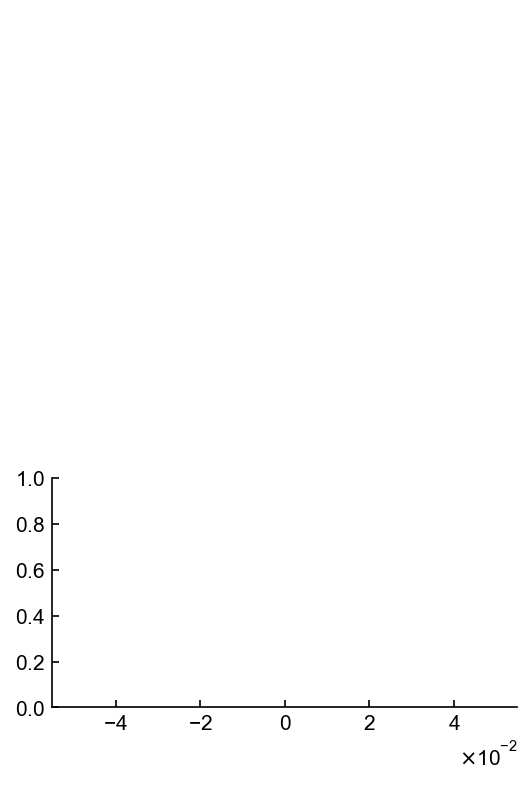

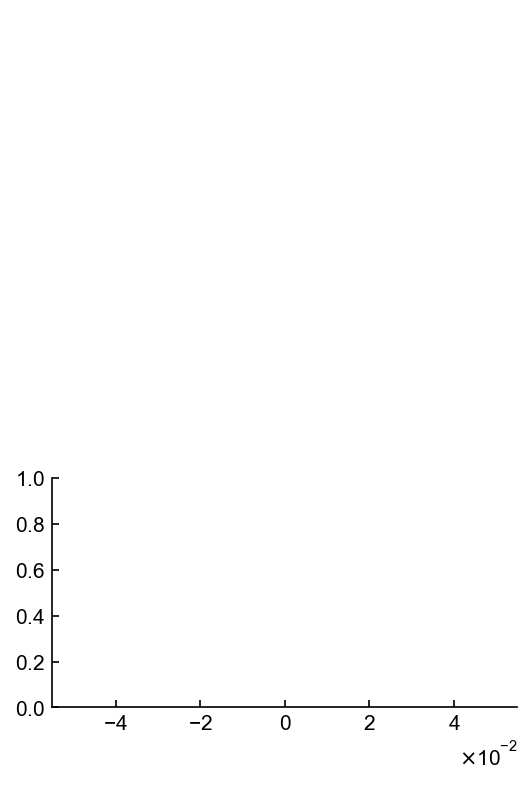

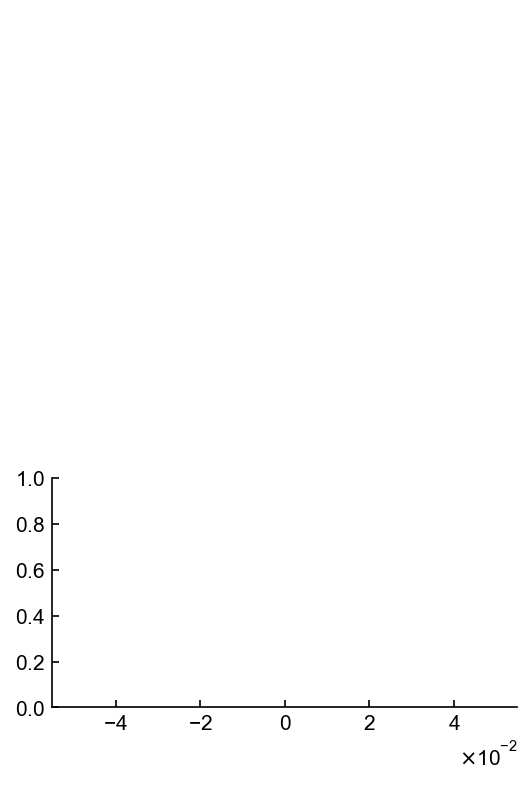

In [ ]:
for session in M2_prelate[:-1]:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Prelate')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Prelate')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Prelate')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_prelate.append(peak_time)

In [ ]:
for session in M2_preexpert:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Preexpert')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Preexpert')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Preexpert')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_preexpert.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

In [ ]:
for session in M2_postearly:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Postearly')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Postearly')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postearly')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_postearly.append(peak_time)

In [ ]:
for session in M2_postlate:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Postlate')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Postlate')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postlate')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_postlate.append(peak_time)

In [ ]:
for session in M2_postexpert:
    session_M2 = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_M2 = session_M2.clusters.good
    for clust in clust_M2:
        visualizeClusterInternal(session_M2,clust,sessionname,'Postexpert')
        FRmod = visualizeClusterInternal(session_M2,clust,sessionname,'Postexpert')[-2]
        peak_time = visualizeClusterInternal(session_M2,clust,sessionname,'Postexpert')[-1]
        if FRmod>=M2_FRmod_baseline_median:
            M2_peaklatency_postexpert.append(peak_time)

In [ ]:
M2_peaklatency = SimpleNamespace(prereversal_early=M2_peaklatency_preearly,
                      prereversal_late=M2_peaklatency_prelate,
                      prereversal_expert=M2_peaklatency_preexpert,
                      postreversal_early=M2_peaklatency_postearly,
                      postreversal_late=M2_peaklatency_postlate,
                      postreversal_expert=M2_peaklatency_postexpert
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\M2\\M2_peaklatency.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_peaklatency, f, protocol=pickle.HIGHEST_PROTOCOL)

### AC

In [15]:
AC_peaklatency_preearly = []
AC_peaklatency_prelate = []
AC_peaklatency_preexpert = []
AC_peaklatency_postearly = []
AC_peaklatency_postlate = []
AC_peaklatency_postexpert = []

In [312]:
# def visualizeClusterInternal(sessionfile,clust,sessionname, Phase):
#     bw_scott_factor = 3
    
#     fig = plt.figure(figsize=(4,6))
#     gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
#     ax1 = plt.subplot(gs[0,0])#Raster
#     ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)
    
#     FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
 
#     mn = AC_FRmod_baseline_median 
#     spread = 2.5
#     FRmod_color = NCR_CR_cmap( (FRmod-(mn-spread/2))/ (spread) )
#     color_to_use = FRmod_color
    
#     ##################
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     trialsToPlot = allConditions['all_trials'].trials

#     tone_times = sessionfile.trials.starts
#     clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
#     trialSpikes = []
    
#     for trial in trialsToPlot:

#         #Need to get spike times for each trail...
#         starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
#         endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

#         this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
#         this_trial_spikes = this_trial_spikes - tone_times[trial]
#         this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

#         trialSpikes.append(this_trial_spikes)
#     trialSpikes = np.array(trialSpikes,dtype='object')
    
#     #Plot Raster
#     for idx,trial in enumerate(trialsToPlot):
#         ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0)
#     ax1.fill_betweenx(range(len(trialsToPlot)), 0, 100, alpha=0.3, color=FRmod_color, lw=0,) #shading stim
    
#     #Plot PSTH
#     starttime = -250-100 #-350
#     endtime = 1500+100 #1600
#     PSTHstart = starttime - 100
#     PSTHend = endtime + 100
#     xrange = np.linspace(starttime,endtime,num=1950)
#     #numSplits=10
#     numSplits = min(10,len(trialSpikes))
#     if numSplits < 2:
#         return False,[] ### Return a failure
    
#     FR = np.full((numSplits,len(xrange)),np.nan)
#     kf = KFold(n_splits=numSplits)
#     for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
#         PSTHspikes = np.concatenate(trialSpikes[train_index])
#         if len(PSTHspikes) == 0:
#             FR[idx,:] = np.zeros(len(xrange))
#             continue
#         bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
#         KDE = gaussian_kde(PSTHspikes,bw_method=bw)
#         FR[idx,:] = KDE.evaluate(xrange)
#         FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
#     avg_FR = np.mean(FR,axis=0)
#     sem_FR = np.std(FR,axis=0)
    
#     ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
#     ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)
    
#     max_FR_value = np.max(avg_FR+sem_FR) * 1.1
#     sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
#     idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
#     valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
#     limit = np.min(valid_limits)
#     ax2.set_ylim([0,limit])
#     ax2.set_yticks([0,limit/2,limit])
#     ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)],size=12)
    
    
#     ax2.set_ylabel('Firing rate (spikes/s)',size=12)

#     ax2.plot([0,100],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    
#     ax2.set_xlim([-250,1500])
#     ax2.set_xticks([0,500,1000,1500])
#     ax2.set_xticklabels(['0','500','1000','1500'],size=12)
#     ax2.set_xlabel('Time (ms)',size=12)
    
#     ######
#     baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline

#     diff_from_baseline = np.abs(avg_FR[350:1350] - baseline_FR)
    
#     peak = np.max(diff_from_baseline) #len=1000
#     peak_time = np.argmax(diff_from_baseline) #ms
    
#     #print(peak_time)
    
#     FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
#     if FRmod>=AC_FRmod_baseline_median:
#         ax2.axvline(x=peak_time,color='green')
    
#     fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\PHRC_Dual\\Peak_latency\\Stimulus\\AC\\'+Phase+str(sessionname)+',clust'+str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
#     plt.close(fig)
#     return fig,[ax1,ax2],FRmod,peak_time

In [22]:
def visualizeClusterInternal(sessionfile,clust,sessionname, Phase):
    bw_scott_factor = 3
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
 
    mn = AC_FRmod_baseline_median 
    spread = 2.5
    FRmod_color = NCR_CR_cmap( (FRmod-(mn-spread/2))/ (spread) )
    color_to_use = FRmod_color
    
    ##################
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions['all_trials'].trials

    tone_times = sessionfile.trials.starts
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        starttime = tone_times[trial]-0.35*sessionfile.meta.fs #0.25
        endtime = tone_times[trial]+1.6*sessionfile.meta.fs #1.5

        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - tone_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0)
    ax1.fill_betweenx(range(len(trialsToPlot)), 0, 100, alpha=0.3, color=FRmod_color, lw=0,) #shading stim
    
    #Plot PSTH
    starttime = -250-100 #-350
    endtime = 1500+100 #1600
    PSTHstart = starttime - 100
    PSTHend = endtime + 100
    xrange = np.linspace(starttime,endtime,num=1950)
    #numSplits=10
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)],size=12)
    
    
    ax2.set_ylabel('Firing rate (spikes/s)',size=12)

    ax2.plot([0,100],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    
    ax2.set_xlim([-250,1500])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','500','1000','1500'],size=12)
    ax2.set_xlabel('Time (ms)',size=12)
    
    ######
    baseline_FR = sessionfile.responsiveness[clust]['all_trials'].FRbaseline

    diff_from_baseline = np.abs(avg_FR[350:550] - baseline_FR) #200ms window check for AC
    #print(len(diff_from_baseline))#len=200
    peak = np.max(diff_from_baseline) 

    peak_time = np.argmax(diff_from_baseline) #ms
    
    #print(peak_time)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
    if FRmod>=AC_FRmod_baseline_median:
        ax2.axvline(x=peak_time,color='green')
    
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\AC\\'+Phase+str(sessionname)+',clust'+str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
    plt.close(fig)
    return fig,[ax1,ax2],FRmod,peak_time

In [23]:
for session in AC_preearly:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Preearly')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Preearly')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Preearly')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_preearly.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

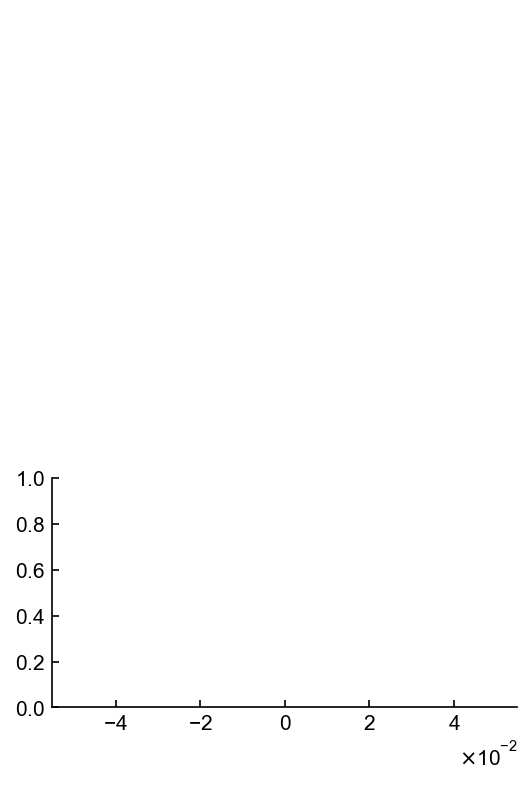

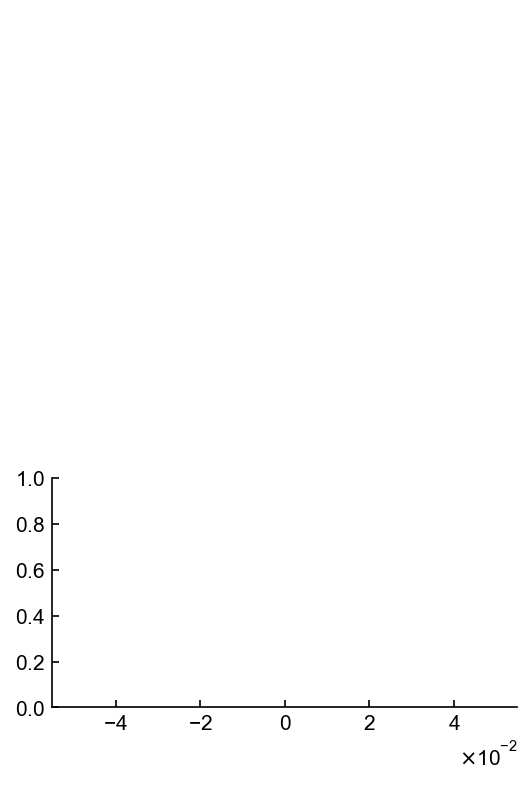

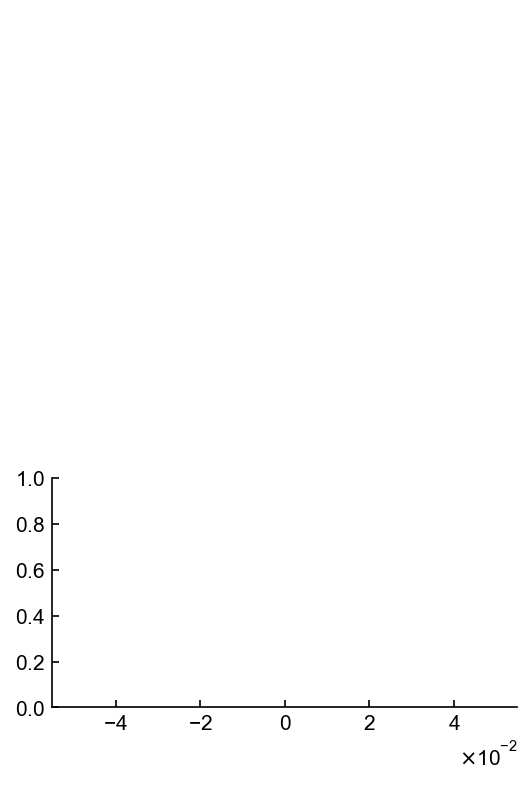

In [24]:
for session in AC_prelate:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Prelate')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Prelate')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Prelate')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_prelate.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

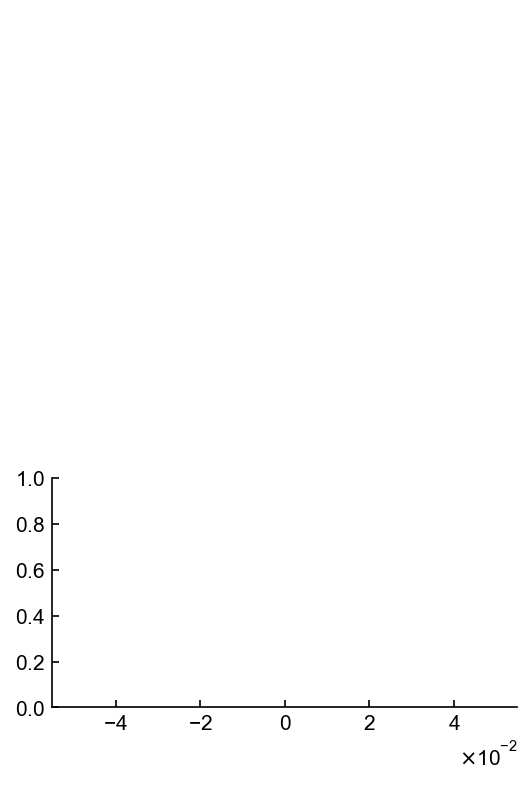

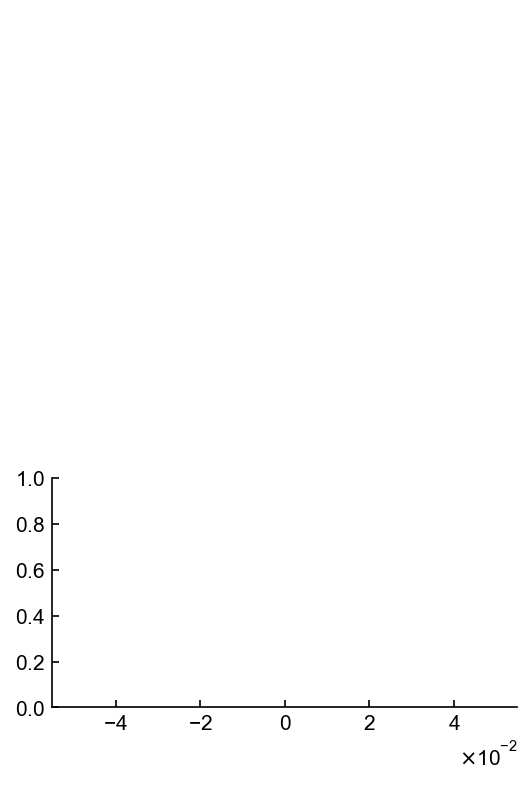

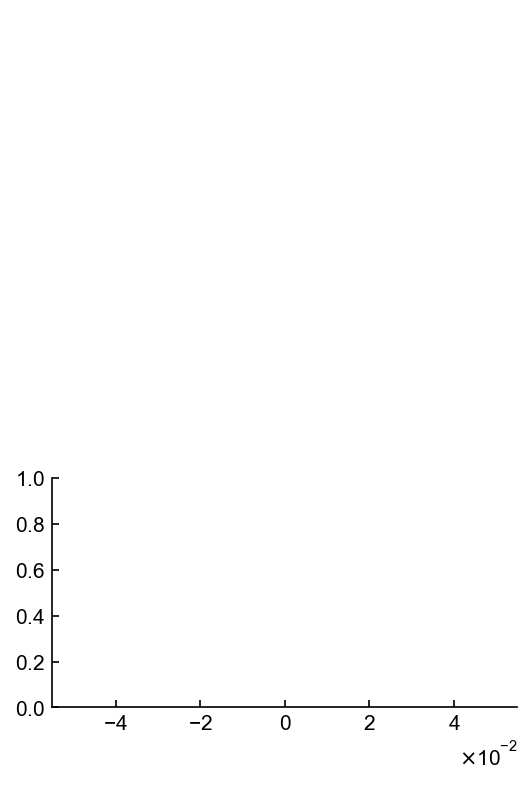

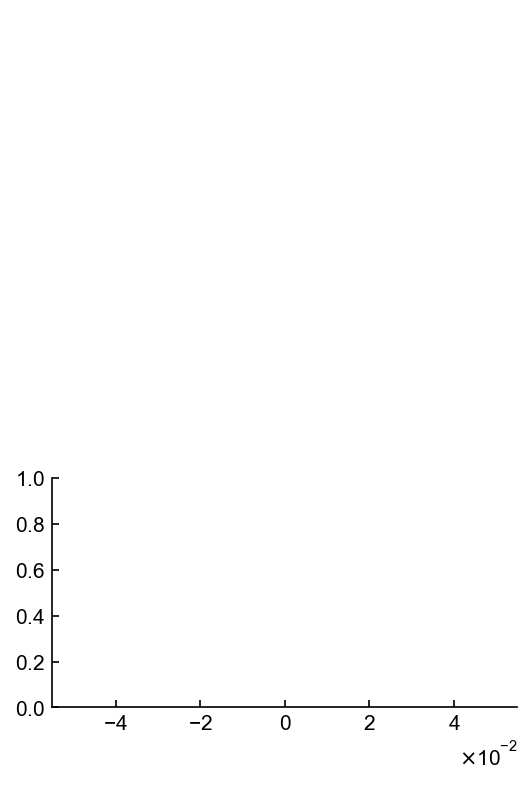

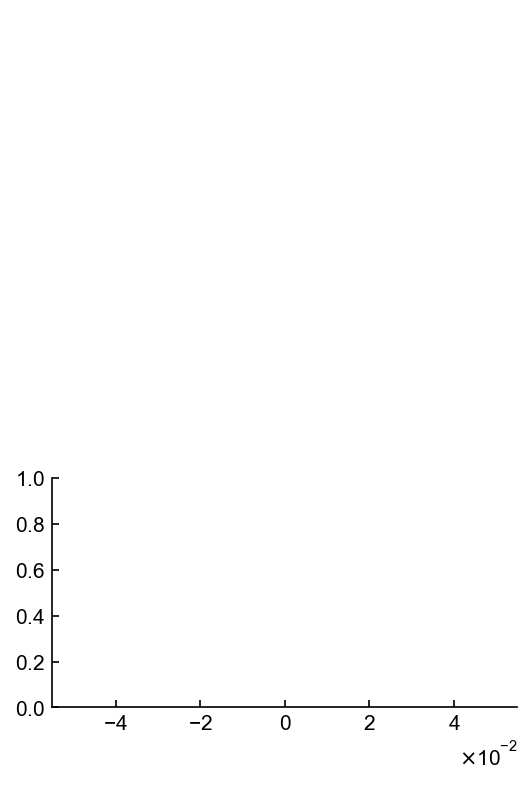

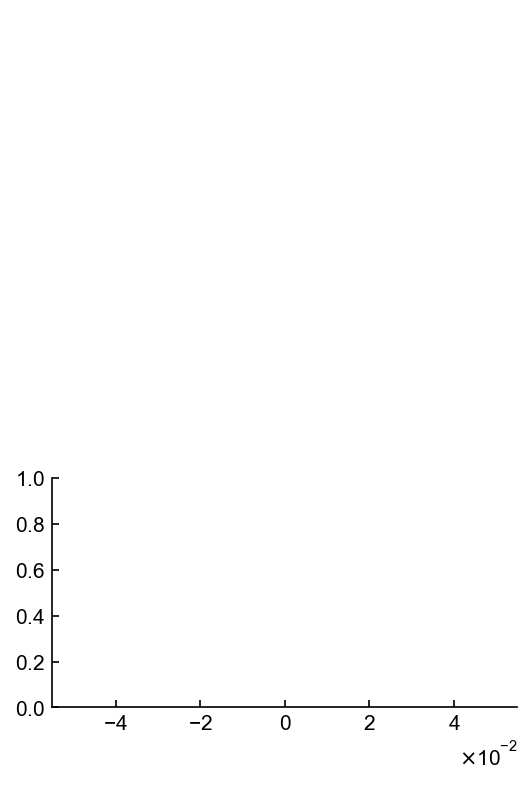

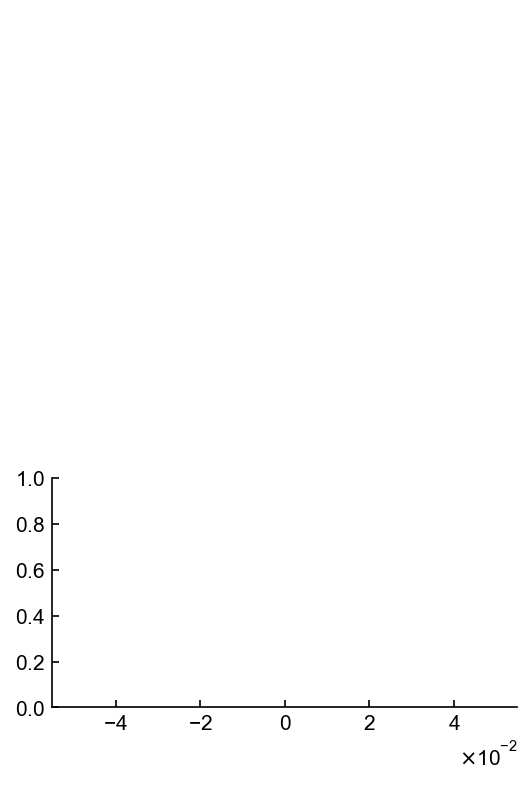

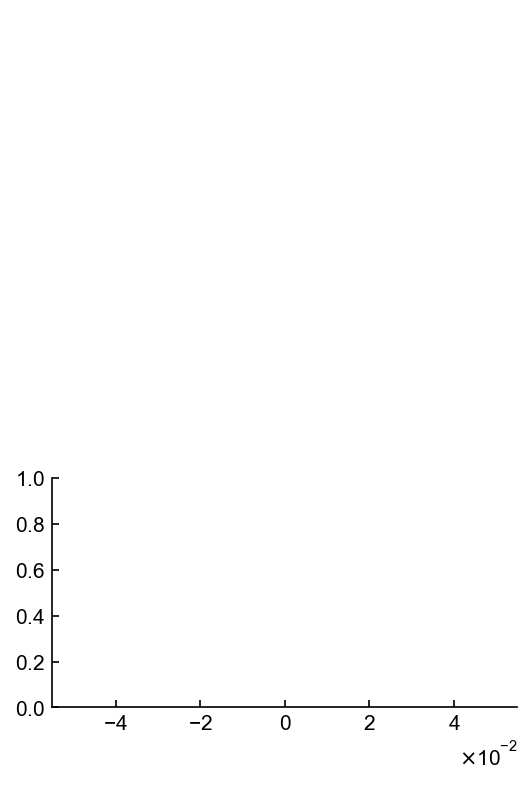

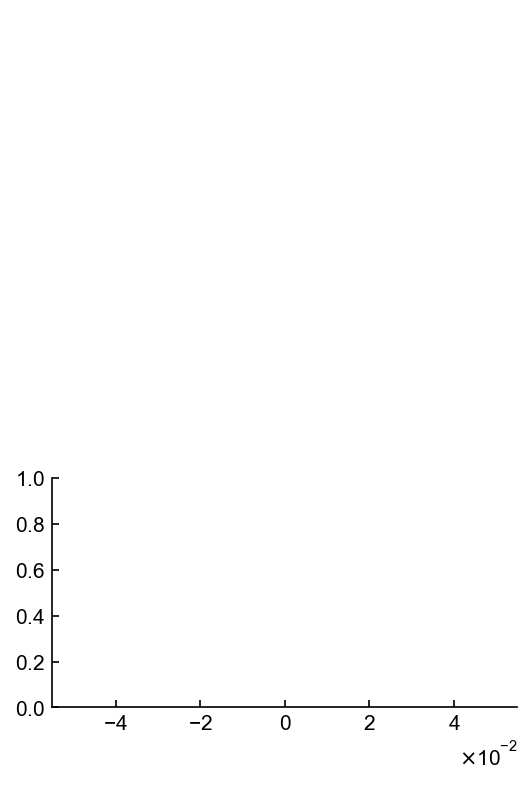

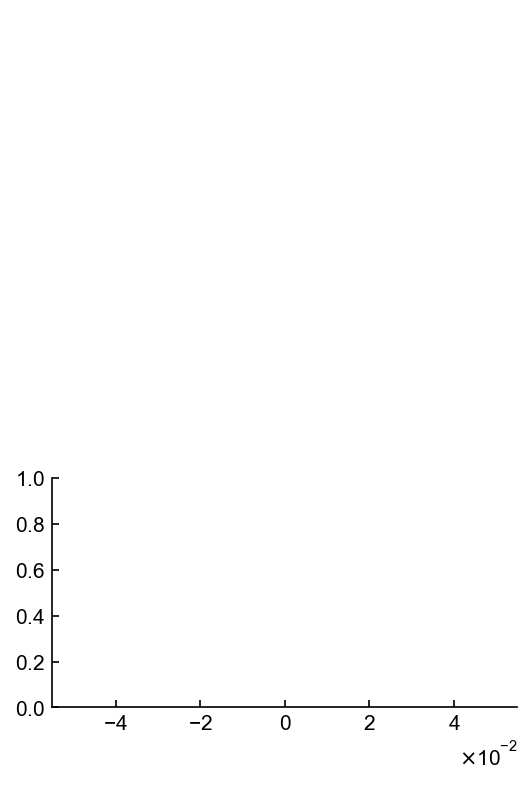

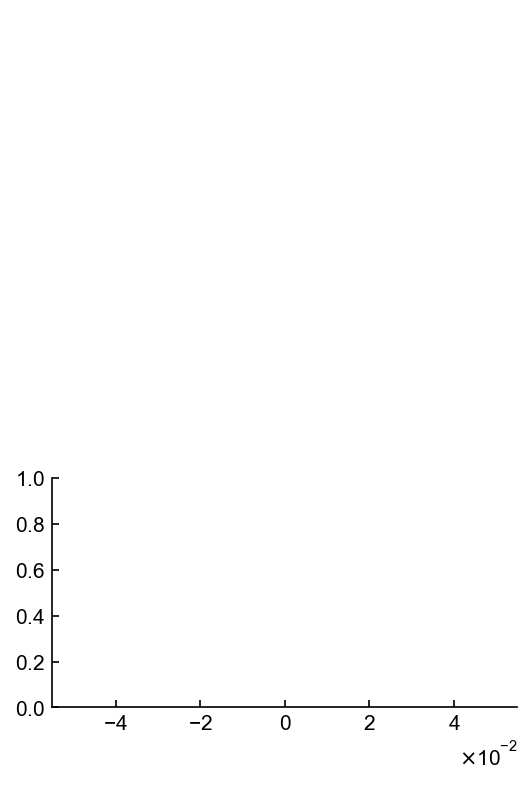

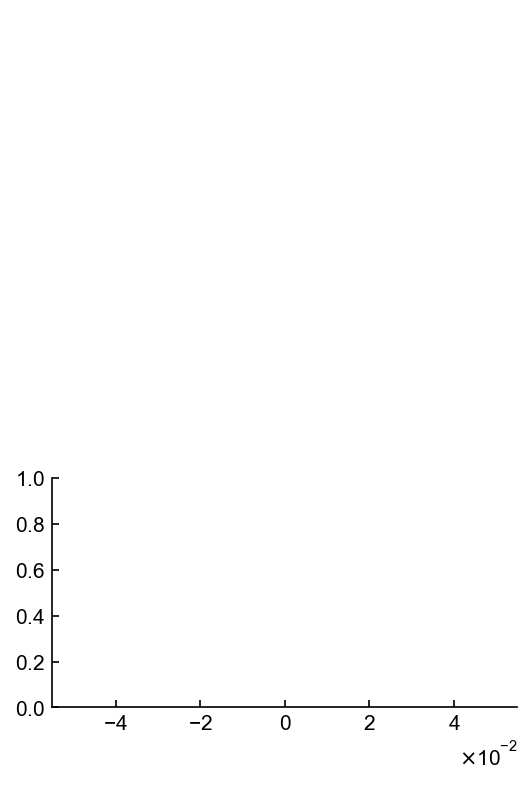

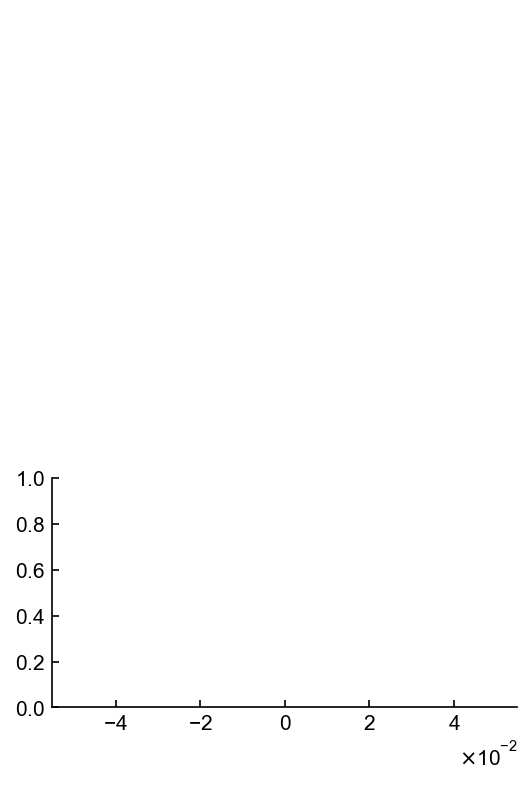

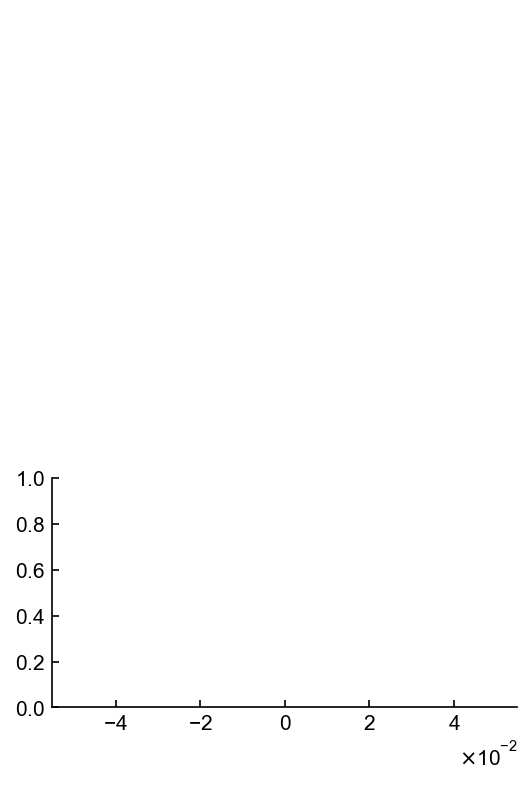

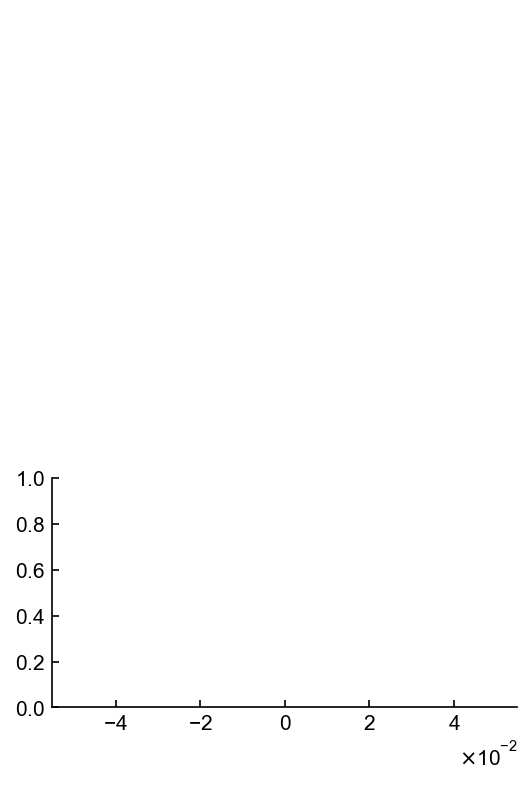

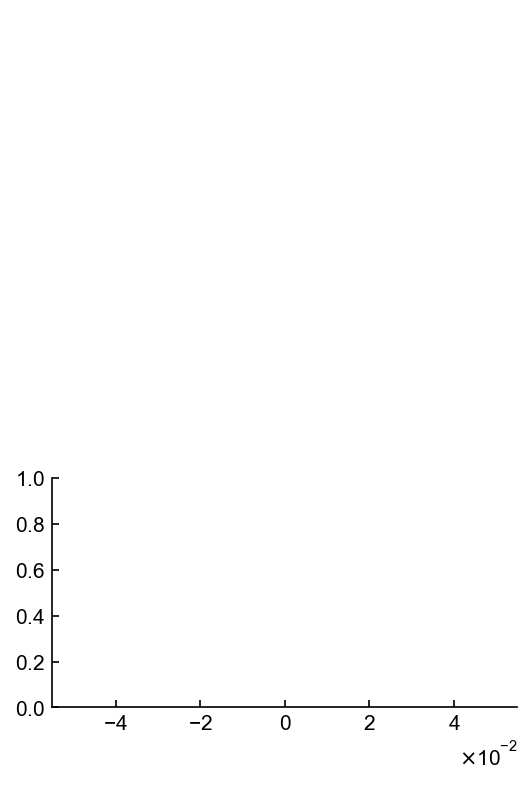

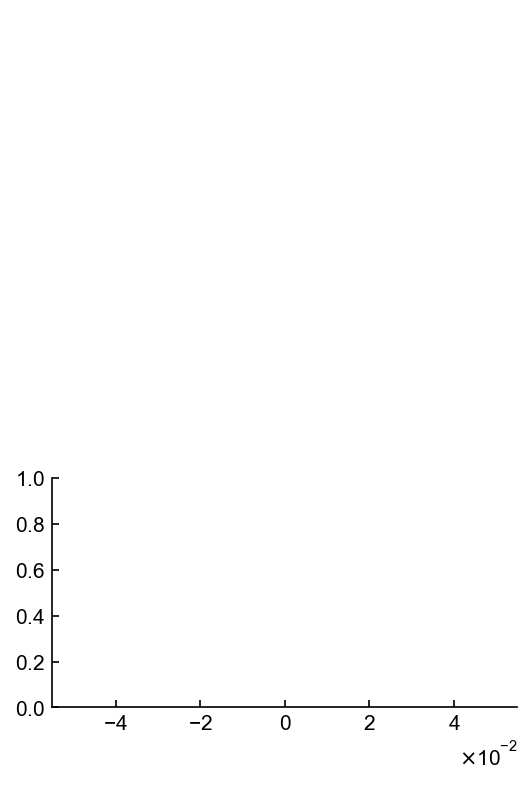

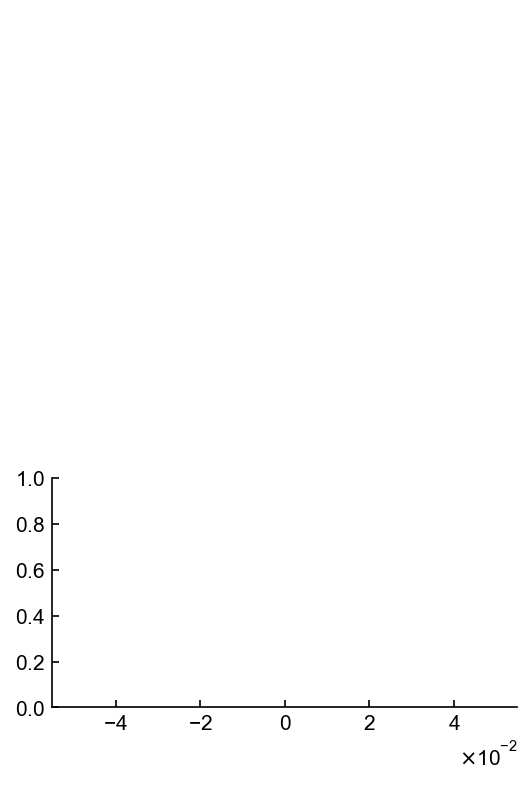

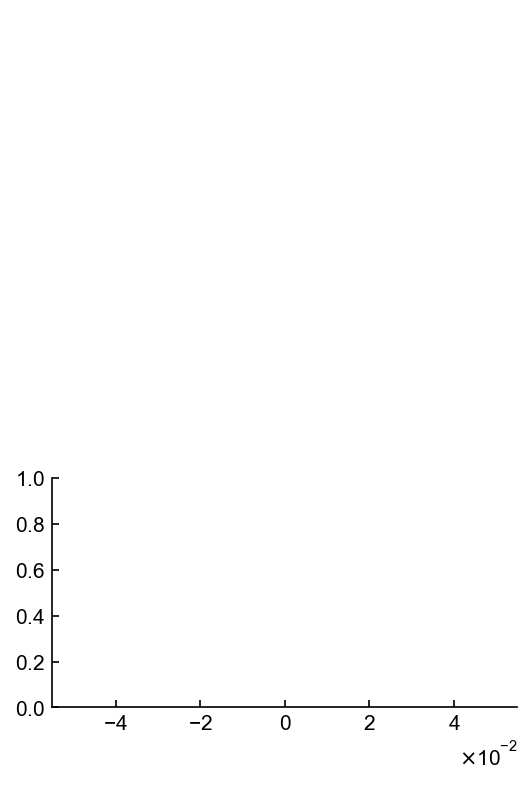

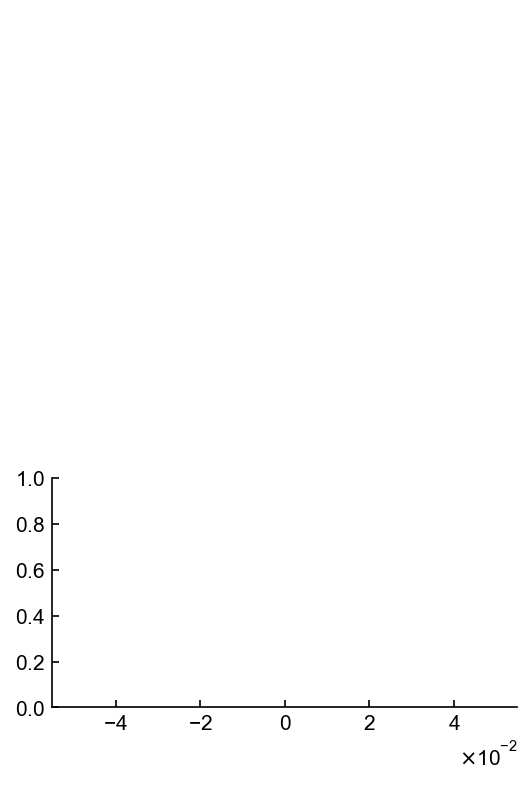

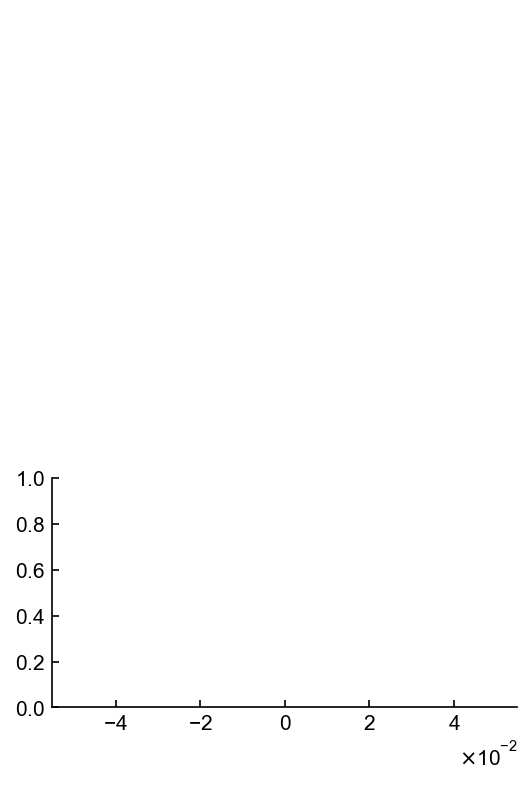

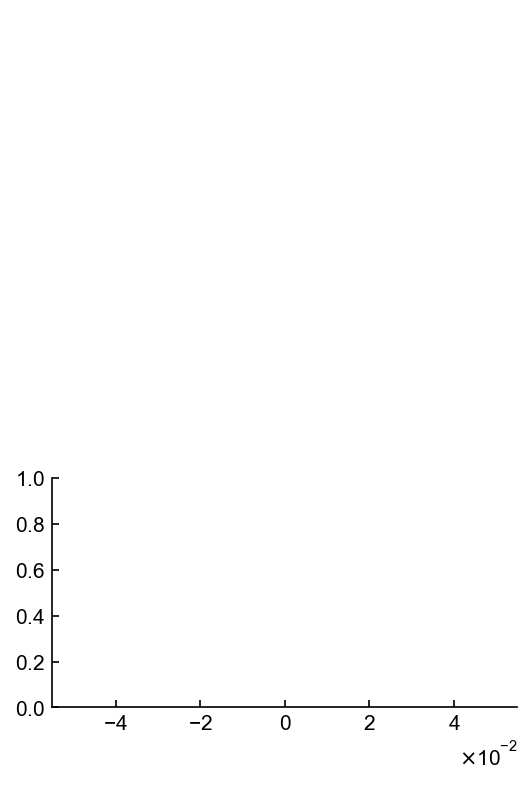

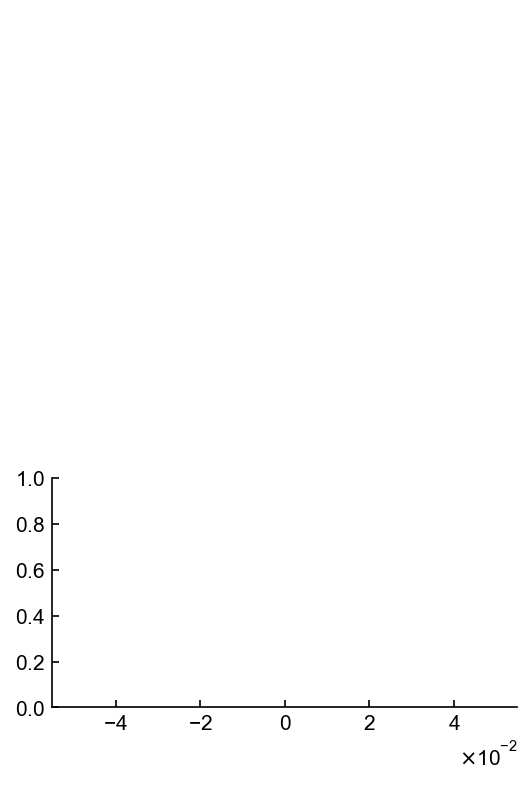

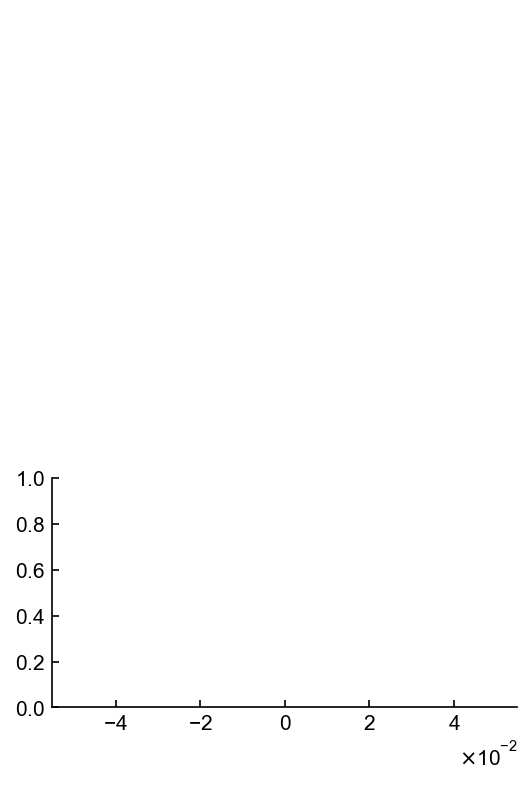

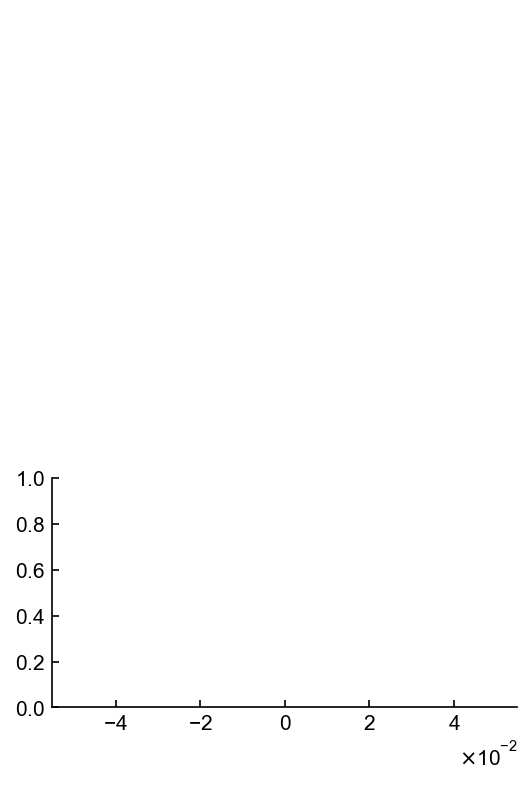

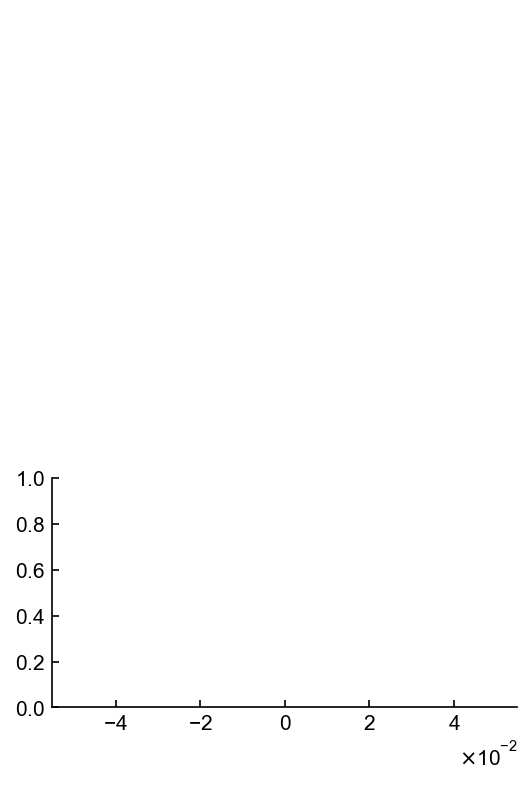

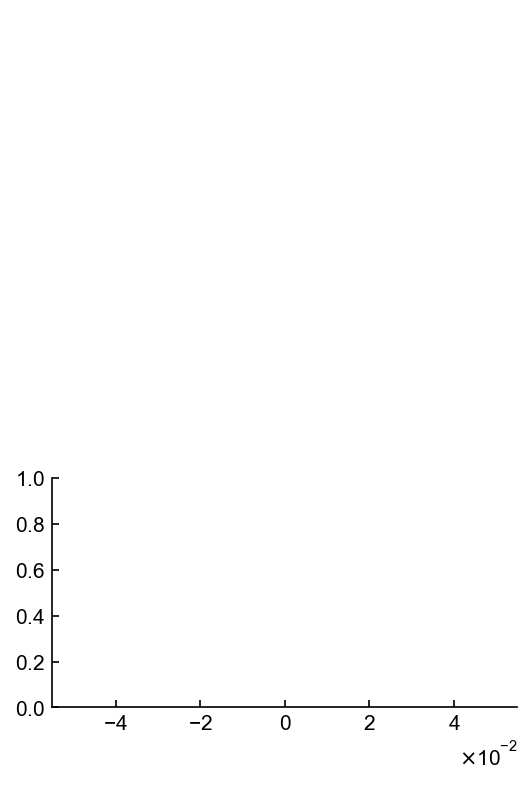

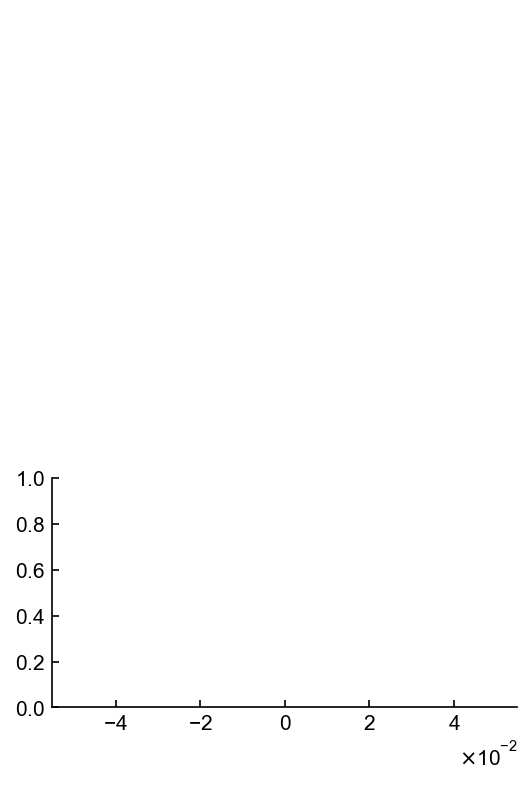

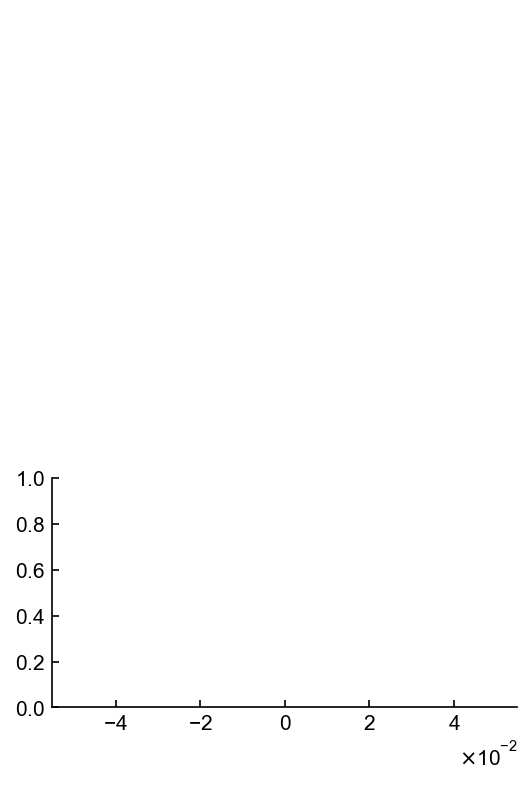

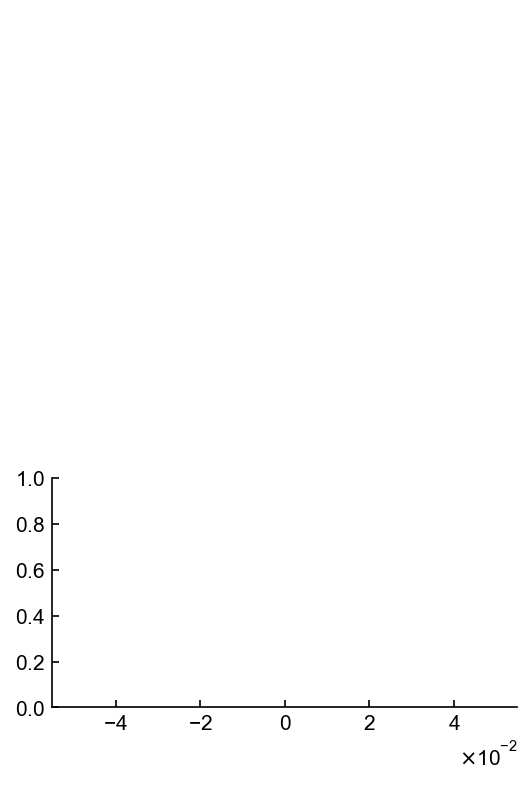

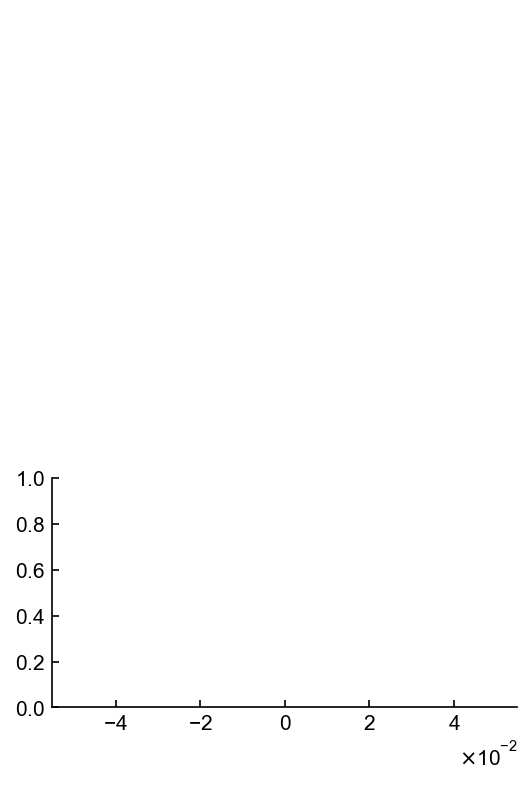

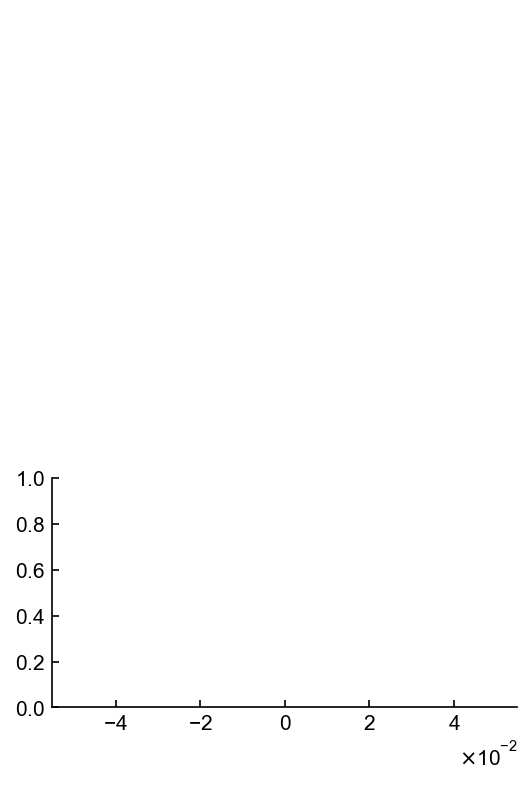

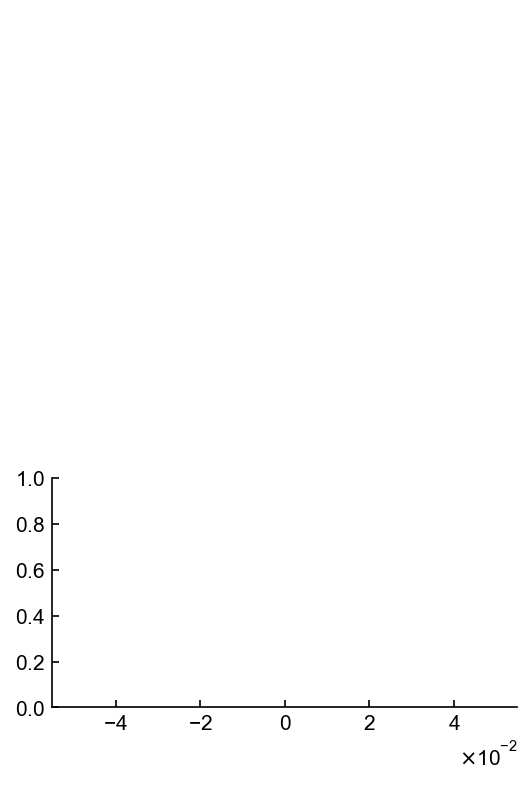

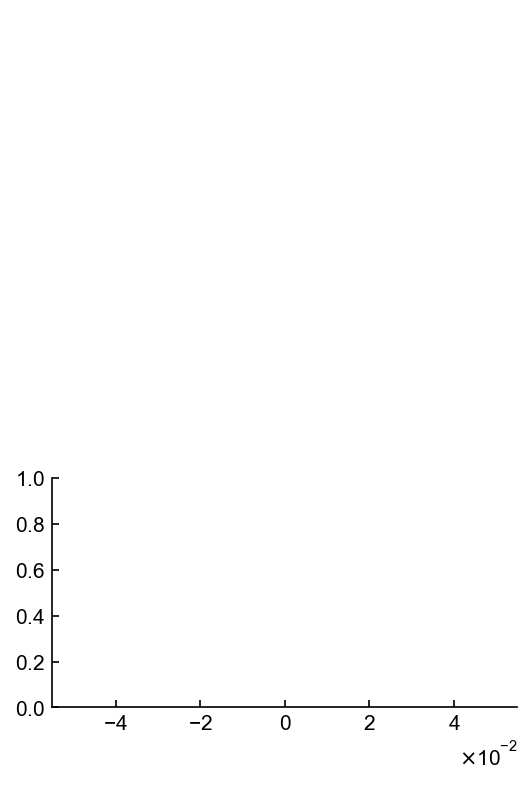

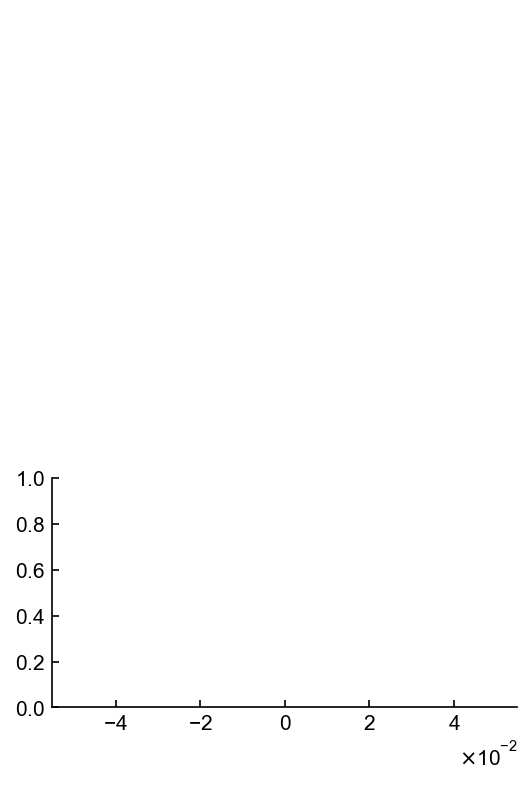

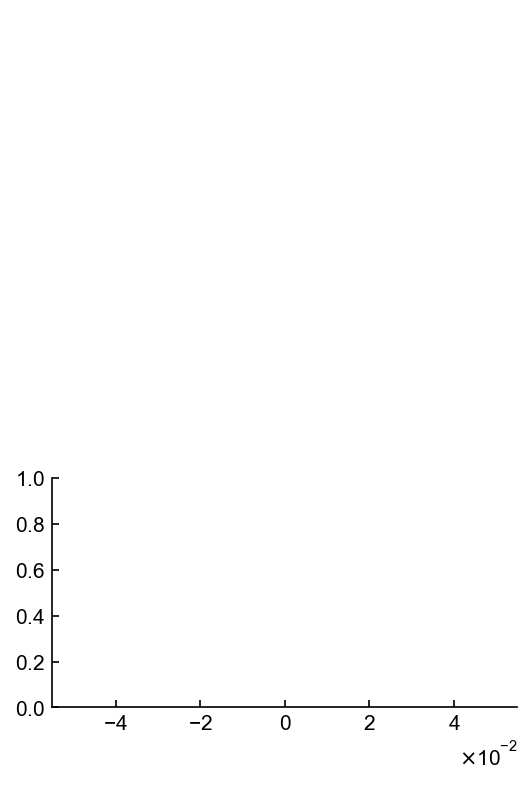

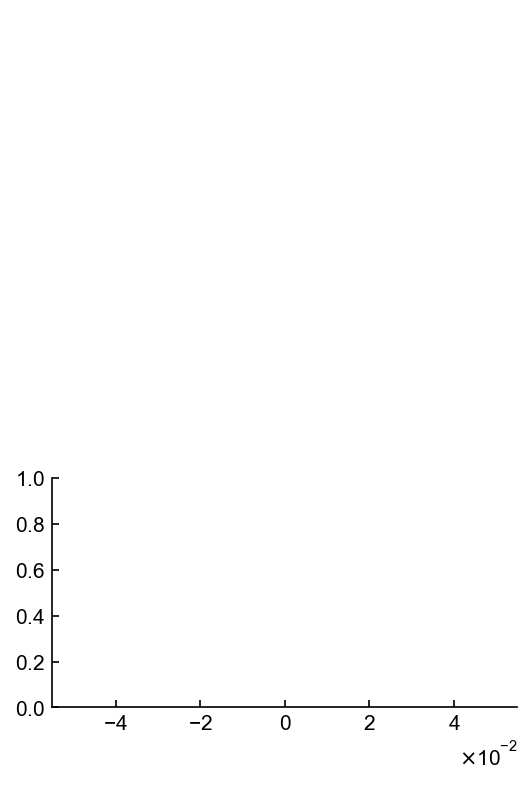

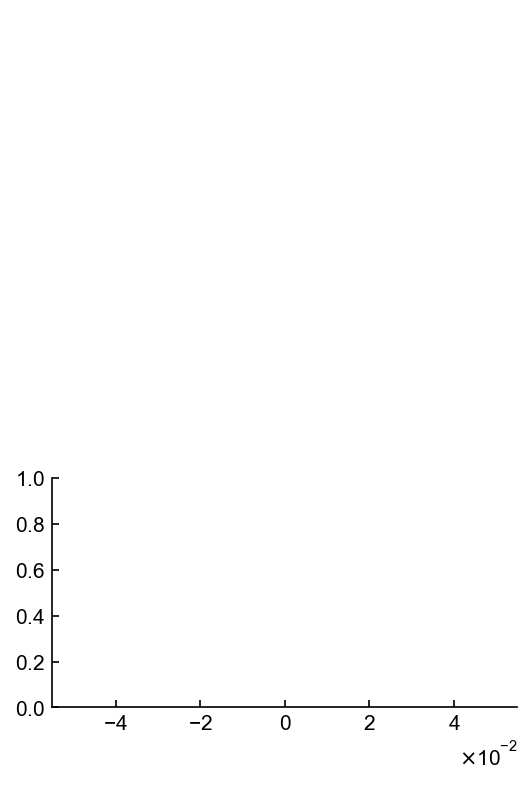

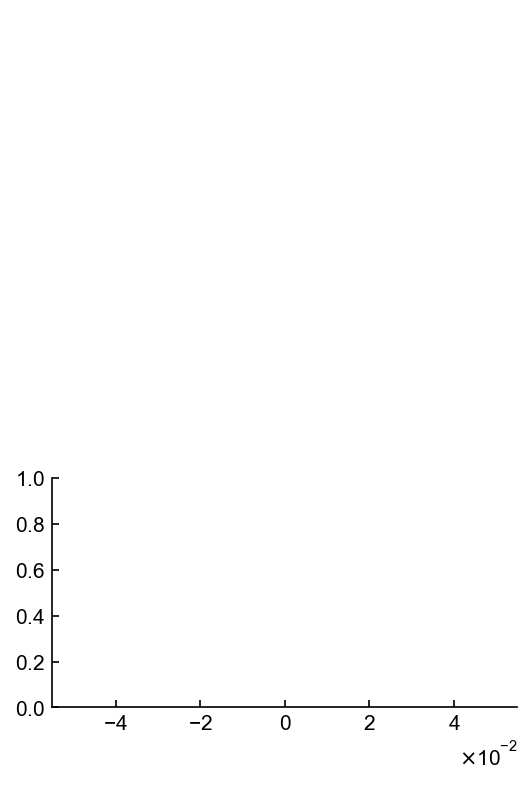

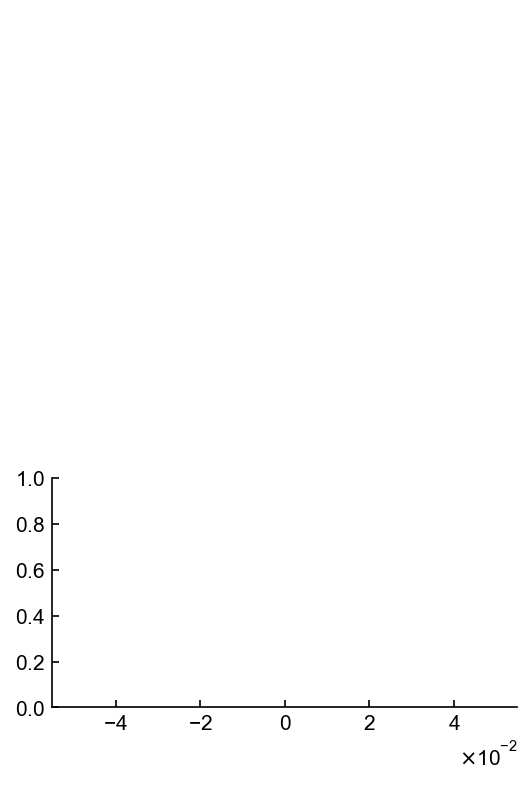

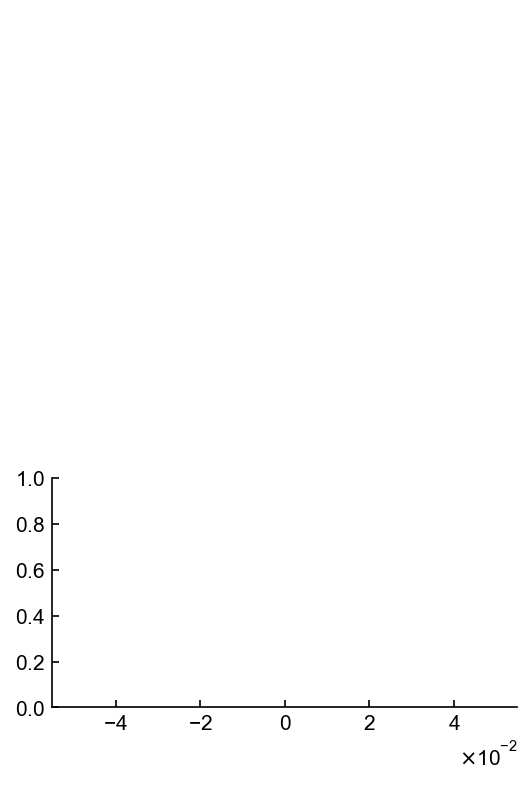

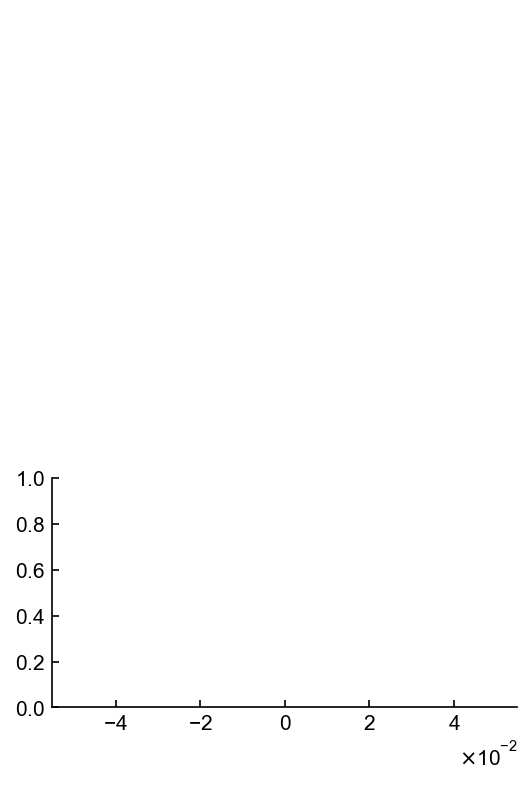

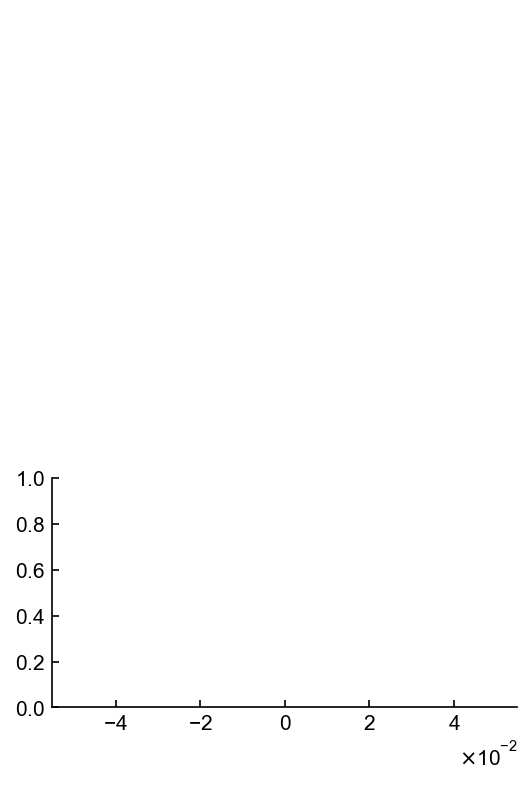

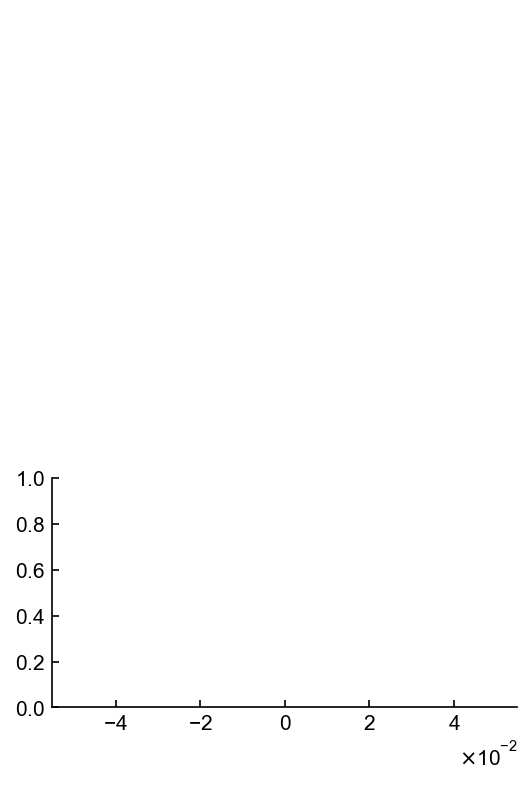

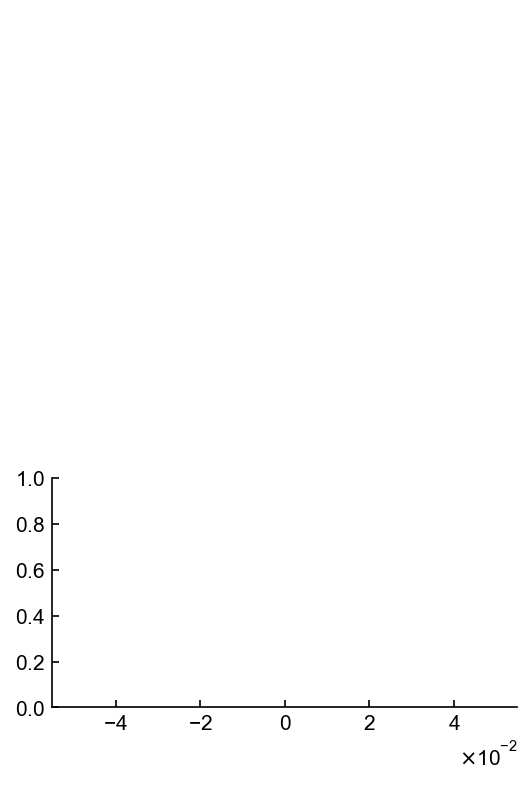

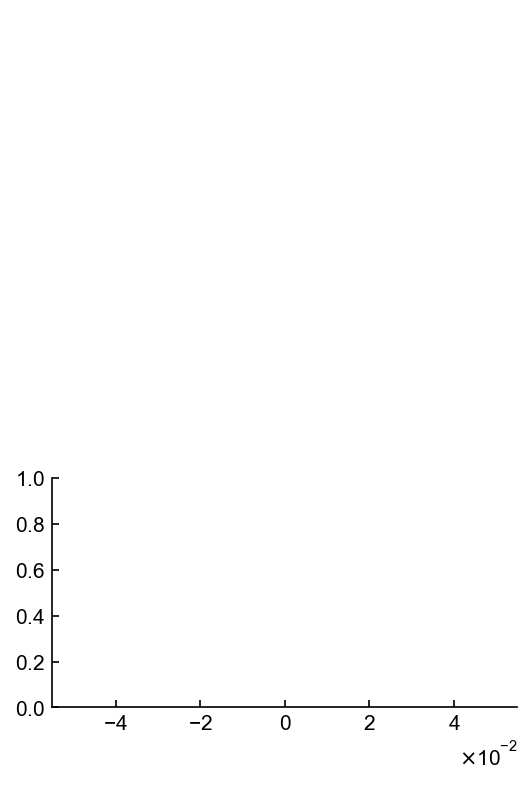

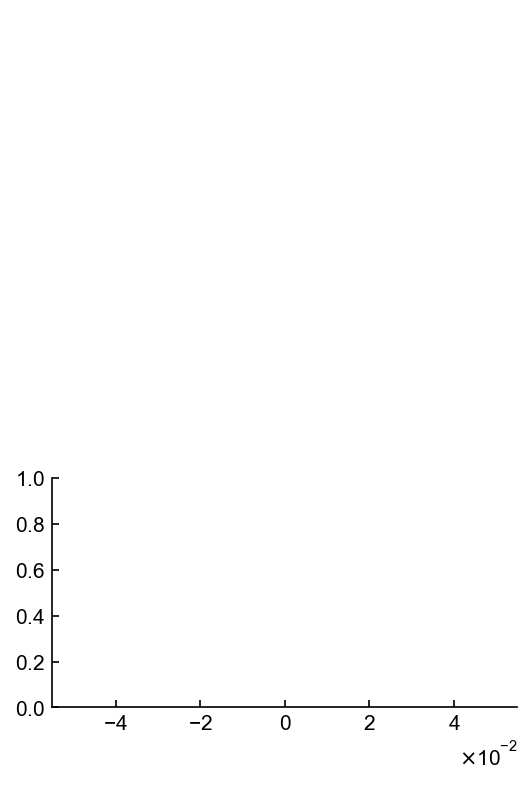

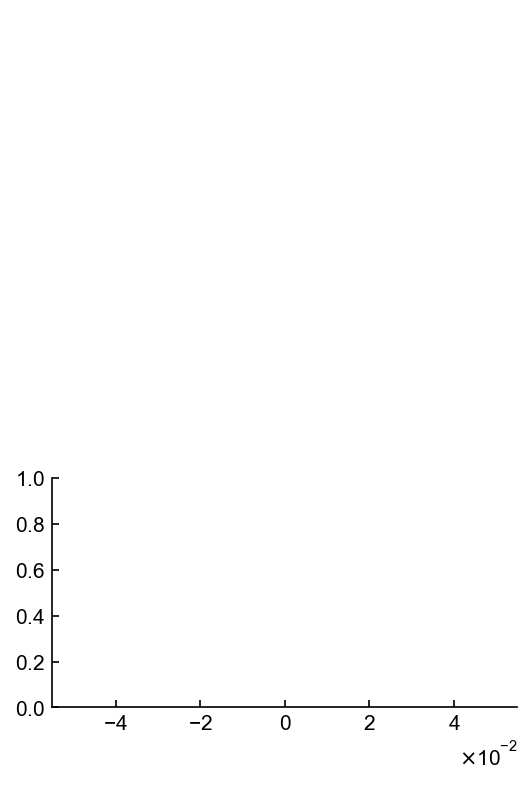

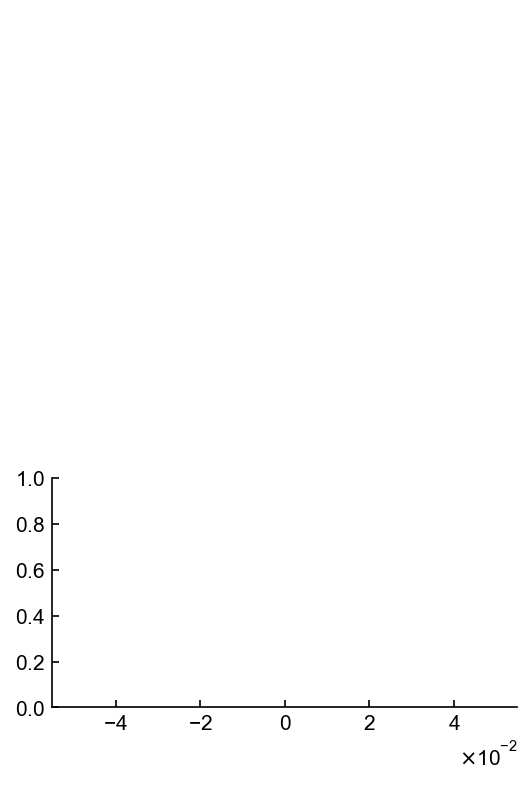

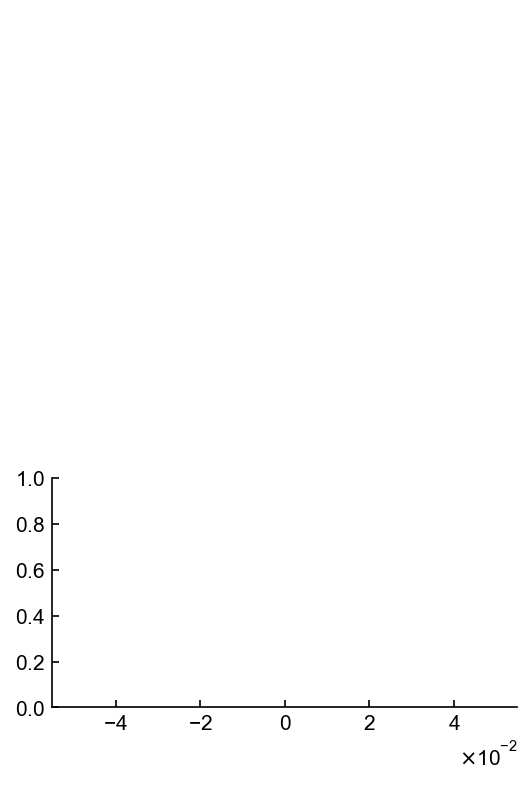

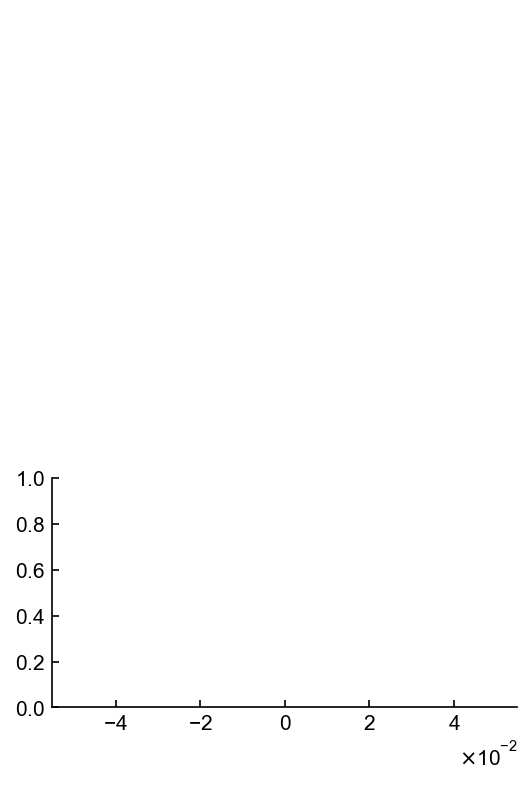

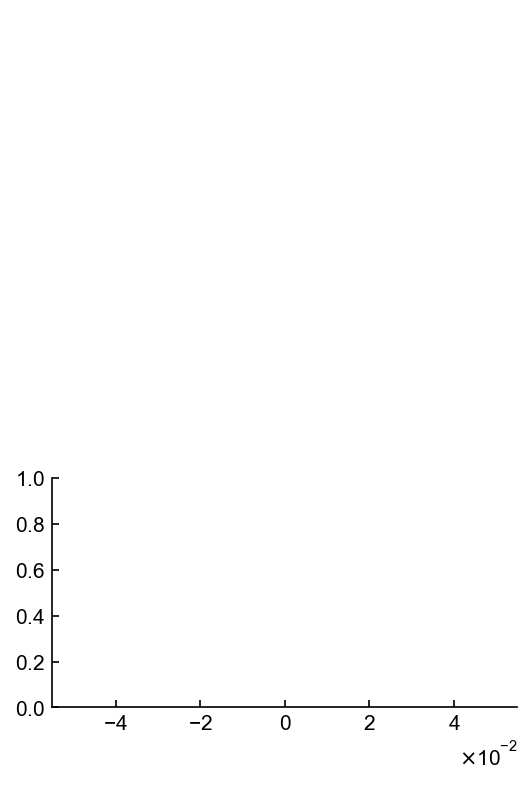

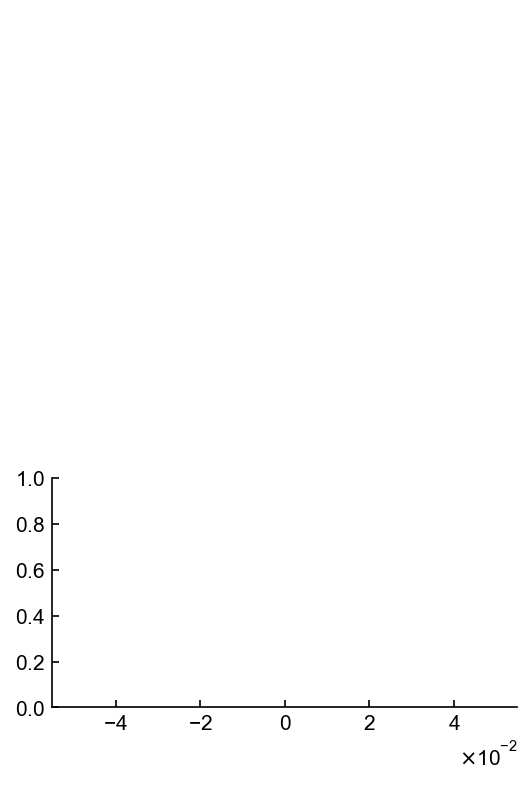

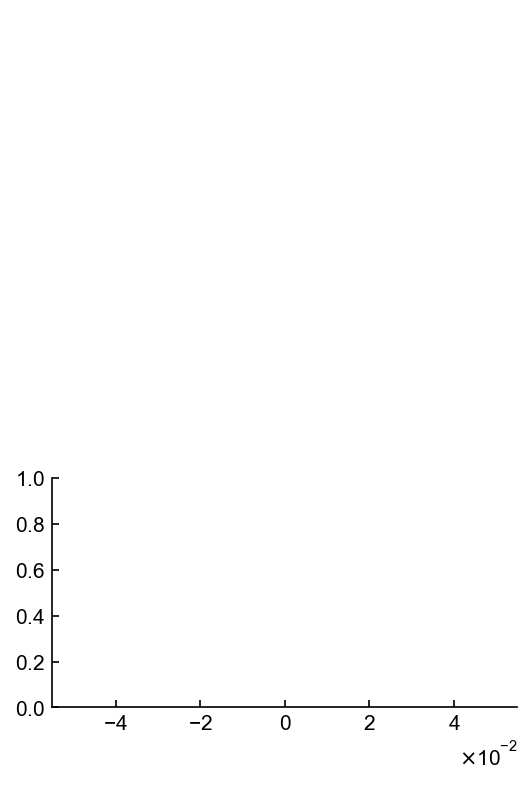

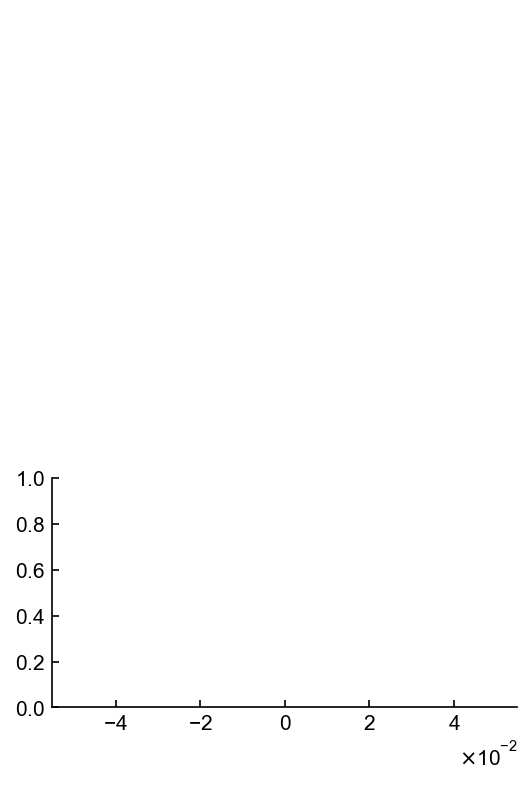

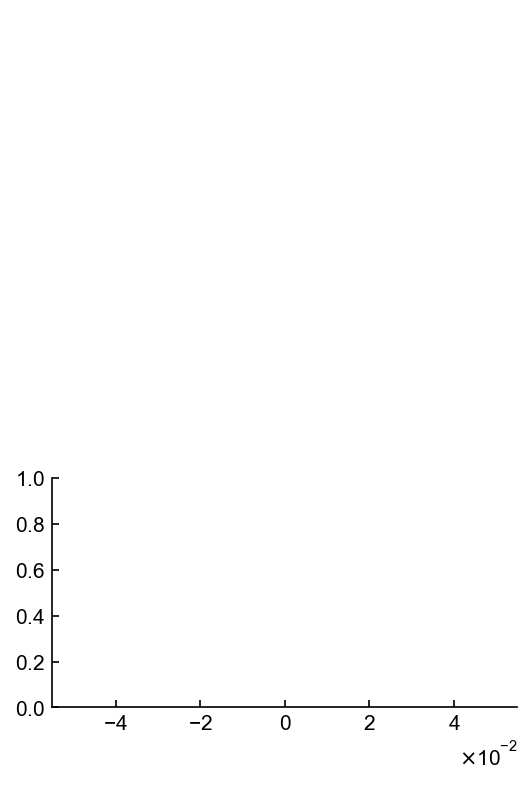

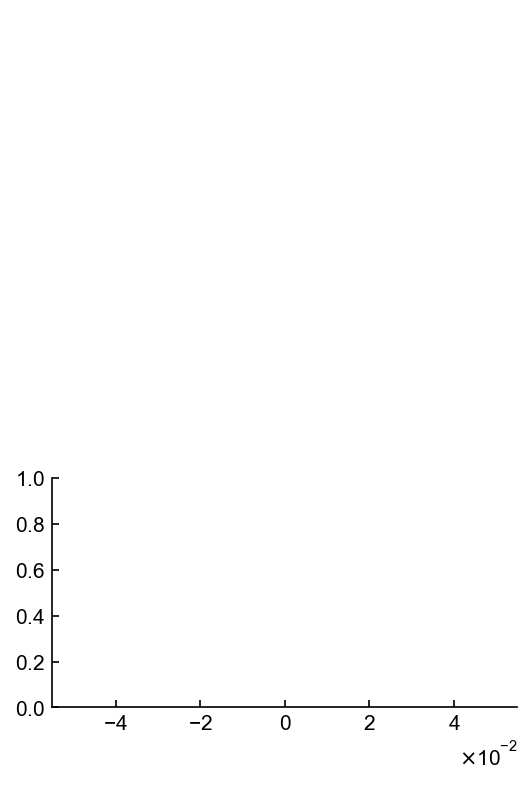

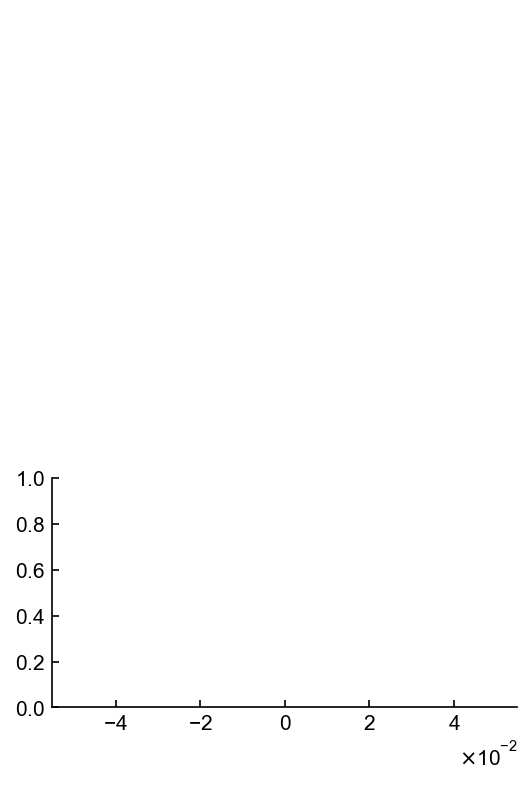

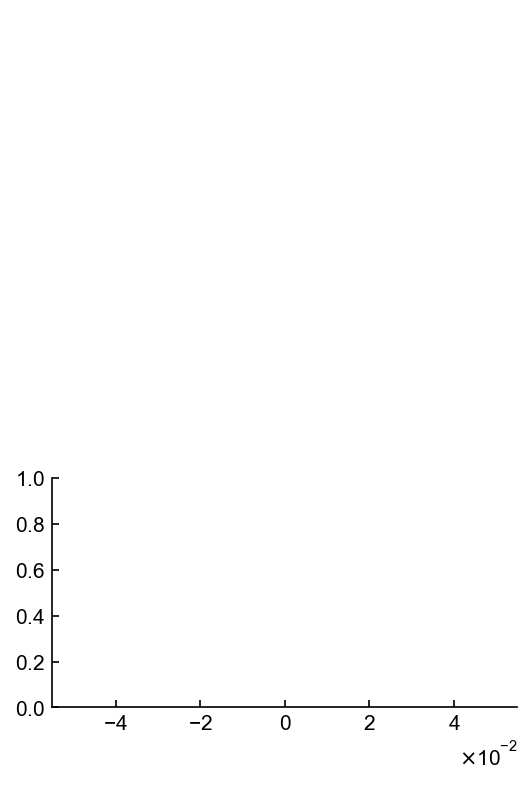

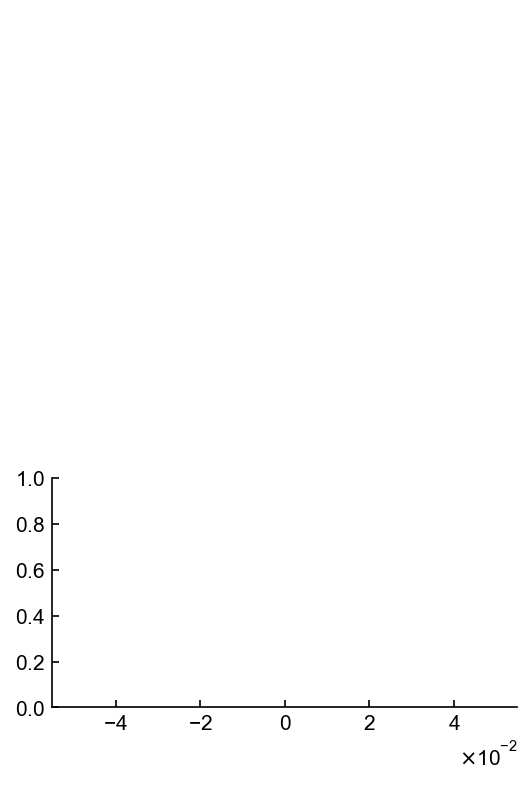

In [25]:
for session in AC_preexpert:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Preexpert')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Preexpert')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Preexpert')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_preexpert.append(peak_time)

In [26]:
for session in AC_postearly:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Postearly')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Postearly')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postearly')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_postearly.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

In [27]:
for session in AC_postlate:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Postlate')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Postlate')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postlate')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_postlate.append(peak_time)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how

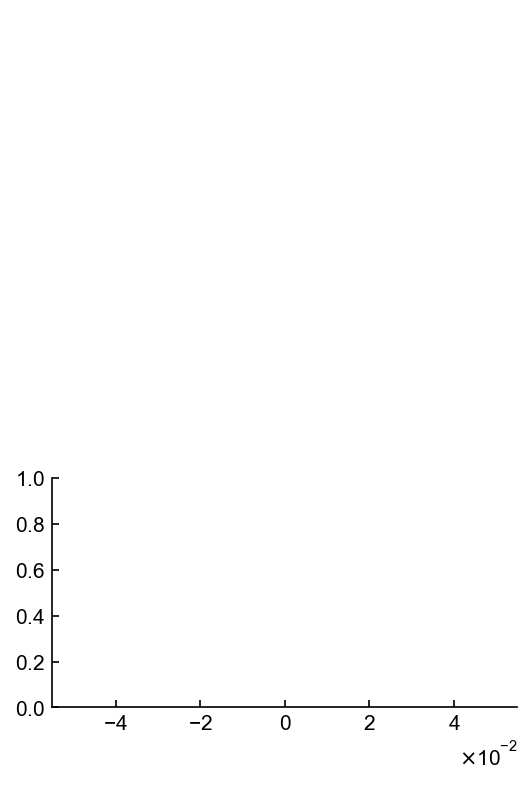

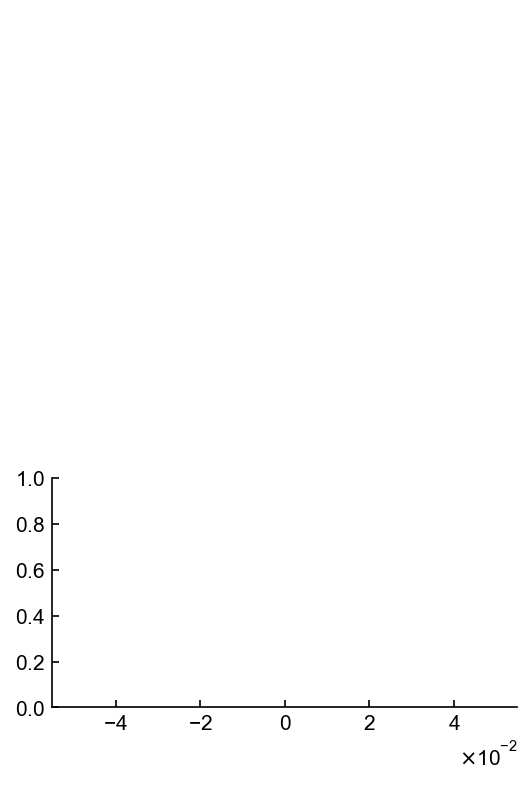

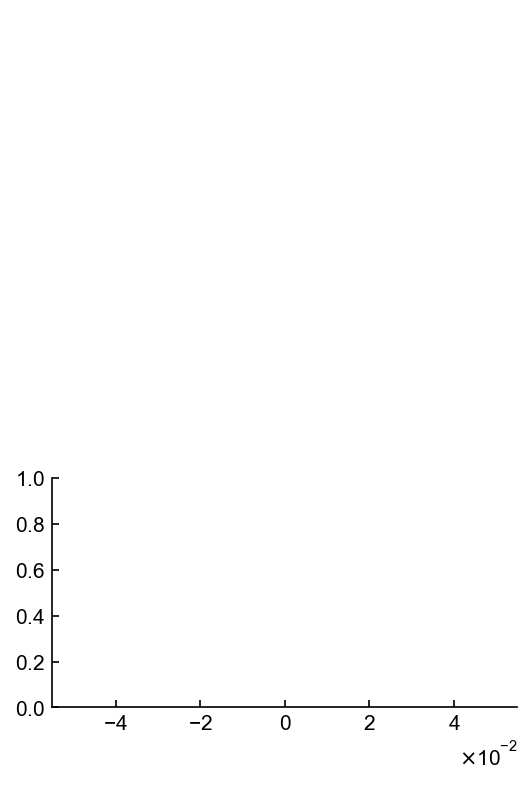

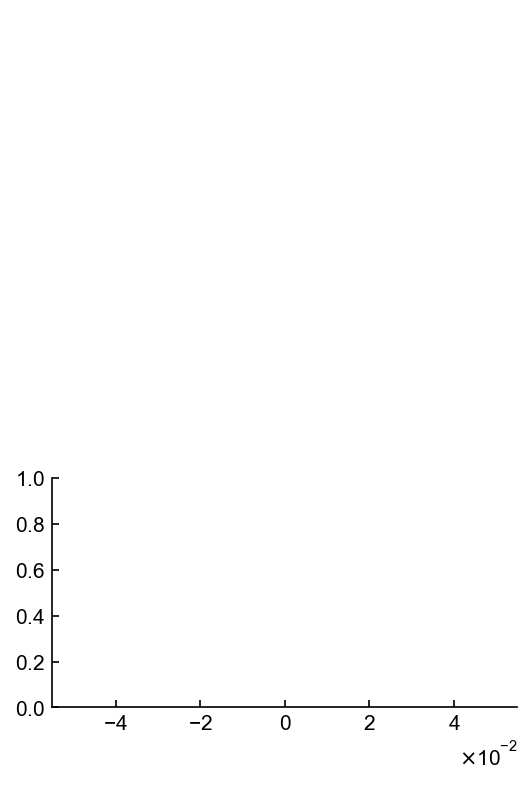

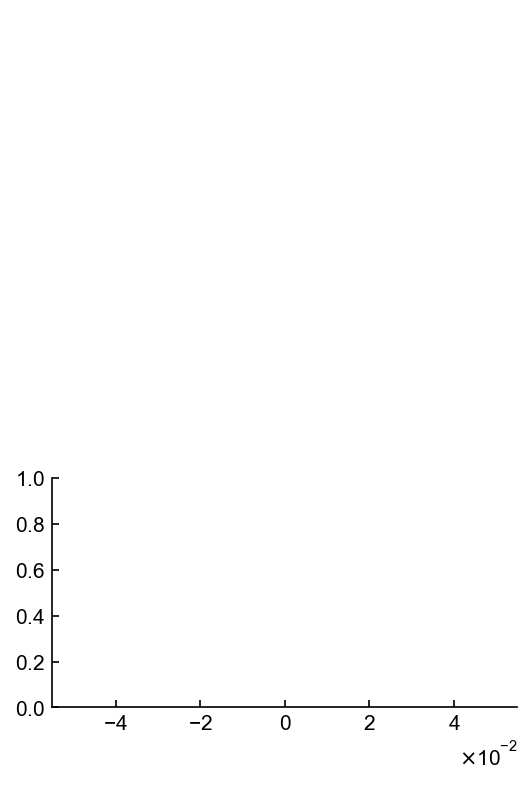

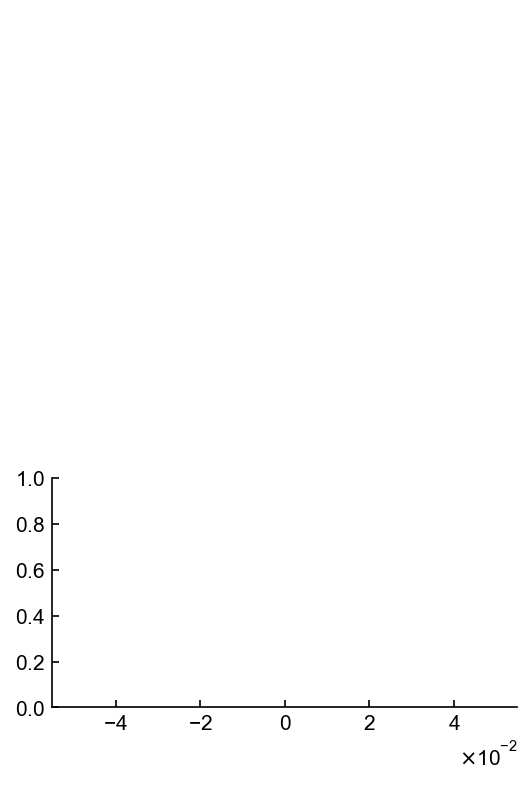

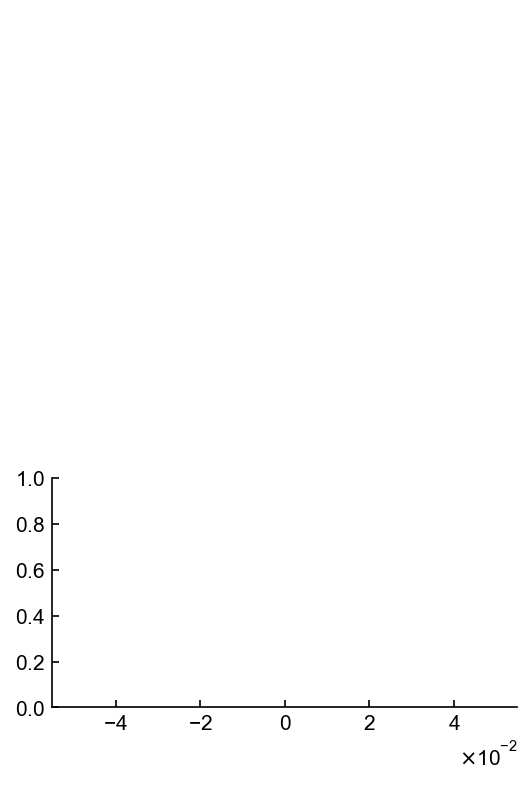

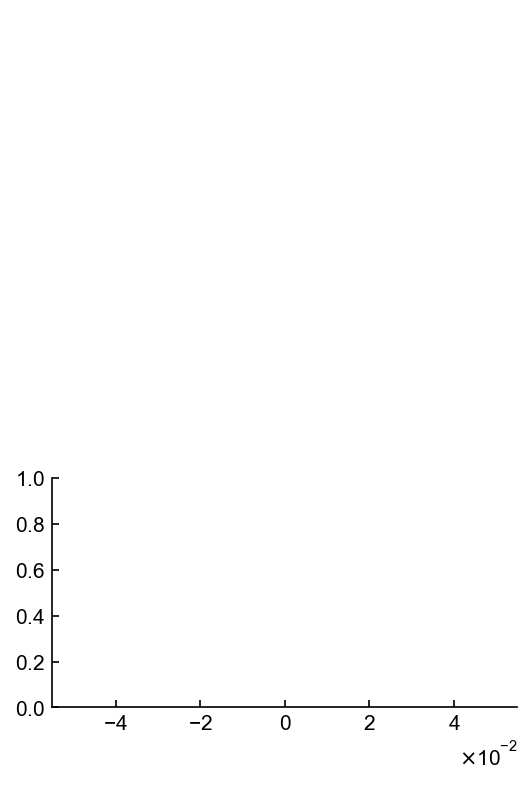

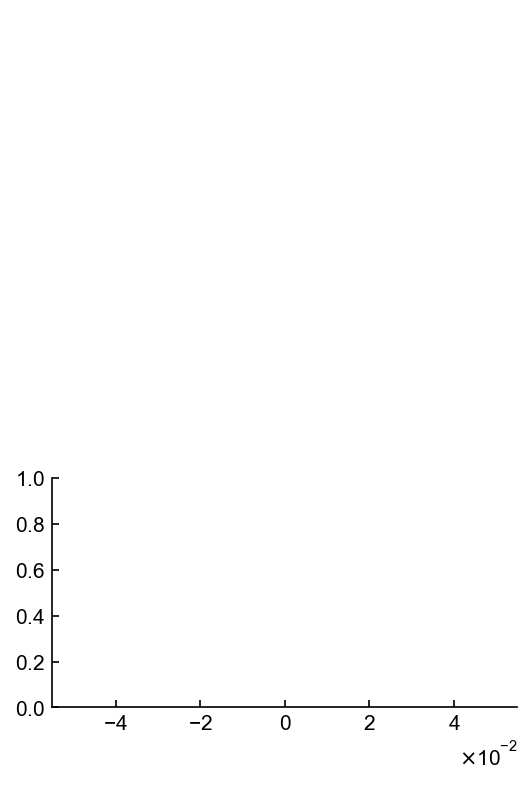

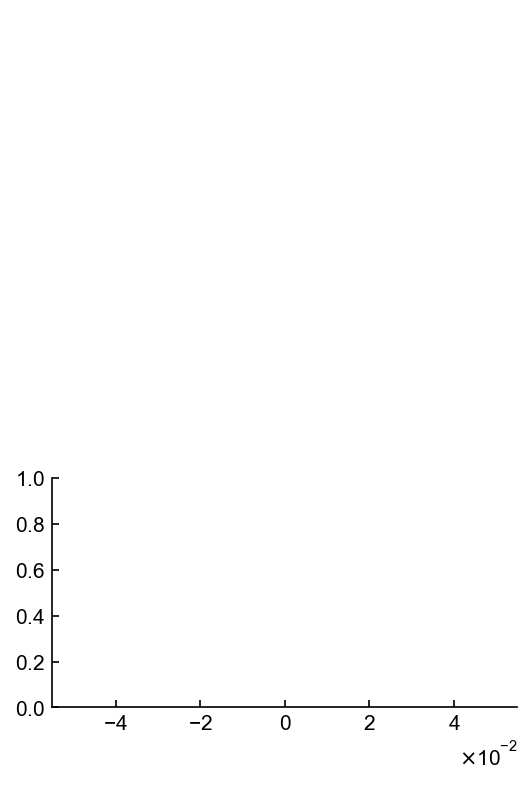

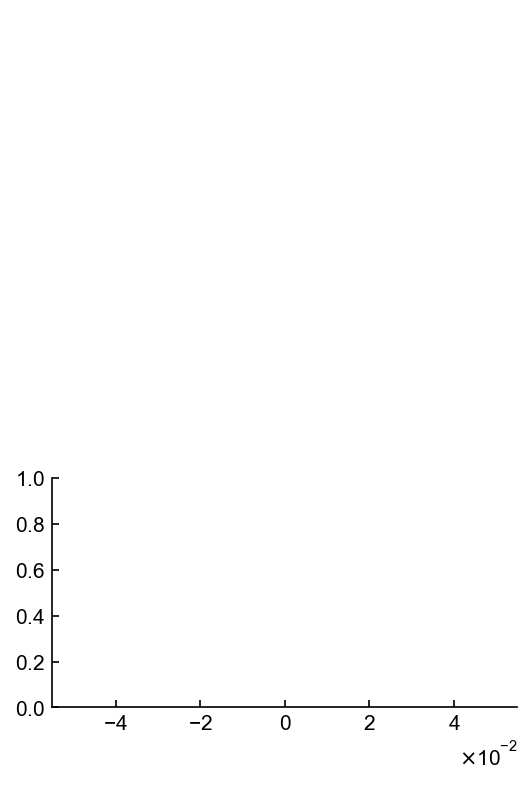

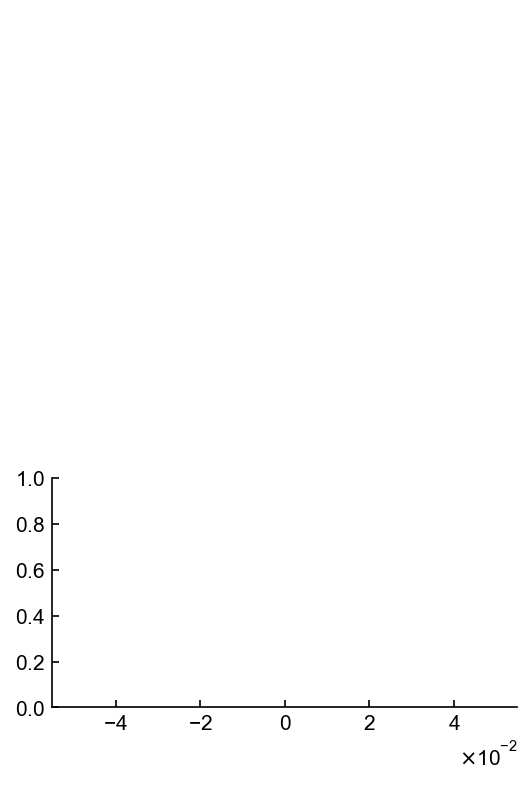

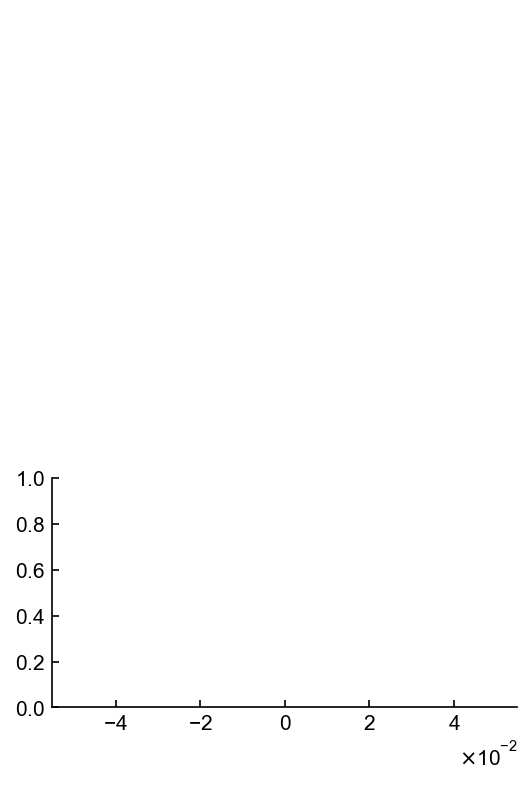

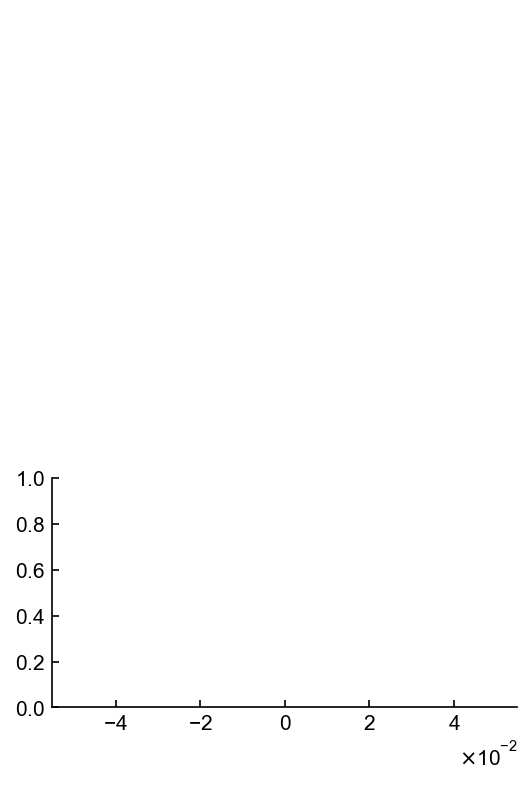

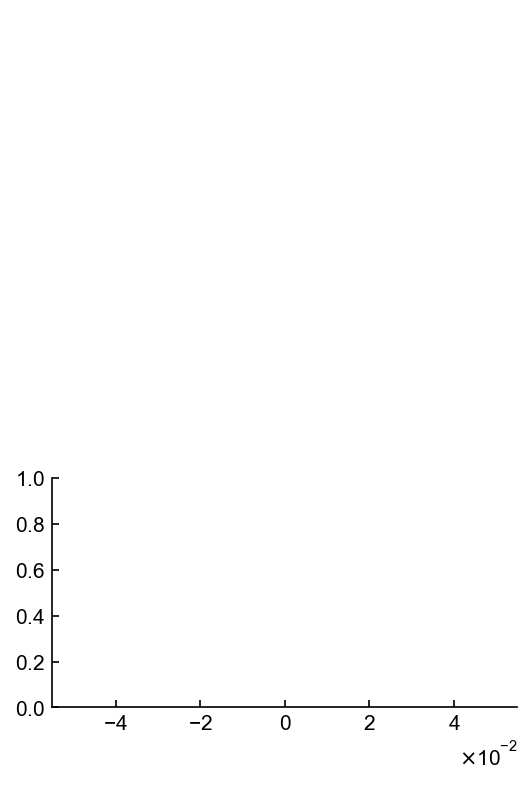

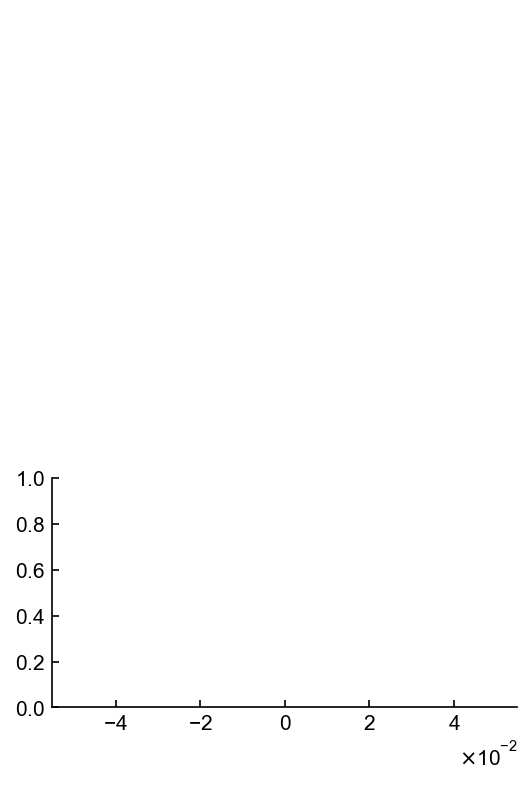

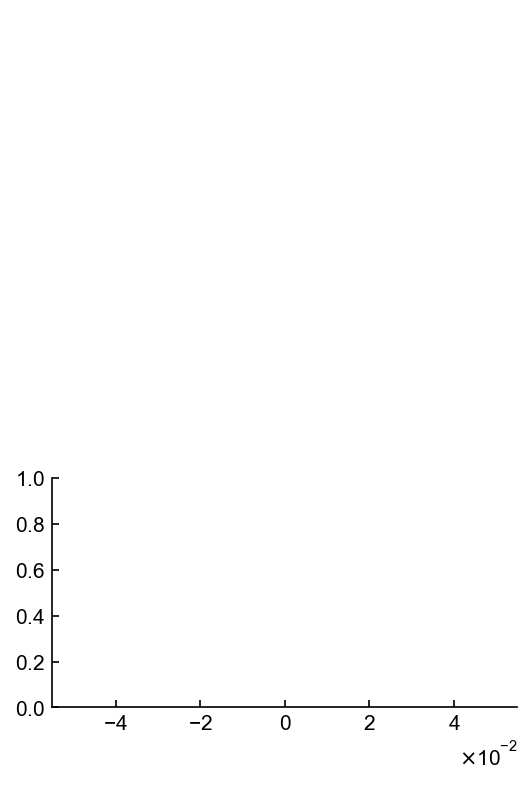

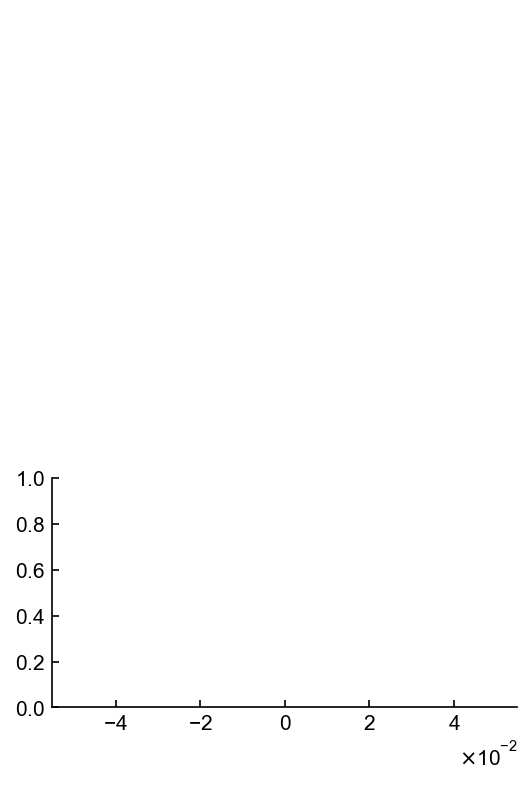

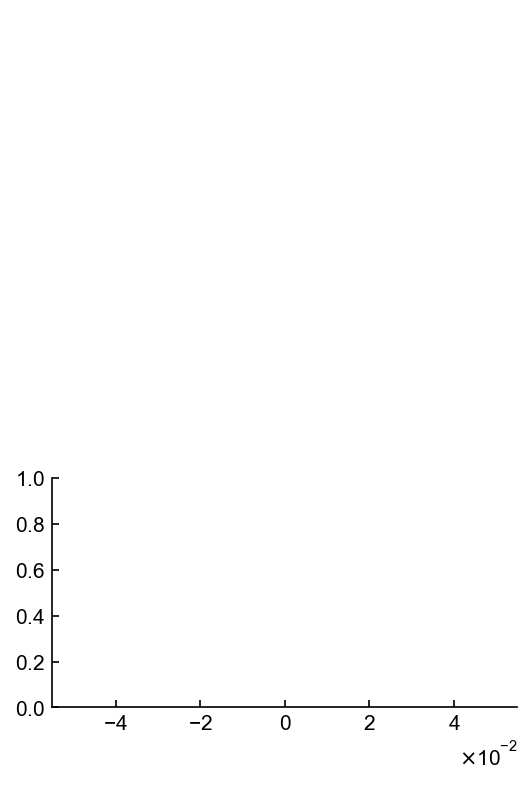

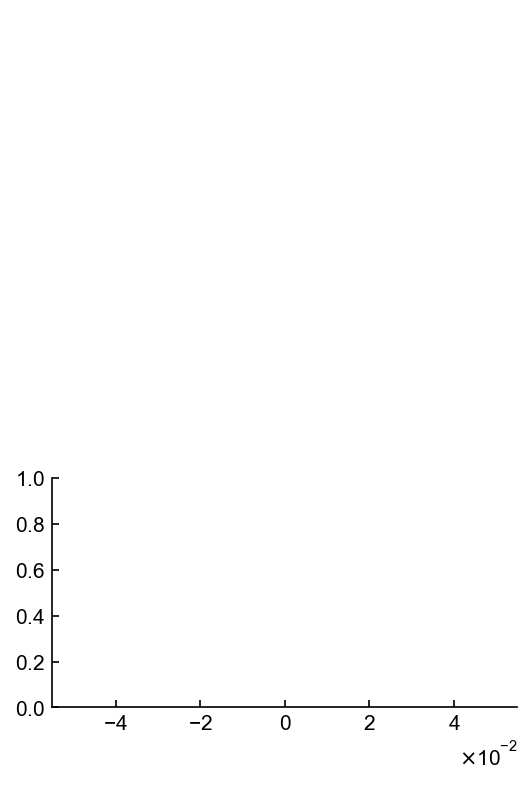

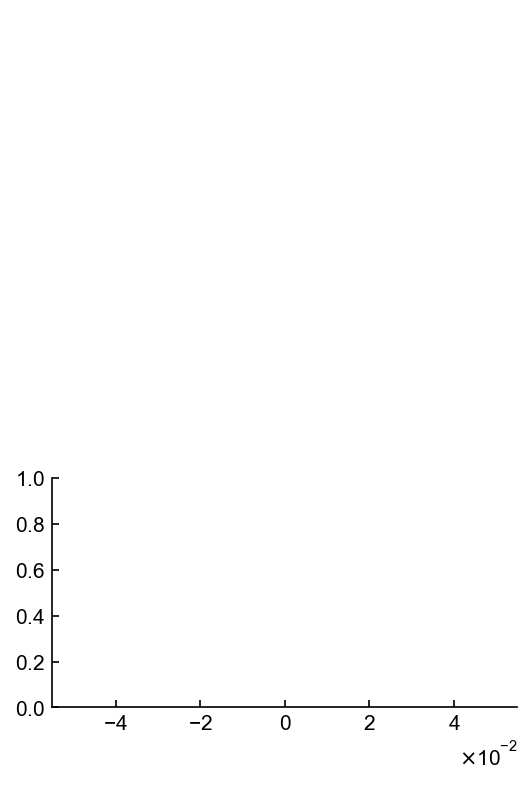

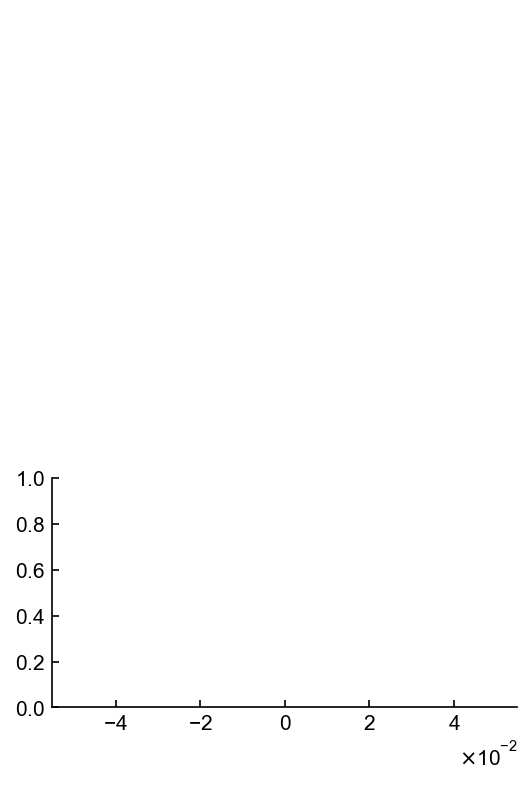

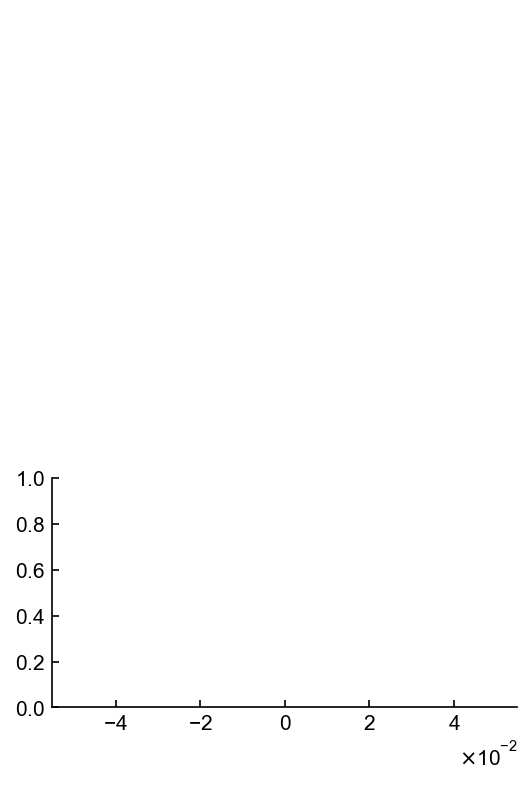

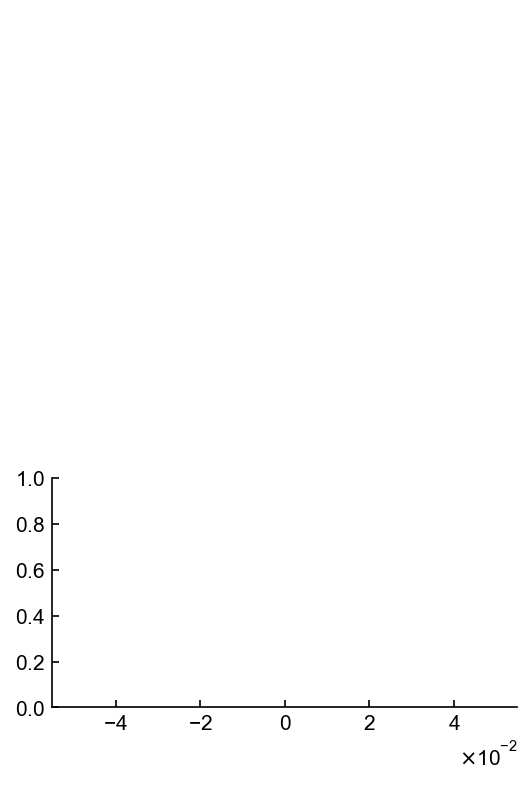

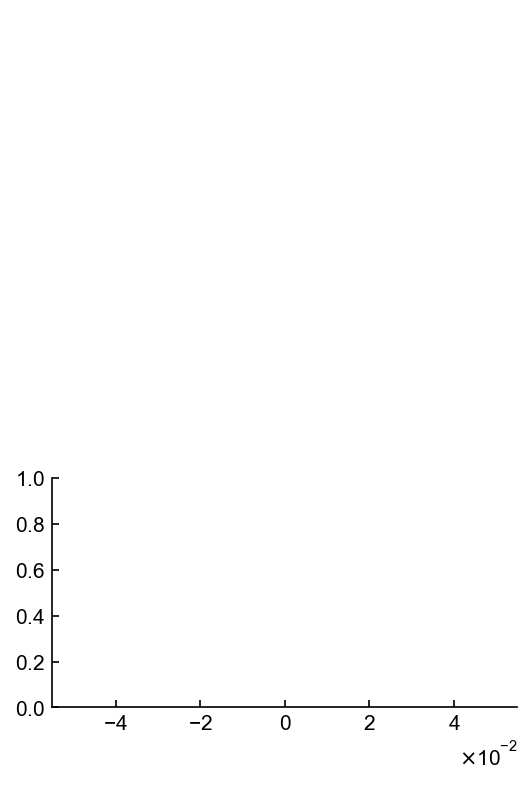

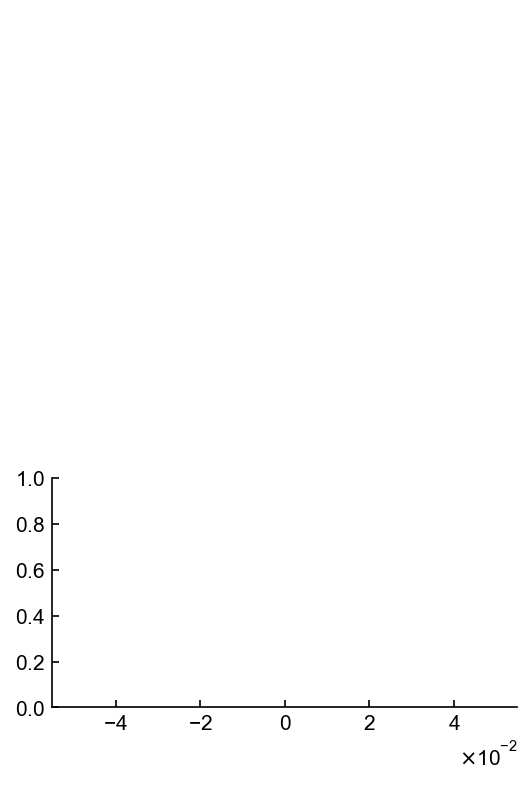

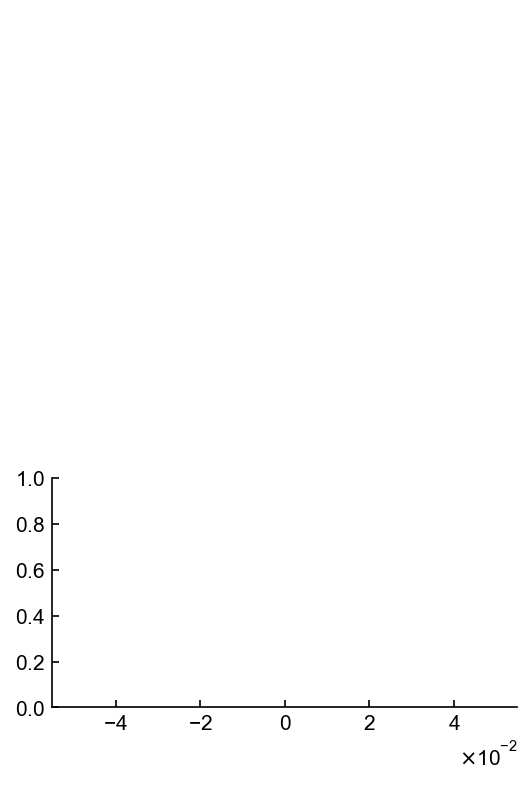

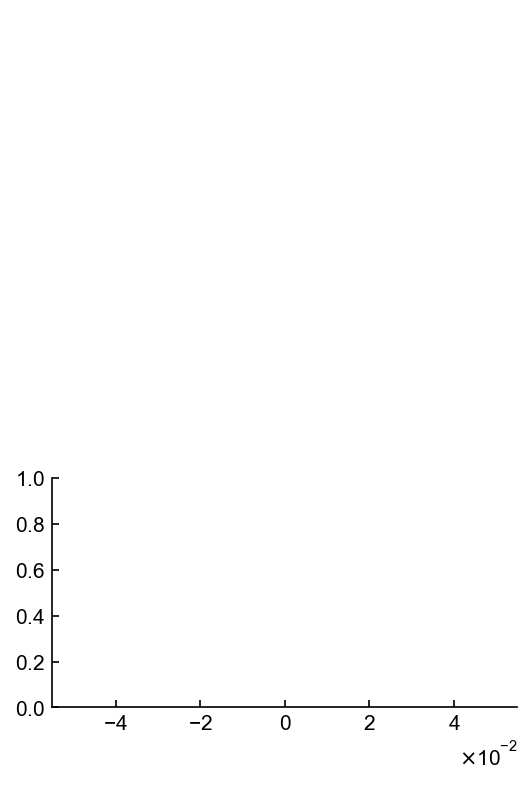

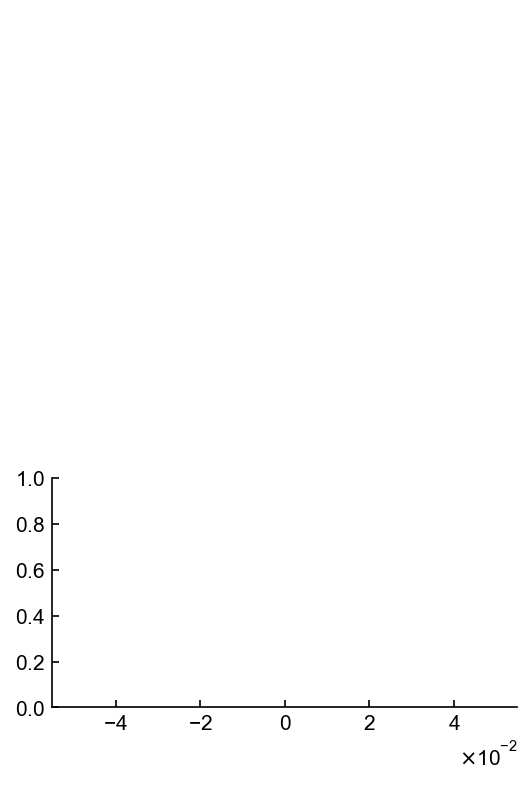

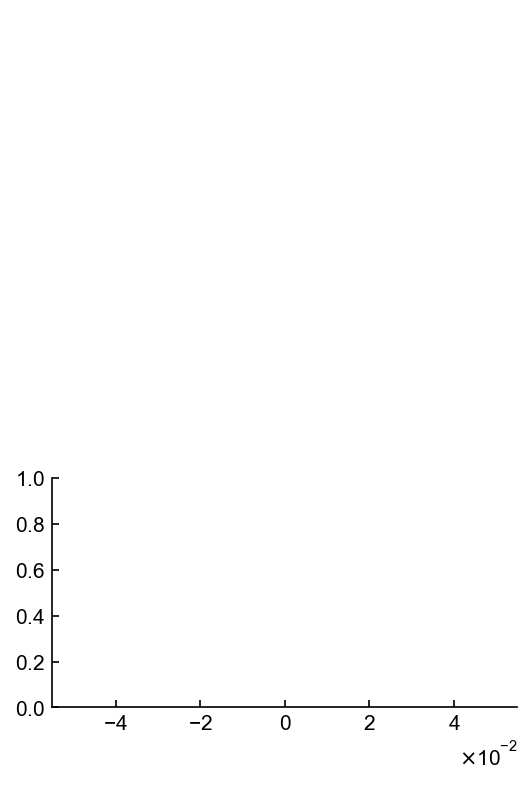

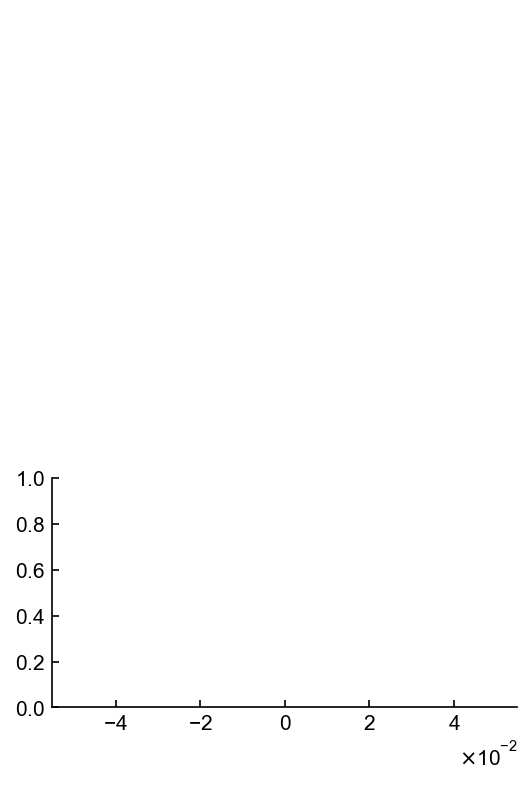

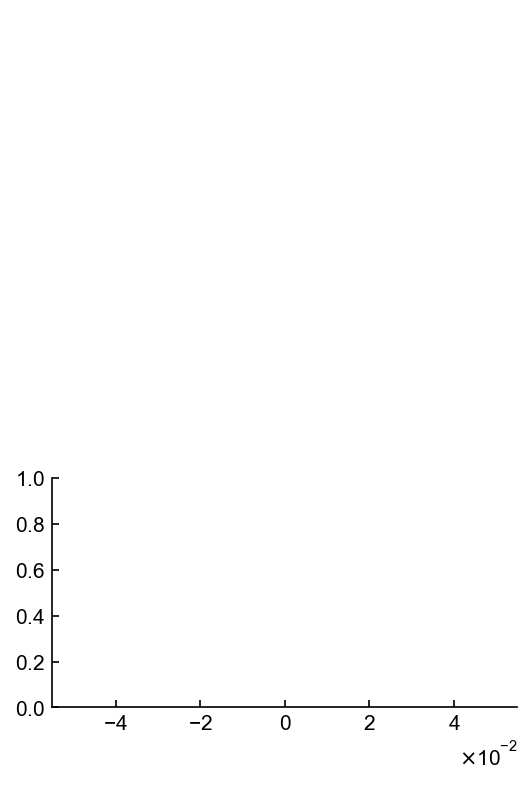

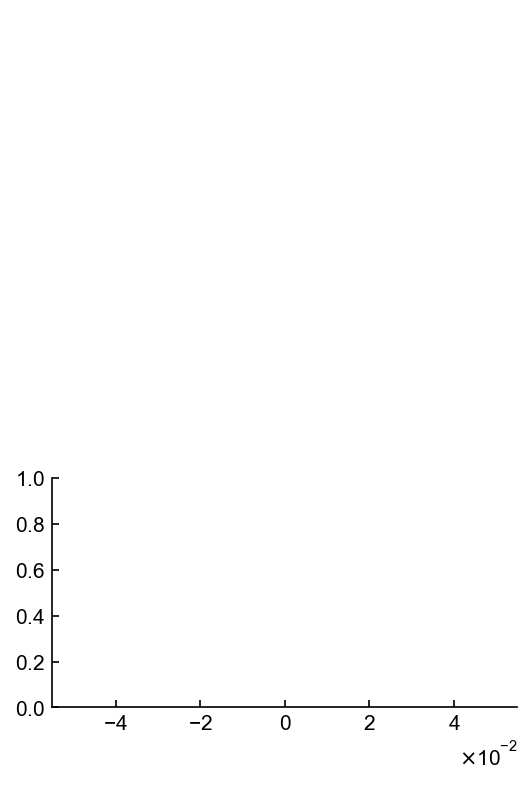

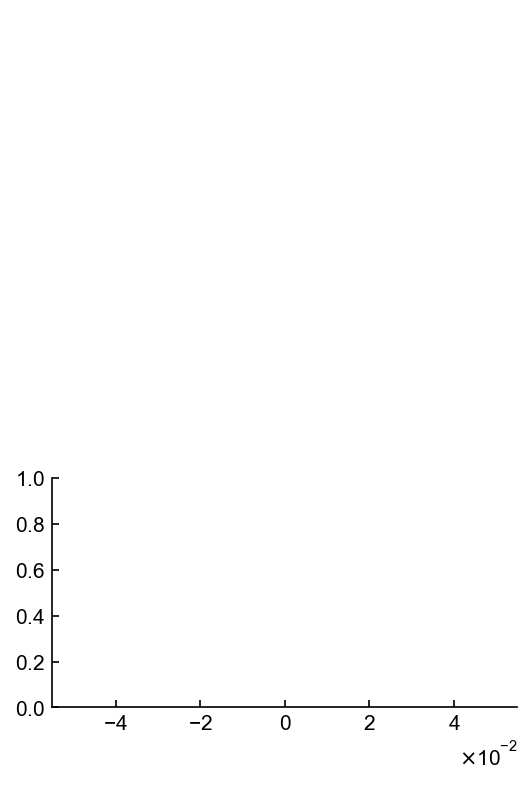

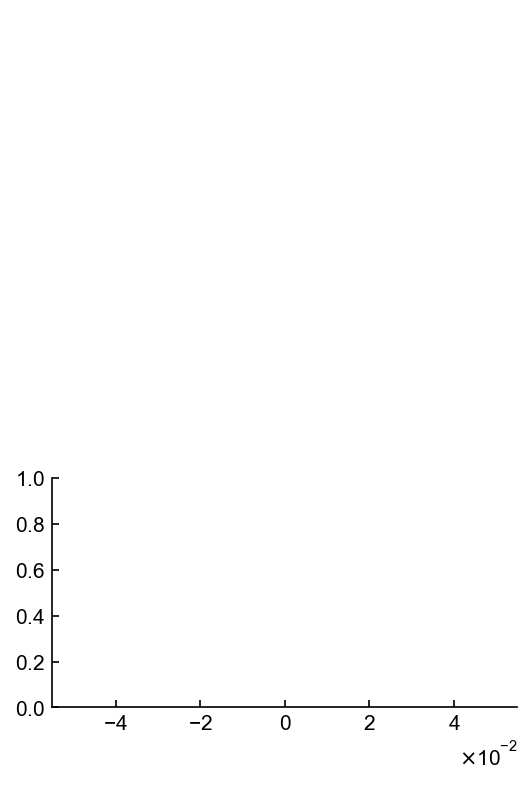

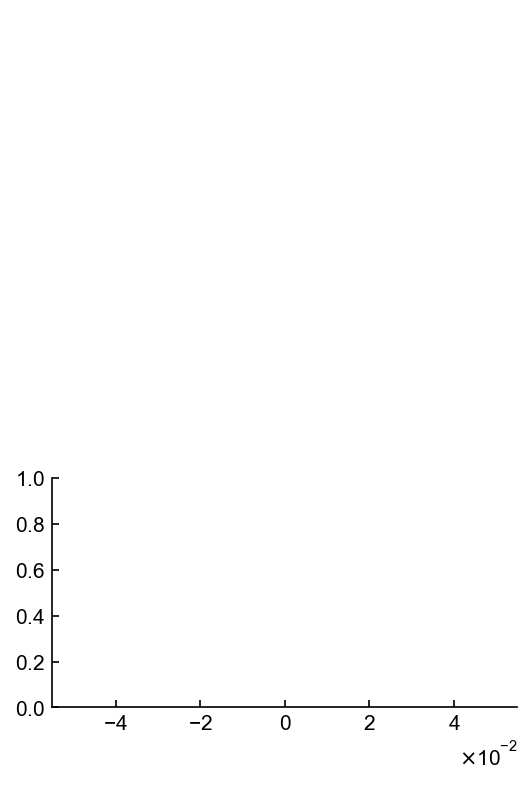

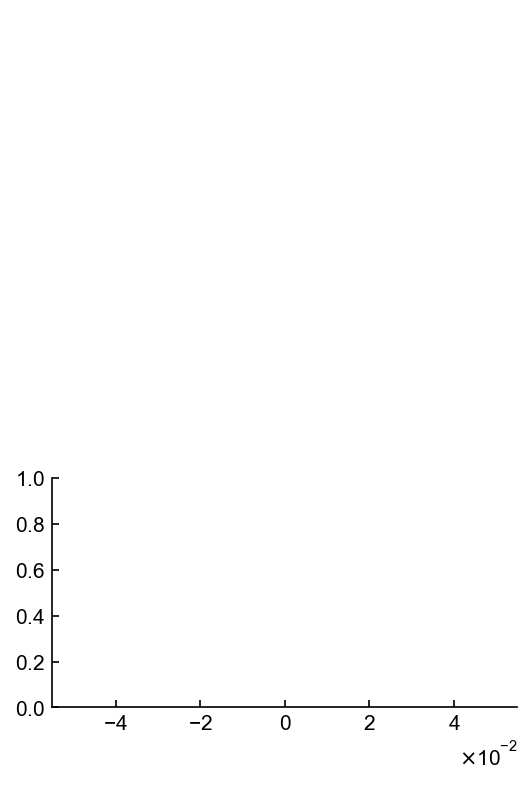

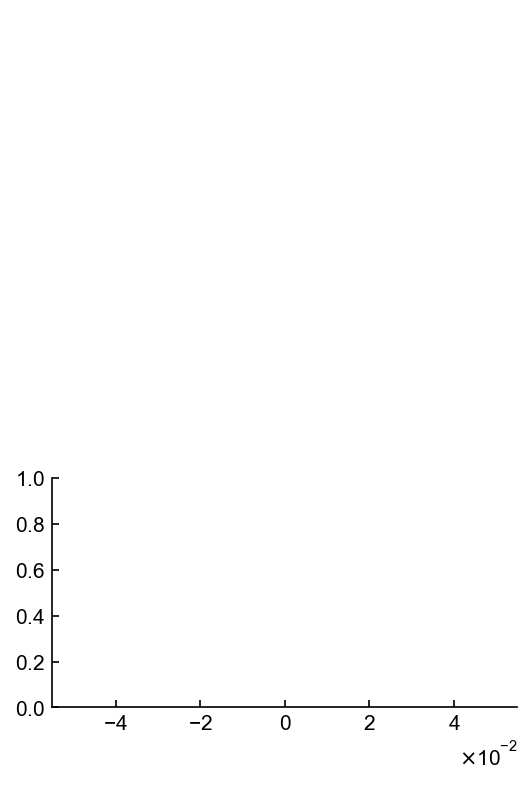

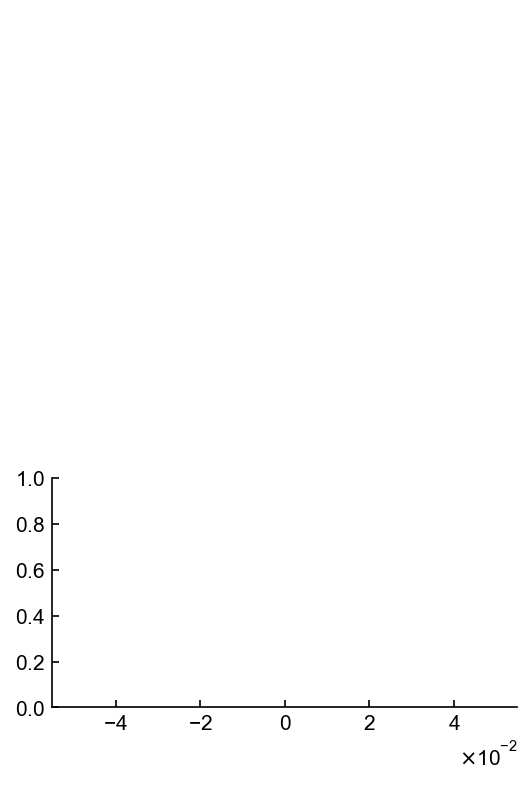

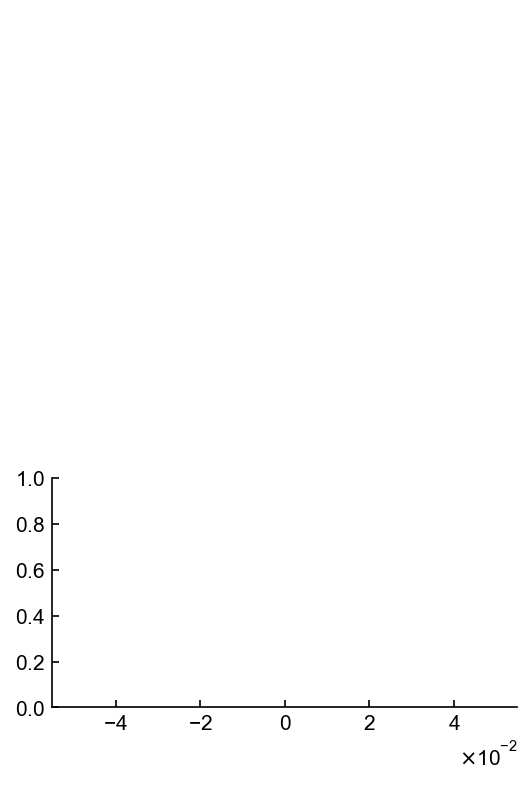

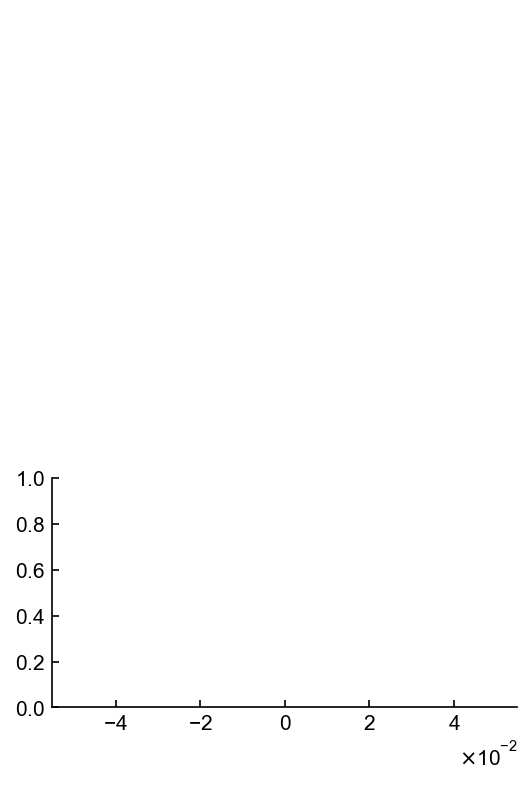

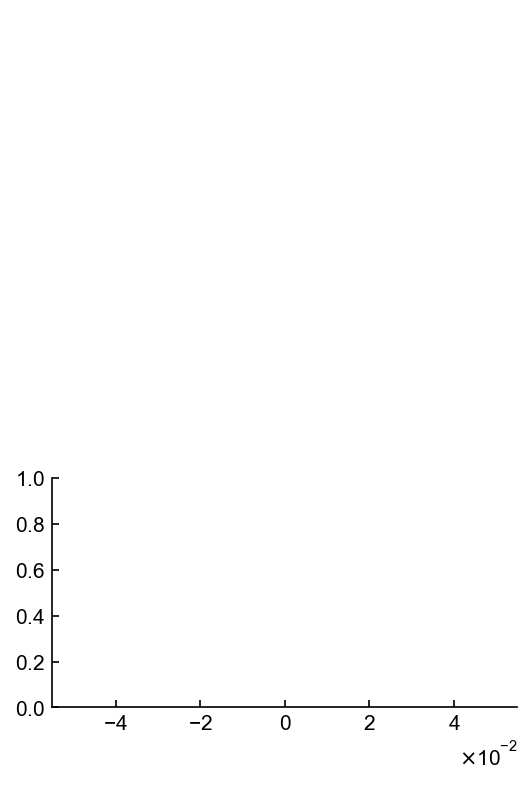

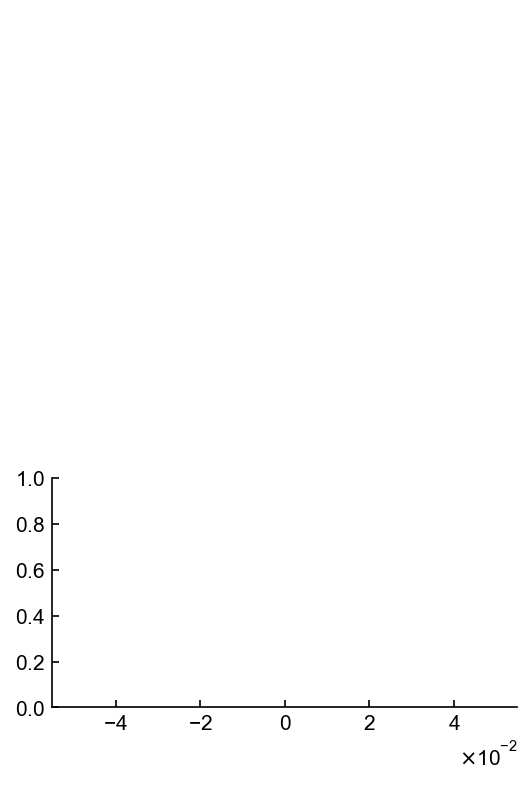

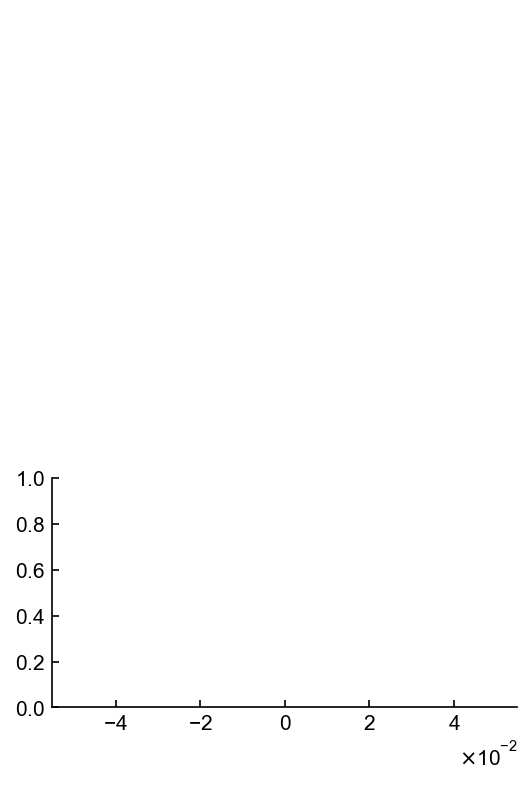

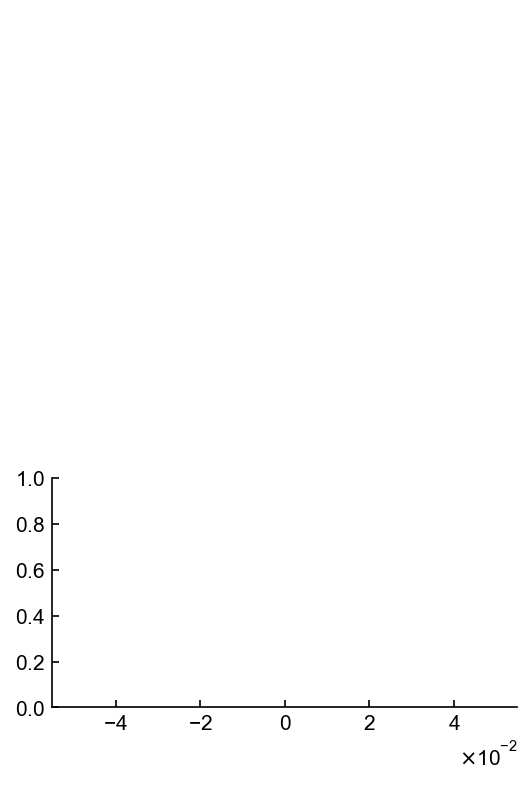

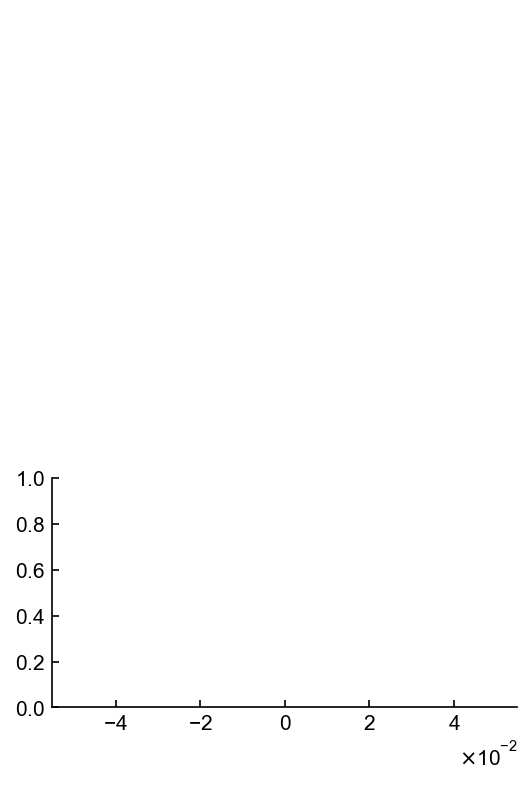

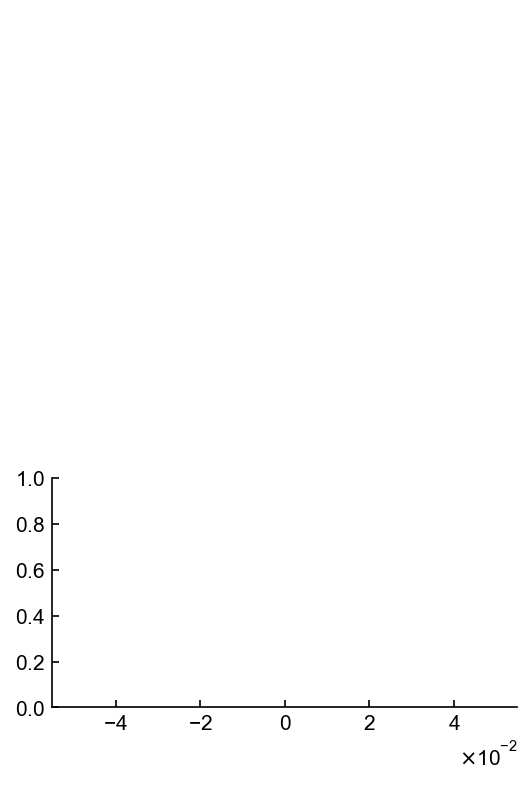

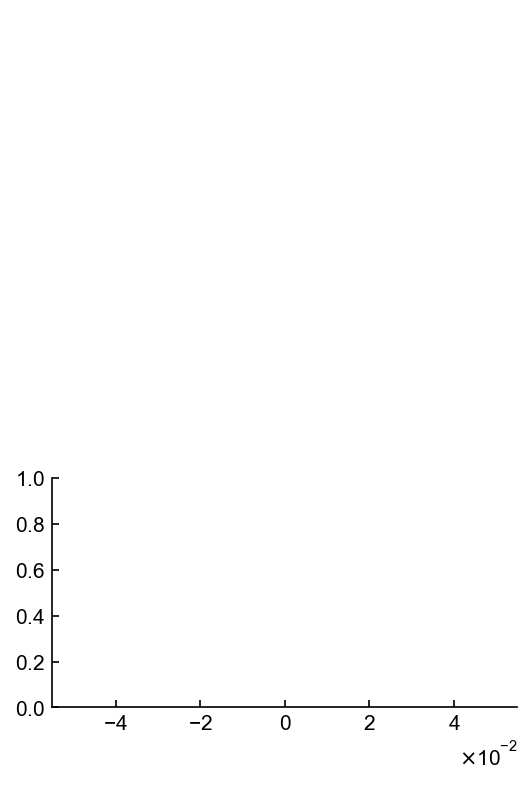

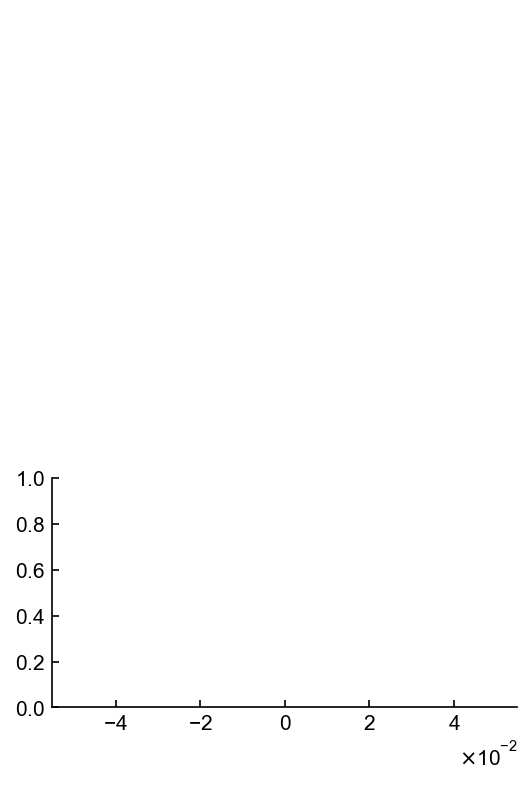

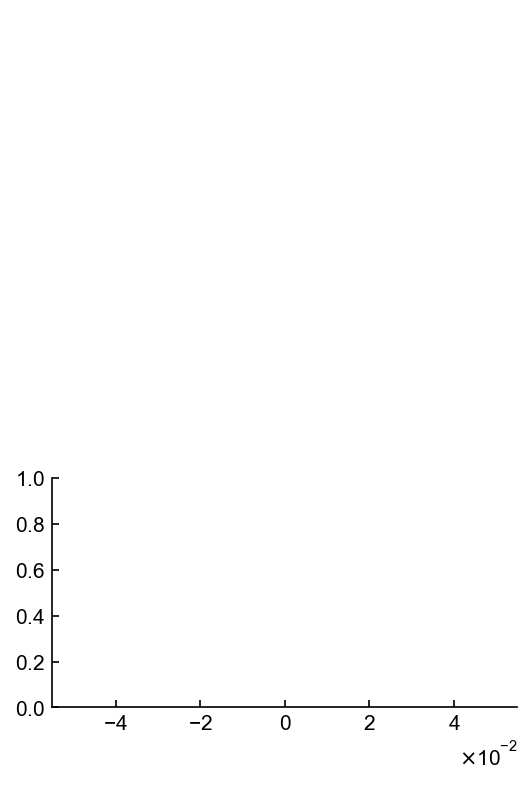

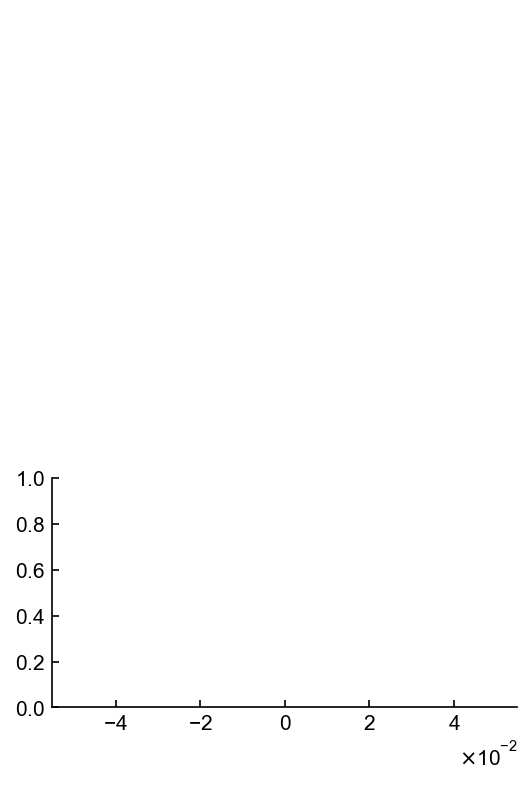

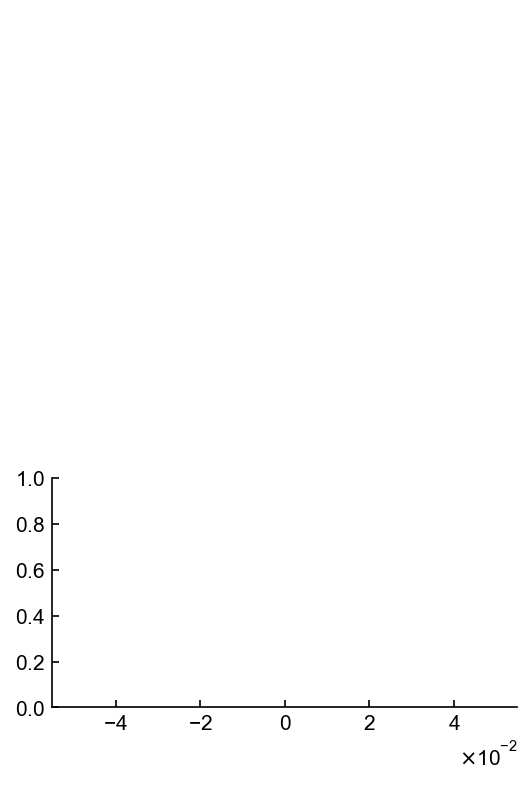

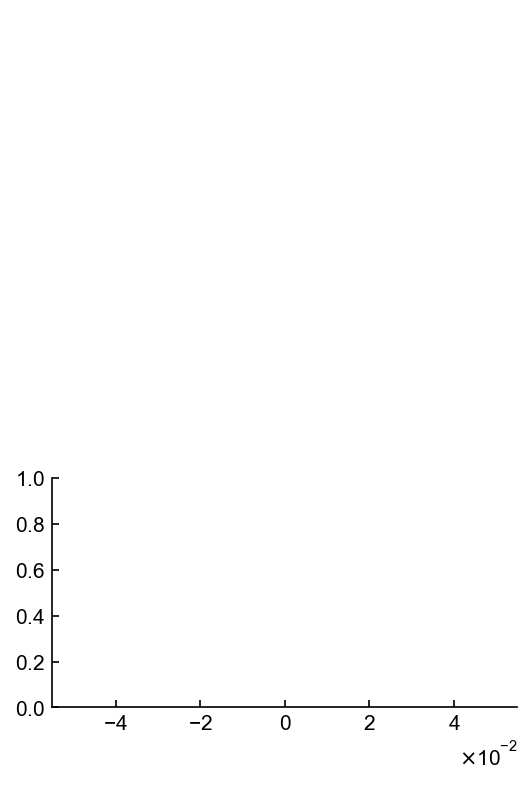

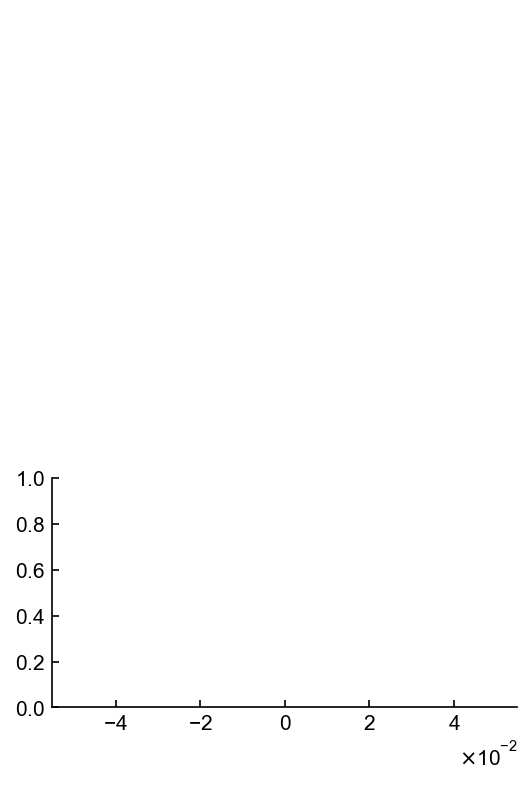

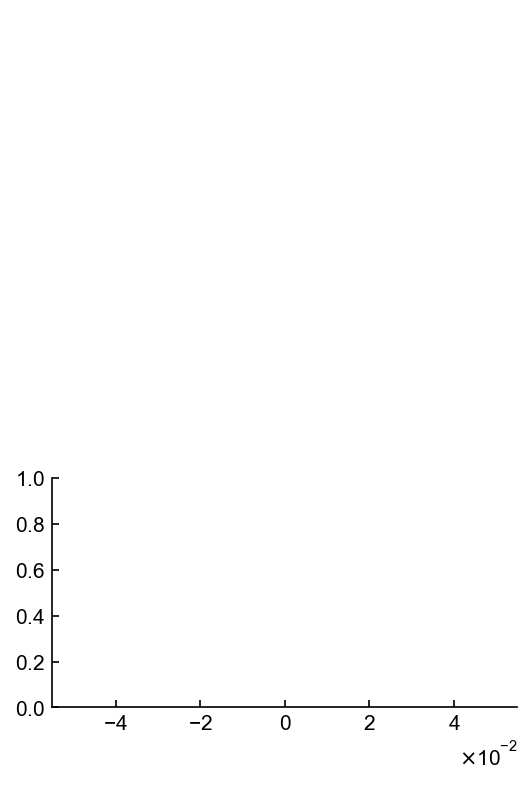

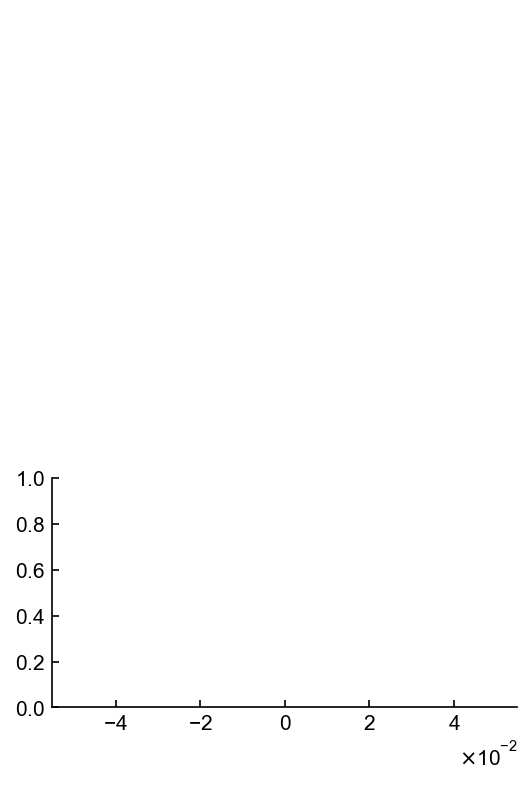

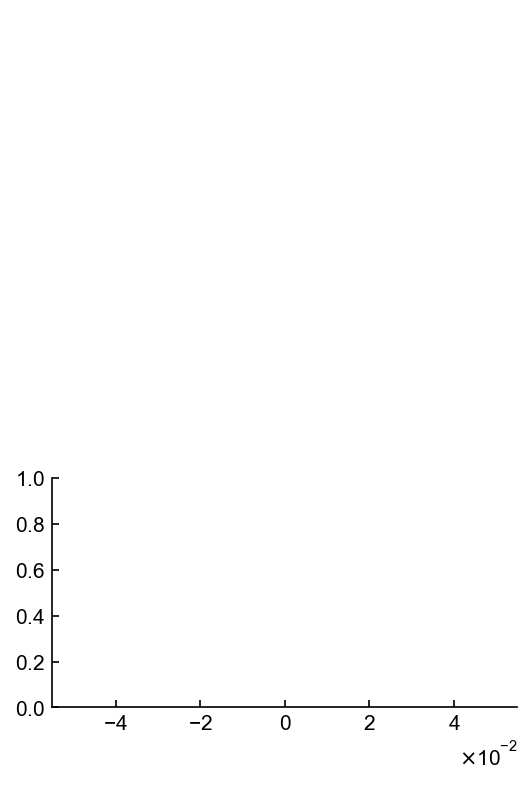

In [28]:
for session in AC_postexpert:
    session_AC = ilep.loadSessionCached(act_directory,session)
    sessionname = session
    
    clust_AC = session_AC.clusters.good
    for clust in clust_AC:
        visualizeClusterInternal(session_AC,clust,sessionname,'Postexpert')
        FRmod = visualizeClusterInternal(session_AC,clust,sessionname,'Postexpert')[-2]
        peak_time = visualizeClusterInternal(session_AC,clust,sessionname,'Postexpert')[-1]
        if FRmod>=AC_FRmod_baseline_median:
            AC_peaklatency_postexpert.append(peak_time)

In [29]:
AC_peaklatency = SimpleNamespace(prereversal_early=AC_peaklatency_preearly,
                      prereversal_late=AC_peaklatency_prelate,
                      prereversal_expert=AC_peaklatency_preexpert,
                      postreversal_early=AC_peaklatency_postearly,
                      postreversal_late=AC_peaklatency_postlate,
                      postreversal_expert=AC_peaklatency_postexpert
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\AC\\AC_peaklatency.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_peaklatency, f, protocol=pickle.HIGHEST_PROTOCOL)

### Analysis (500ms)

In [37]:
import pandas as pd
# AC_peaklatency_pickle = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\AC\\AC_peaklatency.pickle')
# M2_peaklatency_pickle = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\M2\\M2_peaklatency.pickle')

AC_peaklatency_pickle = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\AC\\AC_peaklatency500.pickle')
M2_peaklatency_pickle = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Stimulus\\M2\\M2_peaklatency500.pickle')

In [38]:
AC_peaklatency_pre_early =AC_peaklatency_pickle.prereversal_early
AC_peaklatency_pre_late = AC_peaklatency_pickle.prereversal_late
AC_peaklatency_pre_expert = AC_peaklatency_pickle.prereversal_expert

AC_peaklatency_post_early = AC_peaklatency_pickle.postreversal_early
AC_peaklatency_post_late = AC_peaklatency_pickle.postreversal_late
AC_peaklatency_post_expert = AC_peaklatency_pickle.postreversal_expert

In [39]:
M2_peaklatency_pre_early =M2_peaklatency_pickle.prereversal_early
M2_peaklatency_pre_late = M2_peaklatency_pickle.prereversal_late
M2_peaklatency_pre_expert = M2_peaklatency_pickle.prereversal_expert

M2_peaklatency_post_early = M2_peaklatency_pickle.postreversal_early
M2_peaklatency_post_late = M2_peaklatency_pickle.postreversal_late
M2_peaklatency_post_expert = M2_peaklatency_pickle.postreversal_expert

In [40]:
print(len(AC_peaklatency_pickle.prereversal_early))
print(len(AC_peaklatency_pickle.prereversal_late))
print(len(AC_peaklatency_pickle.prereversal_expert))
print(len(AC_peaklatency_pickle.postreversal_early))
print(len(AC_peaklatency_pickle.postreversal_late))
print(len(AC_peaklatency_pickle.postreversal_expert))

75
73
47
227
127
88


In [41]:
print(len(M2_peaklatency_pickle.prereversal_early))
print(len(M2_peaklatency_pickle.prereversal_late))
print(len(M2_peaklatency_pickle.prereversal_expert))
print(len(M2_peaklatency_pickle.postreversal_early))
print(len(M2_peaklatency_pickle.postreversal_late))
print(len(M2_peaklatency_pickle.postreversal_expert))

80
81
100
132
106
113


In [42]:
AC_peaklatency_pre_early = np.array(AC_peaklatency_pickle.prereversal_early)
AC_peaklatency_pre_late = np.array(AC_peaklatency_pickle.prereversal_late)
AC_peaklatency_pre_expert = np.array(AC_peaklatency_pickle.prereversal_expert)

AC_peaklatency_post_early = np.array(AC_peaklatency_pickle.postreversal_early)
AC_peaklatency_post_late = np.array(AC_peaklatency_pickle.postreversal_late)
AC_peaklatency_post_expert = np.array(AC_peaklatency_pickle.postreversal_expert)

In [43]:
M2_peaklatency_pre_early = np.array(M2_peaklatency_pickle.prereversal_early)
M2_peaklatency_pre_late = np.array(M2_peaklatency_pickle.prereversal_late)
M2_peaklatency_pre_expert = np.array(M2_peaklatency_pickle.prereversal_expert)

M2_peaklatency_post_early = np.array(M2_peaklatency_pickle.postreversal_early)
M2_peaklatency_post_late = np.array(M2_peaklatency_pickle.postreversal_late)
M2_peaklatency_post_expert = np.array(M2_peaklatency_pickle.postreversal_expert)

In [44]:
AC_peaklatency_onset_preearly = AC_peaklatency_pre_early[AC_peaklatency_pre_early<=100]
AC_peaklatency_onset_prelate = AC_peaklatency_pre_late[AC_peaklatency_pre_late<=100]
AC_peaklatency_onset_preexpert = AC_peaklatency_pre_expert[AC_peaklatency_pre_expert<=100]
AC_peaklatency_onset_postearly = AC_peaklatency_post_early[AC_peaklatency_post_early<=100]
AC_peaklatency_onset_postlate = AC_peaklatency_post_late[AC_peaklatency_post_late<=100]
AC_peaklatency_onset_postexpert = AC_peaklatency_post_expert[AC_peaklatency_post_expert<=100]

M2_peaklatency_onset_preearly = M2_peaklatency_pre_early[M2_peaklatency_pre_early<=100]
M2_peaklatency_onset_prelate = M2_peaklatency_pre_late[M2_peaklatency_pre_late<=100]
M2_peaklatency_onset_preexpert = M2_peaklatency_pre_expert[M2_peaklatency_pre_expert<=100]
M2_peaklatency_onset_postearly = M2_peaklatency_post_early[M2_peaklatency_post_early<=100]
M2_peaklatency_onset_postlate = M2_peaklatency_post_late[M2_peaklatency_post_late<=100]
M2_peaklatency_onset_postexpert = M2_peaklatency_post_expert[M2_peaklatency_post_expert<=100]

In [45]:
AC_preearly_per_onset = len(AC_peaklatency_onset_preearly)/len(AC_peaklatency_pre_early)*100
AC_prelate_per_onset = len(AC_peaklatency_onset_prelate)/len(AC_peaklatency_pre_late)*100
AC_preexpert_per_onset = len(AC_peaklatency_onset_preexpert)/len(AC_peaklatency_pre_expert)*100
AC_postearly_per_onset = len(AC_peaklatency_onset_postearly)/len(AC_peaklatency_post_early)*100
AC_postlate_per_onset = len(AC_peaklatency_onset_postlate)/len(AC_peaklatency_post_late)*100
AC_postexpert_per_onset = len(AC_peaklatency_onset_postexpert)/len(AC_peaklatency_post_expert)*100

M2_preearly_per_onset = len(M2_peaklatency_onset_preearly)/len(M2_peaklatency_pre_early)*100
M2_prelate_per_onset = len(M2_peaklatency_onset_prelate)/len(M2_peaklatency_pre_late)*100
M2_preexpert_per_onset = len(M2_peaklatency_onset_preexpert)/len(M2_peaklatency_pre_expert)*100
M2_postearly_per_onset = len(M2_peaklatency_onset_postearly)/len(M2_peaklatency_post_early)*100
M2_postlate_per_onset = len(M2_peaklatency_onset_postlate)/len(M2_peaklatency_post_late)*100
M2_postexpert_per_onset = len(M2_peaklatency_onset_postexpert)/len(M2_peaklatency_post_expert)*100

In [46]:
AC_peaklatency_offset_preearly = AC_peaklatency_pre_early[AC_peaklatency_pre_early>100]
AC_peaklatency_offset_prelate = AC_peaklatency_pre_late[AC_peaklatency_pre_late>100]
AC_peaklatency_offset_preexpert = AC_peaklatency_pre_expert[AC_peaklatency_pre_expert>100]
AC_peaklatency_offset_postearly = AC_peaklatency_post_early[AC_peaklatency_post_early>100]
AC_peaklatency_offset_postlate = AC_peaklatency_post_late[AC_peaklatency_post_late>100]
AC_peaklatency_offset_postexpert = AC_peaklatency_post_expert[AC_peaklatency_post_expert>100]

M2_peaklatency_offset_preearly = M2_peaklatency_pre_early[M2_peaklatency_pre_early>100]
M2_peaklatency_offset_prelate = M2_peaklatency_pre_late[M2_peaklatency_pre_late>100]
M2_peaklatency_offset_preexpert = M2_peaklatency_pre_expert[M2_peaklatency_pre_expert>100]
M2_peaklatency_offset_postearly = M2_peaklatency_post_early[M2_peaklatency_post_early>100]
M2_peaklatency_offset_postlate = M2_peaklatency_post_late[M2_peaklatency_post_late>100]
M2_peaklatency_offset_postexpert = M2_peaklatency_post_expert[M2_peaklatency_post_expert>100]

In [47]:
print(np.max(AC_peaklatency_pre_early))
print(np.max(AC_peaklatency_pre_late))
print(np.max(AC_peaklatency_pre_expert))
print(np.max(AC_peaklatency_post_early))
print(np.max(AC_peaklatency_post_late))
print(np.max(AC_peaklatency_post_expert))

266
499
499
499
402
499


In [48]:
print(np.max(M2_peaklatency_pre_early))
print(np.max(M2_peaklatency_pre_late))
print(np.max(M2_peaklatency_pre_expert))
print(np.max(M2_peaklatency_post_early))
print(np.max(M2_peaklatency_post_late))
print(np.max(M2_peaklatency_post_expert))

474
460
499
499
499
484


In [49]:
#

In [50]:
AC_peaklatency_preearly = np.concatenate((AC_peaklatency_offset_preearly-100,AC_peaklatency_onset_preearly))
AC_peaklatency_prelate = np.concatenate((AC_peaklatency_offset_prelate-100,AC_peaklatency_onset_prelate))
AC_peaklatency_preexpert = np.concatenate((AC_peaklatency_offset_preexpert-100,AC_peaklatency_onset_preexpert))
AC_peaklatency_postearly = np.concatenate((AC_peaklatency_offset_postearly-100,AC_peaklatency_onset_postearly))
AC_peaklatency_postlate = np.concatenate((AC_peaklatency_offset_postlate-100,AC_peaklatency_onset_postlate))
AC_peaklatency_postexpert = np.concatenate((AC_peaklatency_offset_postexpert-100,AC_peaklatency_onset_postexpert))

In [51]:
M2_peaklatency_preearly = np.concatenate((M2_peaklatency_offset_preearly-100,M2_peaklatency_onset_preearly))
M2_peaklatency_prelate = np.concatenate((M2_peaklatency_offset_prelate-100,M2_peaklatency_onset_prelate))
M2_peaklatency_preexpert = np.concatenate((M2_peaklatency_offset_preexpert-100,M2_peaklatency_onset_preexpert))
M2_peaklatency_postearly = np.concatenate((M2_peaklatency_offset_postearly-100,M2_peaklatency_onset_postearly))
M2_peaklatency_postlate = np.concatenate((M2_peaklatency_offset_postlate-100,M2_peaklatency_onset_postlate))
M2_peaklatency_postexpert = np.concatenate((M2_peaklatency_offset_postexpert-100,M2_peaklatency_onset_postexpert))

### Distribution (500ms)

In [148]:
M2_peaklatency_pre_early

array([156, 102, 107, 105, 228, 119, 144, 130, 110, 153, 130, 139,  33,
       155, 122,  29,  77, 132, 364, 103, 121,  63, 330, 390, 110,  55,
       135, 194, 142, 203, 391,  49, 110, 452, 231, 120,  81,  93, 202,
       171, 358,  46, 474, 197, 193, 283, 153,  80, 115, 141, 140, 100,
       153,  20, 127,  94, 102, 108, 219, 223, 137,  94, 101, 408, 169,
       228, 140, 255, 165,  86, 143, 127, 191, 423, 119, 111, 122, 134,
       128, 124], dtype=int64)

In [149]:
M2_peaklatency_pre_late

array([237, 460, 234, 186, 236, 206, 183, 287, 208, 211, 268, 309, 246,
       297, 197, 159, 209, 139, 224, 227, 201, 203, 202, 112, 112, 131,
       152, 142, 153, 141, 174,  86, 124, 132, 126, 131, 116, 142, 105,
       141, 139, 230, 123, 235, 215, 189, 128, 205, 141, 140, 111, 103,
       134, 111, 178, 153, 237,  82,  99, 180, 394, 127, 272, 160, 256,
       115, 264, 190, 256, 144, 276, 161, 167, 202, 314, 232, 132, 427,
       444, 137, 317], dtype=int64)

In [150]:
M2_peaklatency_pre_expert

array([217, 463, 146, 103, 107, 125, 188,  94,  17, 268, 129, 105,  36,
       379,  38, 120, 264, 127, 164, 150, 228, 189, 151, 361, 499, 152,
       125, 211, 156, 258, 275, 238, 396, 270, 220, 185, 161, 174, 399,
       238, 225, 307, 145, 378, 219, 171, 499, 207, 175, 172, 132, 203,
       380, 101, 161, 304, 164, 128, 185, 284, 159, 207, 169, 195,  50,
       192, 238, 205, 175, 273, 195, 220, 492, 202, 251, 261, 499, 157,
       151, 139, 149, 499,  98, 161, 327, 168, 152,  48,  32,  10, 178,
        80, 156, 374, 405, 316, 155, 169, 172, 199], dtype=int64)

In [151]:
M2_peaklatency_post_early

array([121,  78,  98, 136, 139, 162, 281, 111, 434, 158, 185, 151, 122,
       126, 150, 211, 204, 183, 132, 217, 137, 123, 156, 143, 103, 224,
        99, 165, 153, 112, 185, 175, 186, 161, 229, 474, 208, 195, 221,
       234, 151, 228, 145, 187, 246, 249, 190, 231, 293, 319, 250, 101,
       152, 213, 161, 173, 195, 155, 499, 197, 188, 244, 233, 199, 399,
       229, 145, 129, 165, 244, 286, 216, 176, 187, 379, 119, 256, 118,
       225, 179, 222, 285, 204, 165, 144, 162, 162, 184, 194, 283, 165,
       381, 147, 133, 102, 186, 171, 155, 185, 164, 180, 182, 127,  26,
       250, 181, 241, 250, 397, 168, 148, 146,  92, 134,  91, 170, 139,
       199, 110, 115, 102, 400, 171, 104, 121, 100, 106, 184, 221, 193,
       499, 174], dtype=int64)

In [152]:
M2_peaklatency_post_late

array([244, 191, 196, 172, 230, 212, 164, 191, 206, 179, 200, 206, 117,
       183, 157, 199,  74, 140, 135, 270, 127, 111, 151, 179, 123, 171,
       147, 113, 109, 159, 120, 104, 492, 169, 185, 181, 137, 499, 166,
       273, 172, 179, 163, 167, 152, 215, 163, 265,  26, 161, 134, 136,
       198, 124, 126, 138, 114, 150, 456, 144, 215, 150, 303, 149, 119,
       235, 115, 112, 136, 213, 161,  82, 150,  94,  91, 179, 229, 180,
       127, 465, 146, 174, 441, 217, 336, 125, 180, 427, 408, 170, 297,
       367, 357, 174, 205, 110, 139, 138, 170, 160, 178, 154, 236, 143,
       197, 214], dtype=int64)

In [153]:
M2_peaklatency_post_expert

array([172, 102, 121, 161, 159, 186,  93, 102, 267, 241, 168, 140, 168,
       204, 153, 138, 119, 110, 127, 106, 119, 125, 143, 162, 159, 208,
       140, 157, 183, 132, 204, 125, 124, 121, 155, 162, 133, 184, 165,
       151, 125, 128, 134, 173, 150, 159, 199, 156, 136, 190, 130, 135,
       149, 137, 177, 205, 197, 212, 133, 116, 163, 151, 204, 160, 145,
       145, 137, 170, 159, 170, 135, 101, 292, 109, 115,  87, 119, 150,
       143, 121,  74, 120, 142,  71, 162, 165, 363, 246, 195, 132,  89,
       193, 123, 212, 125, 179, 219, 108, 363,  56,  76, 124, 110, 168,
        77,  99, 101, 277, 195, 484, 164, 275, 154], dtype=int64)

meta NOT subset; don't know how to subset; dropped


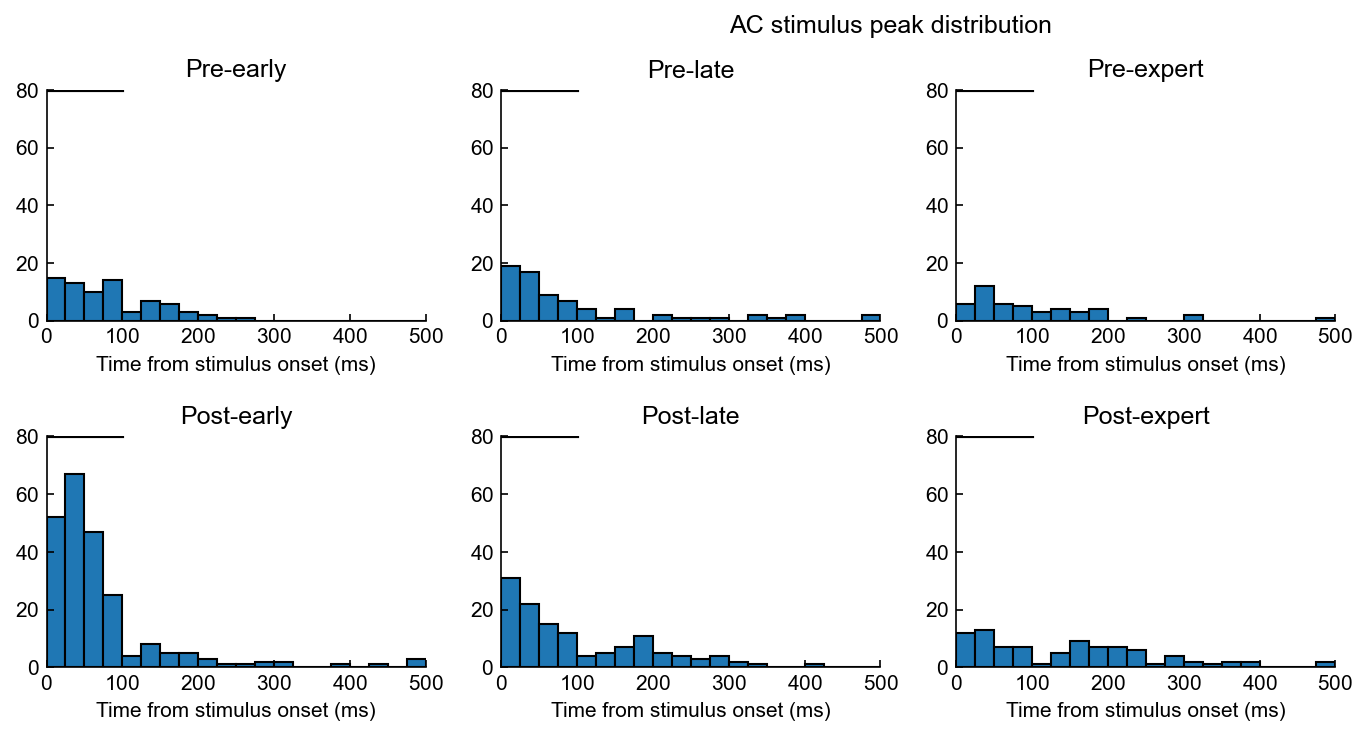

In [55]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)

num_bins = 20

ax1.set_ylim(0,80)
ax1.set_xlim(0,500)
ax1.set_xticks([0,100,200,300,400,500])

ax1.set_xlabel('Time from stimulus onset (ms)')
ax2.set_xlabel('Time from stimulus onset (ms)')
ax3.set_xlabel('Time from stimulus onset (ms)')
ax4.set_xlabel('Time from stimulus onset (ms)')
ax5.set_xlabel('Time from stimulus onset (ms)')
ax6.set_xlabel('Time from stimulus onset (ms)')

ax1.hist(AC_peaklatency_pre_early,bins=num_bins,range=(0,500),edgecolor='k')
ax2.hist(AC_peaklatency_pre_late,bins=num_bins,range=(0,500),edgecolor='k')
ax3.hist(AC_peaklatency_pre_expert,bins=num_bins,range=(0,500),edgecolor='k')
ax4.hist(AC_peaklatency_post_early,bins=num_bins,range=(0,500),edgecolor='k')
ax5.hist(AC_peaklatency_post_late,bins=num_bins,range=(0,500),edgecolor='k')
ax6.hist(AC_peaklatency_post_expert,bins=num_bins,range=(0,500),edgecolor='k')

ax1.set_title('Pre-early')
ax2.set_title('Pre-late')
ax3.set_title('Pre-expert')
ax4.set_title('Post-early')
ax5.set_title('Post-late')
ax6.set_title('Post-expert')
plt.suptitle('AC stimulus peak distribution')

ax1.plot([0,100],[80,80],color='k',lw=2,linestyle='-')
ax2.plot([0,100],[80,80],color='k',lw=2,linestyle='-')
ax3.plot([0,100],[80,80],color='k',lw=2,linestyle='-')
ax4.plot([0,100],[80,80],color='k',lw=2,linestyle='-')
ax5.plot([0,100],[80,80],color='k',lw=2,linestyle='-')
ax6.plot([0,100],[80,80],color='k',lw=2,linestyle='-')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Analysis\\AC stimulus latency distribution.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


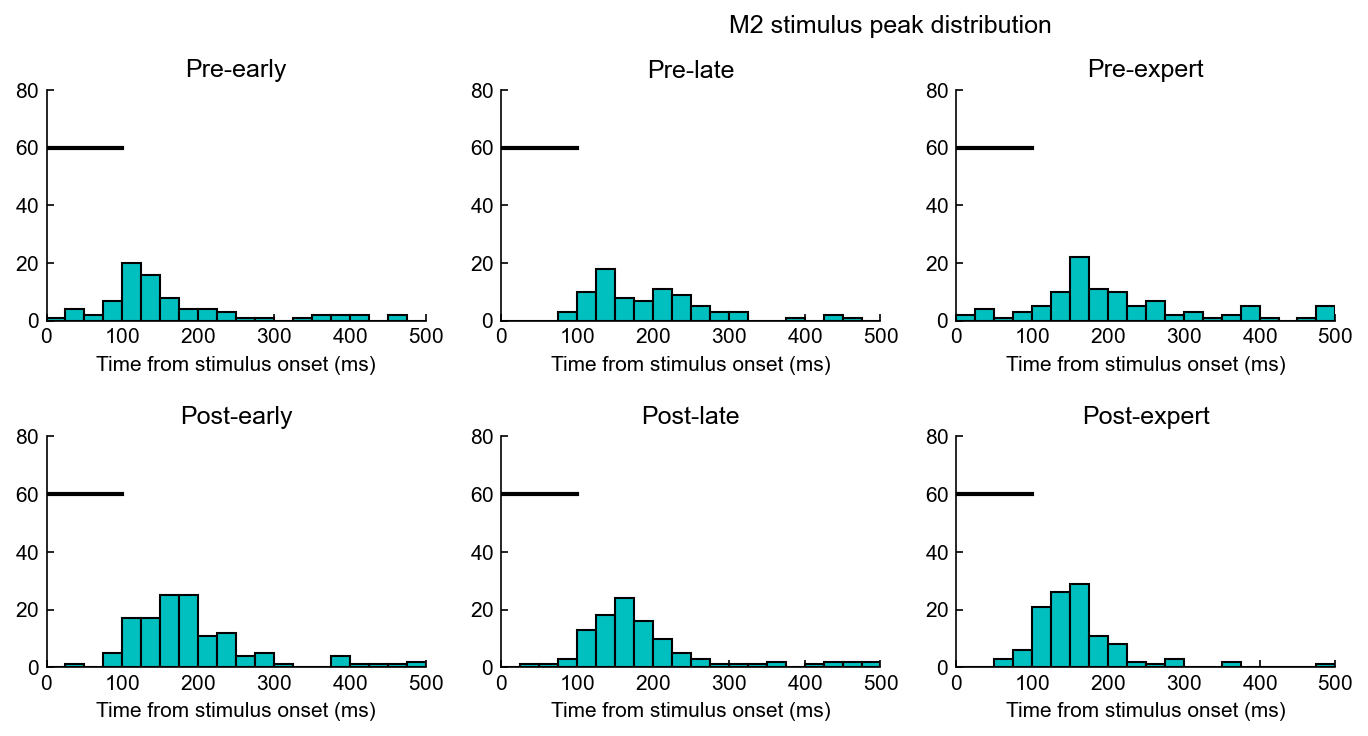

In [56]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)

num_bins = 20

ax1.set_ylim(0,80)
ax1.set_xlim(0,500)
ax1.set_xticks([0,100,200,300,400,500])

ax1.set_xlabel('Time from stimulus onset (ms)')
ax2.set_xlabel('Time from stimulus onset (ms)')
ax3.set_xlabel('Time from stimulus onset (ms)')
ax4.set_xlabel('Time from stimulus onset (ms)')
ax5.set_xlabel('Time from stimulus onset (ms)')
ax6.set_xlabel('Time from stimulus onset (ms)')

ax1.hist(M2_peaklatency_pre_early,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')
ax2.hist(M2_peaklatency_pre_late,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')
ax3.hist(M2_peaklatency_pre_expert,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')
ax4.hist(M2_peaklatency_post_early,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')
ax5.hist(M2_peaklatency_post_late,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')
ax6.hist(M2_peaklatency_post_expert,bins=num_bins,range=(0,500),edgecolor='k',color = 'c')


ax1.set_title('Pre-early')
ax2.set_title('Pre-late')
ax3.set_title('Pre-expert')
ax4.set_title('Post-early')
ax5.set_title('Post-late')
ax6.set_title('Post-expert')
plt.suptitle('M2 stimulus peak distribution')

ax1.plot([0,100],[60,60],color='k',lw=2,linestyle='-')
ax2.plot([0,100],[60,60],color='k',lw=2,linestyle='-')
ax3.plot([0,100],[60,60],color='k',lw=2,linestyle='-')
ax4.plot([0,100],[60,60],color='k',lw=2,linestyle='-')
ax5.plot([0,100],[60,60],color='k',lw=2,linestyle='-')
ax6.plot([0,100],[60,60],color='k',lw=2,linestyle='-')

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Analysis\\M2 stimulus latency distribution.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


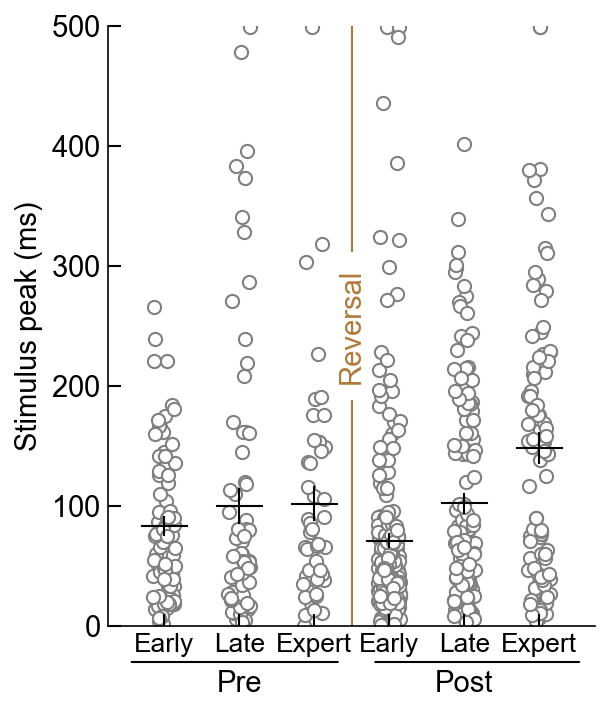

In [53]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
width = 0.3
################################################################################################################

#Plot figure 
data = [AC_peaklatency_pre_early,AC_peaklatency_pre_late,AC_peaklatency_pre_expert,AC_peaklatency_post_early,AC_peaklatency_post_late,AC_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,500])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus peak (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Analysis\\AC stimulus latency (not - 100).pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


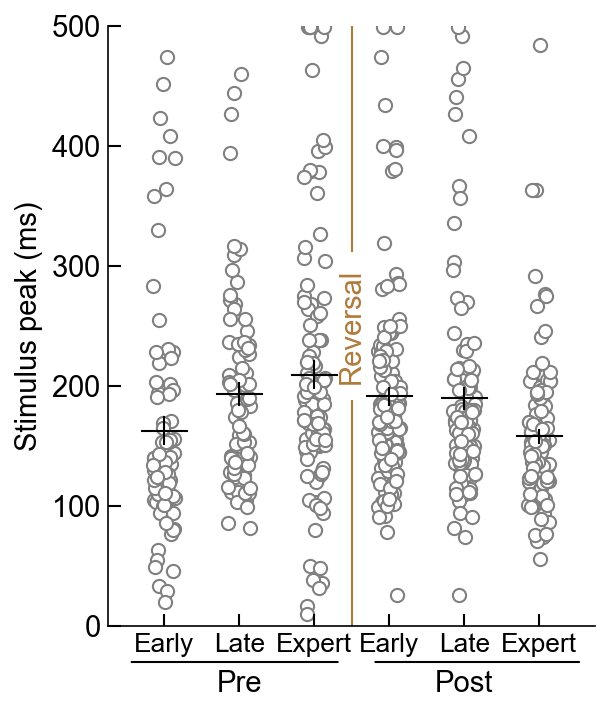

In [54]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_pre_early,M2_peaklatency_pre_late,M2_peaklatency_pre_expert,M2_peaklatency_post_early,M2_peaklatency_post_late,M2_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,500])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus peak (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency_500\\Analysis\\M2 stimulus latency (not - 100).pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [158]:
ACData = SimpleNamespace()
ACData.preearly = AC_peaklatency_pre_early
ACData.prelate = AC_peaklatency_pre_late
ACData.preexpert = AC_peaklatency_pre_expert
ACData.postearly = AC_peaklatency_post_early
ACData.postlate = AC_peaklatency_post_late
ACData.postexpert = AC_peaklatency_post_expert
ilep.nonparametricIndependentStatsCompareToPrevious(ACData)

            Source            SS     DF             MS          F     p-unc  \
0            phase  1.982191e+05    3.0   66073.020719   7.263589  0.000082   
1          context  1.573484e+05    1.0  157348.407794  17.297744  0.000035   
2  phase * context  4.210428e+04    3.0   14034.761448   1.542880  0.201957   
3         Residual  7.540974e+06  829.0    9096.470132        NaN       NaN   

        np2  
0  0.025612  
1  0.020439  
2  0.005552  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.004243  0.008485 -0.447456
8     post-late  baseline  experimental  0.003777  0.008485 -0.362012
9    pre-expert  baseline  experimental  0.202563  0.270084 -0.014562
10     pre-late  baseline  experimental  0.431689  0.431689 -0.177978
key preearly has 75 non-nan elements
key prelate has 73 non-nan elements
key preexpert has 47 non-nan elements
key postearly has 227 non-nan elements
key postlate has 127 non-nan elem

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  46177.5   two-sided  0.000019  0.000116   fdr_bh  0.411858  
1        False  14638.5   two-sided  0.040862  0.081725   fdr_bh  0.191164  
2        False  18489.0   two-sided  0.008674  0.026021   fdr_bh  0.293108  
3        False  19547.0   two-sided  0.191799  0.287698   fdr_bh -0.197648  
4        False  24557.0   two-sided  0.268852  0.322623   fdr_bh -0.103630  
5        False   9049.0   two-sided  0.789416  0.789416   fdr_bh  0.090367  
6        False  71521.5   two-sided  0.000246       NaN      NaN -0.297731  
7        False   4305.0   two-sided  0.004243  0.008485   fdr_bh -0.447456  
8        False  11739.5   two-sided  0.003777  0.008485   fdr_bh -0.362012  
9        False   1478.0   two-sided  0.202563  0.270084   fdr_bh -0.014562  
10       False   2943.0   two-sided  0.431689  0.431689   fdr_bh -0.177978

In [159]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(ACData)

            Source            SS     DF             MS          F  \
0            phase  3.154921e+04    3.0   10516.404015   1.338686   
1          context  3.496721e+05    1.0  349672.100075  44.511511   
2  phase * context  1.268641e+05    3.0   42288.035440   5.383056   
3         Residual  7.313720e+06  931.0    7855.767972        NaN   

          p-unc       np2  
0  2.604326e-01  0.004295  
1  4.333912e-11  0.045629  
2  1.123707e-03  0.017050  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  9.381672e-09  3.752669e-08 -0.824631
8     post-late  baseline  experimental  3.776930e-03  7.553859e-03 -0.362012
9    pre-expert  baseline  experimental  4.726483e-01  4.726483e-01 -0.240506
10     pre-late  baseline  experimental  4.316888e-01  4.726483e-01 -0.177978
key preearly has 75 non-nan elements
key prelate has 73 non-nan elements
key preexpert has 47 non-nan elements
key postearl

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative         p-unc        p-corr p-adjust  \
0        False  58527.5   two-sided  2.665671e-01  4.032785e-01   fdr_bh   
1        False  17696.5   two-sided  1.999224e-01  4.032785e-01   fdr_bh   
2        False  23044.0   two-sided  8.432361e-01  8.432361e-01   fdr_bh   
3        False  18725.0   two-sided  2.856756e-02  1.714053e-01   fdr_bh   
4        False  24557.0   two-sided  2.688524e-01  4.032785e-01   fdr_bh   
5        False   9608.0   two-sided  3.641012e-01  4.369214e-01   fdr_bh   
6        False  81115.0   two-sided  4.715847e-07           NaN      NaN   
7        False   5823.5   two-sided  9.381672e-09  3.752669e-08   fdr_bh   
8        False  11739.5   two-sided  3.776930e-03  7.553859e-03   fdr_bh   
9        False   1625.5   two-sided  4.726483e-01  4.726483e-01   fdr_bh   
10       False   2943.0   two-sided  4.316888e-01  4.726483e-01   fdr_bh   

      hedges  
0   0.111313  
1   0.024652  
2   0.011327  
3  -0.095252  
4  -0.103630  
5  -0.013820  
6  -0.443786  
7  -0.824631  
8  -0.362012  
9  -0.240506  
10 -0.177978

In [57]:
M2Data = SimpleNamespace()
M2Data.preearly = M2_peaklatency_pre_early
M2Data.prelate = M2_peaklatency_pre_late
M2Data.preexpert = M2_peaklatency_pre_expert
M2Data.postearly = M2_peaklatency_post_early
M2Data.postlate = M2_peaklatency_post_late
M2Data.postexpert = M2_peaklatency_post_expert
ilep.nonparametricIndependentStatsCompareToPrevious(M2Data)

            Source            SS     DF            MS         F     p-unc  \
0            phase  9.768873e+04    3.0  32562.910652  4.260333  0.005365   
1          context  8.069842e+01    1.0     80.698423  0.010558  0.918185   
2  phase * context  1.056346e+05    3.0  35211.525707  4.606862  0.003328   
3         Residual  6.045833e+06  791.0   7643.277704       NaN       NaN   

        np2  
0  0.015901  
1  0.000013  
2  0.017172  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.001725  0.003450  0.417757
8     post-late  baseline  experimental  0.457726  0.457726  0.015490
9    pre-expert  baseline  experimental  0.386523  0.457726 -0.161483
10     pre-late  baseline  experimental  0.000332  0.001327 -0.340477
key preearly has 80 non-nan elements
key prelate has 81 non-nan elements
key preexpert has 100 non-nan elements
key postearly has 132 non-nan elements
key postlate has 106 non-nan elements
key 

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  22035.5   two-sided  0.004319  0.008639   fdr_bh -0.209613  
1        False  15709.0   two-sided  0.000355  0.002132   fdr_bh -0.327779  
2        False  17956.0   two-sided  0.757988  0.757988   fdr_bh -0.056274  
3        False  19945.5   two-sided  0.194503  0.233403   fdr_bh -0.126359  
4        False  21769.0   two-sided  0.020943  0.031414   fdr_bh  0.142066  
5        False  17319.5   two-sided  0.002598  0.007795   fdr_bh  0.253074  
6        False  79156.5   two-sided  0.843726       NaN      NaN -0.009742  
7        False   7458.0   two-sided  0.001725  0.003450   fdr_bh  0.417757  
8        False   7388.5   two-sided  0.457726  0.457726   fdr_bh  0.015490  
9        False   3746.0   two-sided  0.386523  0.457726   fdr_bh -0.161483  
10       False   2178.0   two-sided  0.000332  0.001327   fdr_bh -0.340477

In [162]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(M2Data)

            Source            SS     DF            MS         F     p-unc  \
0            phase  3.552779e+04    3.0  11842.595165  1.520053  0.207852   
1          context  7.173744e+03    1.0   7173.743563  0.920784  0.337553   
2  phase * context  1.960532e+05    3.0  65351.081546  8.388119  0.000017   
3         Residual  6.357383e+06  816.0   7790.909936       NaN       NaN   

        np2  
0  0.005557  
1  0.001127  
2  0.029916  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000091  0.000183  0.453481
8     post-late  baseline  experimental  0.457726  0.457726  0.015490
9    pre-expert  baseline  experimental  0.000069  0.000183 -0.438204
10     pre-late  baseline  experimental  0.000332  0.000442 -0.340477
key preearly has 80 non-nan elements
key prelate has 81 non-nan elements
key preexpert has 100 non-nan elements
key postearly has 132 non-nan elements
key postlate has 106 non-nan elements
key 

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  25914.5   two-sided  0.034618  0.103853   fdr_bh -0.183081  
1        False  21848.5   two-sided  0.872370  0.872370   fdr_bh -0.140236  
2        False  20610.0   two-sided  0.443144  0.590353   fdr_bh -0.027413  
3        False  23146.5   two-sided  0.158164  0.316329   fdr_bh  0.021053  
4        False  21769.0   two-sided  0.020943  0.103853   fdr_bh  0.142066  
5        False  15115.0   two-sided  0.491961  0.590353   fdr_bh  0.104076  
6        False  80014.0   two-sided  0.161068       NaN      NaN -0.067075  
7        False   9622.0   two-sided  0.000091  0.000183   fdr_bh  0.453481  
8        False   7388.5   two-sided  0.457726  0.457726   fdr_bh  0.015490  
9        False   2617.0   two-sided  0.000069  0.000183   fdr_bh -0.438204  
10       False   2178.0   two-sided  0.000332  0.000442   fdr_bh -0.340477

In [163]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

### AC analysis (200ms)

In [35]:
import pandas as pd
AC_peaklatency_pickle200 = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\AC\\AC_peaklatency200.pickle')

In [17]:
AC_peaklatency_pickle200

namespace(prereversal_early=[53,
                             18,
                             42,
                             126,
                             89,
                             87,
                             166,
                             60,
                             4,
                             33,
                             44,
                             51,
                             66,
                             33,
                             104,
                             26,
                             18,
                             2,
                             14,
                             15,
                             76,
                             162,
                             23,
                             175,
                             184,
                             17,
                             18,
                             33,
                             39,
                             45,
      

In [18]:
AC_peaklatency_pre_early = np.array(AC_peaklatency_pickle200.prereversal_early)
AC_peaklatency_pre_late = np.array(AC_peaklatency_pickle200.prereversal_late)
AC_peaklatency_pre_expert = np.array(AC_peaklatency_pickle200.prereversal_expert)

AC_peaklatency_post_early = np.array(AC_peaklatency_pickle200.postreversal_early)
AC_peaklatency_post_late = np.array(AC_peaklatency_pickle200.postreversal_late)
AC_peaklatency_post_expert = np.array(AC_peaklatency_pickle200.postreversal_expert)

In [19]:
AC_peaklatency_onset_preearly = AC_peaklatency_pre_early[AC_peaklatency_pre_early<=100]
AC_peaklatency_onset_prelate = AC_peaklatency_pre_late[AC_peaklatency_pre_late<=100]
AC_peaklatency_onset_preexpert = AC_peaklatency_pre_expert[AC_peaklatency_pre_expert<=100]
AC_peaklatency_onset_postearly = AC_peaklatency_post_early[AC_peaklatency_post_early<=100]
AC_peaklatency_onset_postlate = AC_peaklatency_post_late[AC_peaklatency_post_late<=100]
AC_peaklatency_onset_postexpert = AC_peaklatency_post_expert[AC_peaklatency_post_expert<=100]

In [20]:
AC_preearly_per_onset = len(AC_peaklatency_onset_preearly)/len(AC_peaklatency_pre_early)*100
AC_prelate_per_onset = len(AC_peaklatency_onset_prelate)/len(AC_peaklatency_pre_late)*100
AC_preexpert_per_onset = len(AC_peaklatency_onset_preexpert)/len(AC_peaklatency_pre_expert)*100
AC_postearly_per_onset = len(AC_peaklatency_onset_postearly)/len(AC_peaklatency_post_early)*100
AC_postlate_per_onset = len(AC_peaklatency_onset_postlate)/len(AC_peaklatency_post_late)*100
AC_postexpert_per_onset = len(AC_peaklatency_onset_postexpert)/len(AC_peaklatency_post_expert)*100

In [21]:
AC_peaklatency_offset_preearly = AC_peaklatency_pre_early[AC_peaklatency_pre_early>100]
AC_peaklatency_offset_prelate = AC_peaklatency_pre_late[AC_peaklatency_pre_late>100]
AC_peaklatency_offset_preexpert = AC_peaklatency_pre_expert[AC_peaklatency_pre_expert>100]
AC_peaklatency_offset_postearly = AC_peaklatency_post_early[AC_peaklatency_post_early>100]
AC_peaklatency_offset_postlate = AC_peaklatency_post_late[AC_peaklatency_post_late>100]
AC_peaklatency_offset_postexpert = AC_peaklatency_post_expert[AC_peaklatency_post_expert>100]

In [22]:
print(np.max(AC_peaklatency_pre_early))
print(np.max(AC_peaklatency_pre_late))
print(np.max(AC_peaklatency_pre_expert))
print(np.max(AC_peaklatency_post_early))
print(np.max(AC_peaklatency_post_late))
print(np.max(AC_peaklatency_post_expert))

199
199
199
199
199
199


In [23]:
AC_peaklatency_preearly = np.concatenate((AC_peaklatency_offset_preearly-100,AC_peaklatency_onset_preearly))
AC_peaklatency_prelate = np.concatenate((AC_peaklatency_offset_prelate-100,AC_peaklatency_onset_prelate))
AC_peaklatency_preexpert = np.concatenate((AC_peaklatency_offset_preexpert-100,AC_peaklatency_onset_preexpert))
AC_peaklatency_postearly = np.concatenate((AC_peaklatency_offset_postearly-100,AC_peaklatency_onset_postearly))
AC_peaklatency_postlate = np.concatenate((AC_peaklatency_offset_postlate-100,AC_peaklatency_onset_postlate))
AC_peaklatency_postexpert = np.concatenate((AC_peaklatency_offset_postexpert-100,AC_peaklatency_onset_postexpert))

meta NOT subset; don't know how to subset; dropped


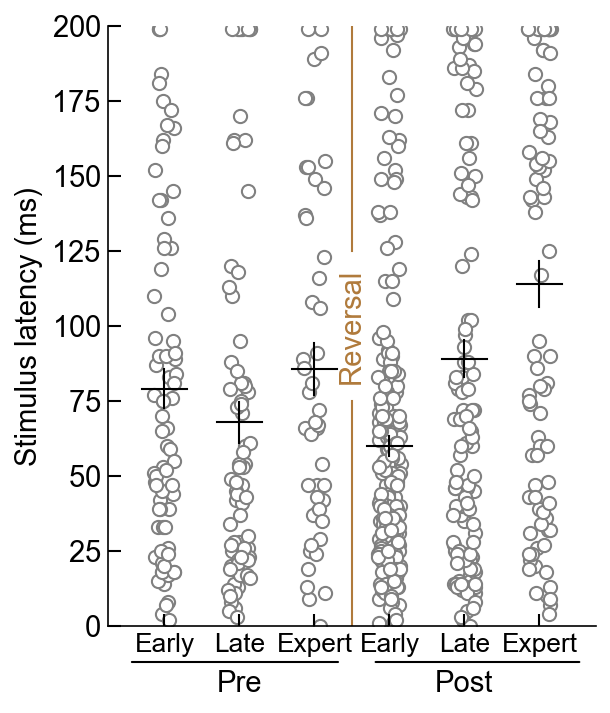

In [28]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
width = 0.3
################################################################################################################

#Plot figure 
data = [AC_peaklatency_pre_early,AC_peaklatency_pre_late,AC_peaklatency_pre_expert,AC_peaklatency_post_early,AC_peaklatency_post_late,AC_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,200])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [47]:
ACData = SimpleNamespace()
ACData.preearly = AC_peaklatency_pre_early
ACData.prelate = AC_peaklatency_pre_late
ACData.preexpert = AC_peaklatency_pre_expert
ACData.postearly = AC_peaklatency_post_early
ACData.postlate = AC_peaklatency_post_late
ACData.postexpert = AC_peaklatency_post_expert
ilep.nonparametricIndependentStatsCompareToPrevious(ACData)

            Source            SS     DF            MS          F  \
0            phase  1.181164e+05    3.0  39372.121775  10.428283   
1          context  7.097080e+04    1.0  70970.804784  18.797656   
2  phase * context  4.403079e+04    3.0  14676.930886   3.887400   
3         Residual  3.129901e+06  829.0   3775.513475        NaN   

          p-unc       np2  
0  9.701229e-07  0.036366  
1  1.632187e-05  0.022172  
2  8.936787e-03  0.013873  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.014783  0.029565 -0.351175
8     post-late  baseline  experimental  0.003196  0.012783 -0.503591
9    pre-expert  baseline  experimental  0.062403  0.083204 -0.300759
10     pre-late  baseline  experimental  0.125381  0.125381  0.194179
key preearly has 75 non-nan elements
key prelate has 73 non-nan elements
key preexpert has 47 non-nan elements
key postearly has 227 non-nan elements
key postlate has 1

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  46033.5   two-sided  0.000027  0.000161   fdr_bh  0.448974  
1        False  15153.5   two-sided  0.007947  0.015894   fdr_bh  0.362027  
2        False  18820.5   two-sided  0.003024  0.009071   fdr_bh  0.387545  
3        False  20213.0   two-sided  0.428471  0.555774   fdr_bh -0.073823  
4        False  25108.5   two-sided  0.463145  0.555774   fdr_bh -0.052722  
5        False   8938.5   two-sided  0.926742  0.926742   fdr_bh  0.021773  
6        False  72110.5   two-sided  0.000473       NaN      NaN -0.305106  
7        False   4497.0   two-sided  0.014783  0.029565   fdr_bh -0.351175  
8        False  11692.0   two-sided  0.003196  0.012783   fdr_bh -0.503591  
9        False   1368.5   two-sided  0.062403  0.083204   fdr_bh -0.300759  
10       False   3137.5   two-sided  0.125381  0.125381   fdr_bh  0.194179

In [48]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(ACData)

            Source            SS     DF             MS          F  \
0            phase  1.583481e+04    3.0    5278.271446   1.622736   
1          context  1.471377e+05    1.0  147137.714994  45.235571   
2  phase * context  1.127823e+05    3.0   37594.089658  11.557813   
3         Residual  3.028263e+06  931.0    3252.699377        NaN   

          p-unc       np2  
0  1.824853e-01  0.005202  
1  3.045651e-11  0.046337  
2  1.922763e-07  0.035906  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  9.243230e-09  3.697292e-08 -0.962321
8     post-late  baseline  experimental  3.195858e-03  6.391717e-03 -0.503591
9    pre-expert  baseline  experimental  5.591961e-01  5.591961e-01 -0.114332
10     pre-late  baseline  experimental  1.253808e-01  1.671744e-01  0.194179
key preearly has 75 non-nan elements
key prelate has 73 non-nan elements
key preexpert has 47 non-nan elements
key postearl

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative         p-unc        p-corr p-adjust  \
0        False  58288.5   two-sided  3.098828e-01  4.648242e-01   fdr_bh   
1        False  17462.5   two-sided  1.389660e-01  3.579824e-01   fdr_bh   
2        False  23438.0   two-sided  9.243212e-01  9.243212e-01   fdr_bh   
3        False  18597.5   two-sided  2.219355e-02  1.331613e-01   fdr_bh   
4        False  25108.5   two-sided  4.631452e-01  5.557743e-01   fdr_bh   
5        False   9886.5   two-sided  1.789912e-01  3.579824e-01   fdr_bh   
6        False  82460.0   two-sided  2.594263e-06           NaN      NaN   
7        False   5823.0   two-sided  9.243230e-09  3.697292e-08   fdr_bh   
8        False  11692.0   two-sided  3.195858e-03  6.391717e-03   fdr_bh   
9        False   1651.0   two-sided  5.591961e-01  5.591961e-01   fdr_bh   
10       False   3137.5   two-sided  1.253808e-01  1.671744e-01   fdr_bh   

      hedges  
0   0.077352  
1  -0.109025  
2   0.025732  
3  -0.190405  
4  -0.052722  
5   0.140454  
6  -0.443908  
7  -0.962321  
8  -0.503591  
9  -0.114332  
10  0.194179

In [44]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

### M2 analysis (300ms)

In [33]:
import pandas as pd
M2_peaklatency_pickle300 = pd.read_pickle(r'C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\M2\\M2_peaklatency300.pickle')

In [34]:
M2_peaklatency_pre_early = np.array(M2_peaklatency_pickle300.prereversal_early)
M2_peaklatency_pre_late = np.array(M2_peaklatency_pickle300.prereversal_late)
M2_peaklatency_pre_expert = np.array(M2_peaklatency_pickle300.prereversal_expert)

M2_peaklatency_post_early = np.array(M2_peaklatency_pickle300.postreversal_early)
M2_peaklatency_post_late = np.array(M2_peaklatency_pickle300.postreversal_late)
M2_peaklatency_post_expert = np.array(M2_peaklatency_pickle300.postreversal_expert)

In [36]:
M2_peaklatency_onset_preearly = M2_peaklatency_pre_early[M2_peaklatency_pre_early<=100]
M2_peaklatency_onset_prelate = M2_peaklatency_pre_late[M2_peaklatency_pre_late<=100]
M2_peaklatency_onset_preexpert = M2_peaklatency_pre_expert[M2_peaklatency_pre_expert<=100]
M2_peaklatency_onset_postearly = M2_peaklatency_post_early[M2_peaklatency_post_early<=100]
M2_peaklatency_onset_postlate = M2_peaklatency_post_late[M2_peaklatency_post_late<=100]
M2_peaklatency_onset_postexpert = M2_peaklatency_post_expert[M2_peaklatency_post_expert<=100]

In [37]:
M2_preearly_per_onset = len(M2_peaklatency_onset_preearly)/len(M2_peaklatency_pre_early)*100
M2_prelate_per_onset = len(M2_peaklatency_onset_prelate)/len(M2_peaklatency_pre_late)*100
M2_preexpert_per_onset = len(M2_peaklatency_onset_preexpert)/len(M2_peaklatency_pre_expert)*100
M2_postearly_per_onset = len(M2_peaklatency_onset_postearly)/len(M2_peaklatency_post_early)*100
M2_postlate_per_onset = len(M2_peaklatency_onset_postlate)/len(M2_peaklatency_post_late)*100
M2_postexpert_per_onset = len(M2_peaklatency_onset_postexpert)/len(M2_peaklatency_post_expert)*100

In [38]:
M2_peaklatency_offset_preearly = M2_peaklatency_pre_early[M2_peaklatency_pre_early>100]
M2_peaklatency_offset_prelate = M2_peaklatency_pre_late[M2_peaklatency_pre_late>100]
M2_peaklatency_offset_preexpert = M2_peaklatency_pre_expert[M2_peaklatency_pre_expert>100]
M2_peaklatency_offset_postearly = M2_peaklatency_post_early[M2_peaklatency_post_early>100]
M2_peaklatency_offset_postlate = M2_peaklatency_post_late[M2_peaklatency_post_late>100]
M2_peaklatency_offset_postexpert = M2_peaklatency_post_expert[M2_peaklatency_post_expert>100]

In [39]:
print(np.max(M2_peaklatency_pre_early))
print(np.max(M2_peaklatency_pre_late))
print(np.max(M2_peaklatency_pre_expert))
print(np.max(M2_peaklatency_post_early))
print(np.max(M2_peaklatency_post_late))
print(np.max(M2_peaklatency_post_expert))

299
299
299
299
299
299


In [40]:
M2_peaklatency_preearly = np.concatenate((M2_peaklatency_offset_preearly-100,M2_peaklatency_onset_preearly))
M2_peaklatency_prelate = np.concatenate((M2_peaklatency_offset_prelate-100,M2_peaklatency_onset_prelate))
M2_peaklatency_preexpert = np.concatenate((M2_peaklatency_offset_preexpert-100,M2_peaklatency_onset_preexpert))
M2_peaklatency_postearly = np.concatenate((M2_peaklatency_offset_postearly-100,M2_peaklatency_onset_postearly))
M2_peaklatency_postlate = np.concatenate((M2_peaklatency_offset_postlate-100,M2_peaklatency_onset_postlate))
M2_peaklatency_postexpert = np.concatenate((M2_peaklatency_offset_postexpert-100,M2_peaklatency_onset_postexpert))

meta NOT subset; don't know how to subset; dropped


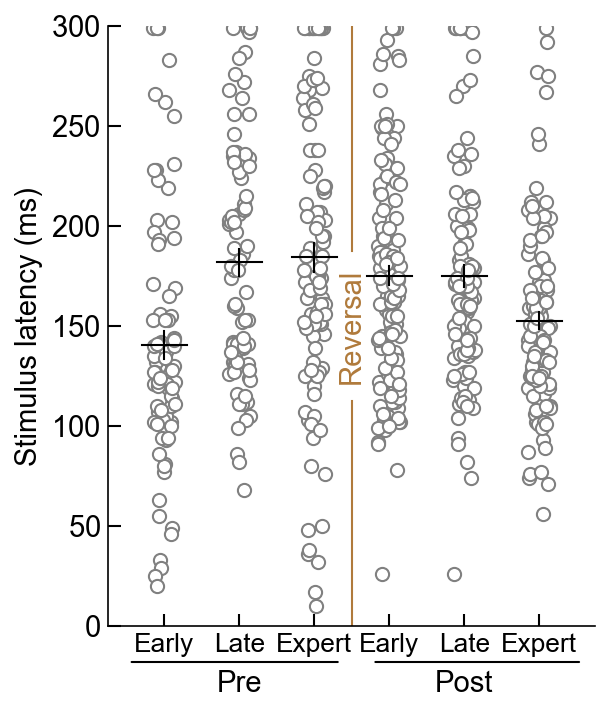

In [41]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_pre_early,M2_peaklatency_pre_late,M2_peaklatency_pre_expert,M2_peaklatency_post_early,M2_peaklatency_post_late,M2_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,300])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\M2 stimulus latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [49]:
M2Data = SimpleNamespace()
M2Data.preearly = M2_peaklatency_pre_early
M2Data.prelate = M2_peaklatency_pre_late
M2Data.preexpert = M2_peaklatency_pre_expert
M2Data.postearly = M2_peaklatency_post_early
M2Data.postlate = M2_peaklatency_post_late
M2Data.postexpert = M2_peaklatency_post_expert
ilep.nonparametricIndependentStatsCompareToPrevious(M2Data)

            Source            SS     DF            MS         F     p-unc  \
0            phase  5.826238e+04    3.0  19420.794707  5.605536  0.000834   
1          context  1.446708e+03    1.0   1446.707774  0.417572  0.518339   
2  phase * context  9.427592e+04    3.0  31425.307714  9.070468  0.000007   
3         Residual  2.740478e+06  791.0   3464.574127       NaN       NaN   

        np2  
0  0.020817  
1  0.000528  
2  0.033257  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.001399  0.002798  0.429719
8     post-late  baseline  experimental  0.802535  0.802535  0.005769
9    pre-expert  baseline  experimental  0.524466  0.699288 -0.035512
10     pre-late  baseline  experimental  0.000021  0.000083 -0.659472
key preearly has 80 non-nan elements
key prelate has 81 non-nan elements
key preexpert has 100 non-nan elements
key postearly has 132 non-nan elements
key postlate has 106 non-nan elements
key 

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  22513.0   two-sided  0.011891  0.017836   fdr_bh -0.215520  
1        False  16031.0   two-sided  0.000996  0.002987   fdr_bh -0.329591  
2        False  18630.0   two-sided  0.344559  0.344559   fdr_bh  0.034712  
3        False  19868.5   two-sided  0.173752  0.208502   fdr_bh -0.133907  
4        False  22190.5   two-sided  0.007316  0.014633   fdr_bh  0.229326  
5        False  17629.5   two-sided  0.000803  0.002987   fdr_bh  0.326459  
6        False  77618.0   two-sided  0.503595       NaN      NaN -0.047156  
7        False   7486.5   two-sided  0.001399  0.002798   fdr_bh  0.429719  
8        False   7128.5   two-sided  0.802535  0.802535   fdr_bh  0.005769  
9        False   3826.5   two-sided  0.524466  0.699288   fdr_bh -0.035512  
10       False   1980.5   two-sided  0.000021  0.000083   fdr_bh -0.659472

In [50]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(M2Data)

            Source            SS     DF            MS          F  \
0            phase  2.485588e+04    3.0   8285.291753   2.399965   
1          context  2.393583e+04    1.0  23935.826634   6.933388   
2  phase * context  1.602404e+05    3.0  53413.476044  15.472052   
3         Residual  2.817040e+06  816.0   3452.255512        NaN   

          p-unc       np2  
0  6.659218e-02  0.008746  
1  8.620193e-03  0.008425  
2  8.507593e-10  0.053821  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000525  0.000700  0.442556
8     post-late  baseline  experimental  0.802535  0.802535  0.005769
9    pre-expert  baseline  experimental  0.000006  0.000023 -0.627127
10     pre-late  baseline  experimental  0.000021  0.000041 -0.659472
key preearly has 80 non-nan elements
key prelate has 81 non-nan elements
key preexpert has 100 non-nan elements
key postearly has 132 non-nan elements
key postlate has 

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  25872.0   two-sided  0.032310  0.096931   fdr_bh -0.191297  
1        False  22426.0   two-sided  0.764077  0.764077   fdr_bh -0.001547  
2        False  21019.5   two-sided  0.262305  0.393457   fdr_bh  0.059203  
3        False  23714.0   two-sided  0.060725  0.121450   fdr_bh  0.160386  
4        False  22190.5   two-sided  0.007316  0.043898   fdr_bh  0.229326  
5        False  15030.0   two-sided  0.552685  0.663222   fdr_bh  0.050610  
6        False  76571.0   two-sided  0.015956       NaN      NaN -0.169115  
7        False   9376.0   two-sided  0.000525  0.000700   fdr_bh  0.442556  
8        False   7128.5   two-sided  0.802535  0.802535   fdr_bh  0.005769  
9        False   2424.0   two-sided  0.000006  0.000023   fdr_bh -0.627127  
10       False   1980.5   two-sided  0.000021  0.000041   fdr_bh -0.659472

In [43]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

### latency fig

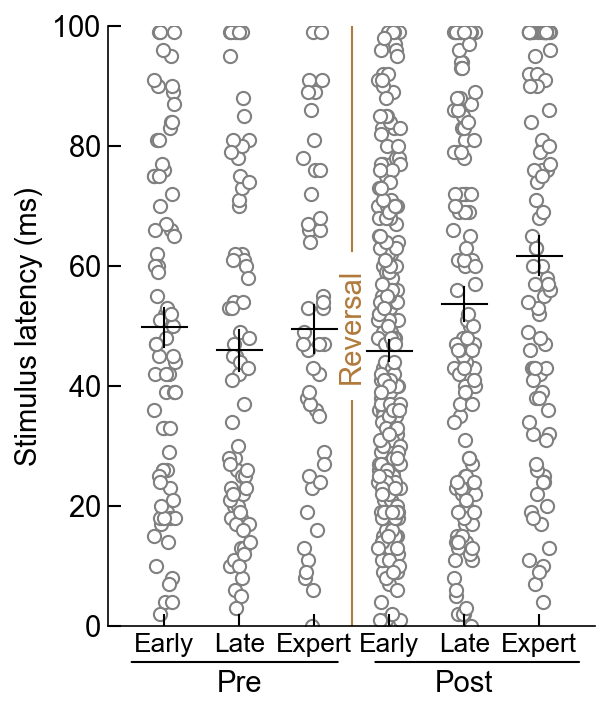

In [61]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
width = 0.3
################################################################################################################

#Plot figure
data = [AC_peaklatency_preearly,AC_peaklatency_prelate,AC_peaklatency_preexpert,AC_peaklatency_postearly,AC_peaklatency_postlate,AC_peaklatency_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

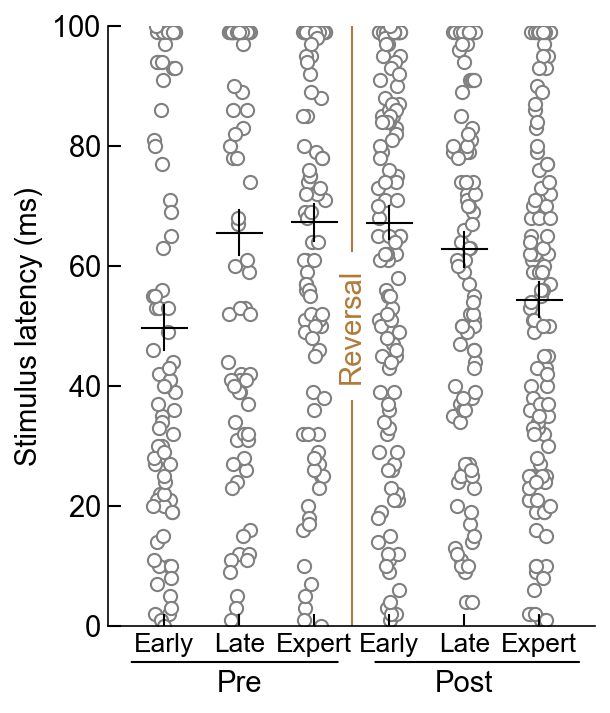

In [62]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_preearly,M2_peaklatency_prelate,M2_peaklatency_preexpert,M2_peaklatency_postearly,M2_peaklatency_postlate,M2_peaklatency_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\M2 stimulus latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

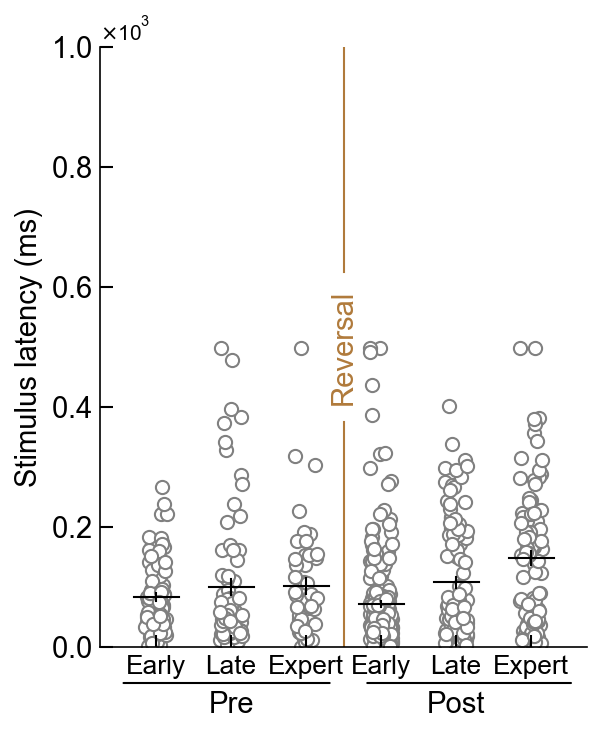

In [62]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [AC_peaklatency_pre_early,AC_peaklatency_pre_late,AC_peaklatency_pre_expert,AC_peaklatency_post_early,AC_peaklatency_post_late,AC_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1000])
#ax.set_yticks([40,50,60.100])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

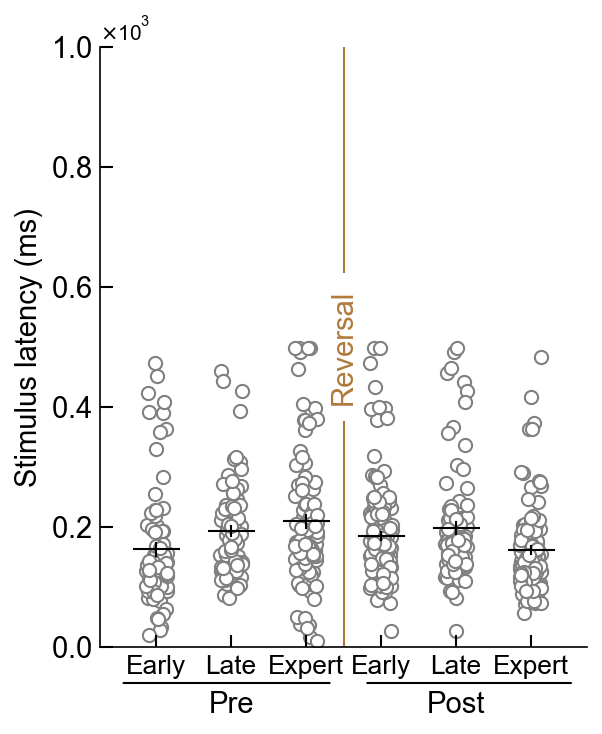

In [63]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_pre_early,M2_peaklatency_pre_late,M2_peaklatency_pre_expert,M2_peaklatency_post_early,M2_peaklatency_post_late,M2_peaklatency_post_expert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1000])
#ax.set_yticks([40,50,60.100])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [63]:
M2Data = SimpleNamespace()
M2Data.preearly = M2_peaklatency_preearly
M2Data.prelate = M2_peaklatency_prelate
M2Data.preexpert = M2_peaklatency_preexpert
M2Data.postearly = M2_peaklatency_postearly
M2Data.postlate = M2_peaklatency_postlate
M2Data.postexpert = M2_peaklatency_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(M2Data)

            Source             SS     DF           MS         F     p-unc  \
0            phase   11934.816387    3.0  3978.272129  3.965330  0.008045   
1          context       0.010890    1.0     0.010890  0.000011  0.997372   
2  phase * context   15205.359265    3.0  5068.453088  5.051965  0.001798   
3         Residual  793581.629367  791.0  1003.263754       NaN       NaN   

            np2  
0  1.481635e-02  
1  1.372199e-08  
2  1.880020e-02  
3           NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.039000  0.078000  0.274782
8     post-late  baseline  experimental  0.192761  0.257015  0.142132
9    pre-expert  baseline  experimental  0.984897  0.984897 -0.055505
10     pre-late  baseline  experimental  0.002517  0.010067 -0.467409
key preearly has 80 non-nan elements
key prelate has 81 non-nan elements
key preexpert has 100 non-nan elements
key postearly has 132 non-nan elements
key postlate has 106 n

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  22594.0   two-sided  0.013494  0.038326   fdr_bh -0.219397  
1        False  16567.5   two-sided  0.004396  0.026374   fdr_bh -0.256058  
2        False  17672.0   two-sided  0.968174  0.968174   fdr_bh  0.025465  
3        False  20624.5   two-sided  0.451000  0.541200   fdr_bh -0.039569  
4        False  21276.5   two-sided  0.058815  0.088223   fdr_bh  0.233515  
5        False  16677.5   two-sided  0.019163  0.038326   fdr_bh  0.265574  
6        False  80203.0   two-sided  0.900968       NaN      NaN  0.002427  
7        False   6954.0   two-sided  0.039000  0.078000   fdr_bh  0.274782  
8        False   7678.5   two-sided  0.192761  0.257015   fdr_bh  0.142132  
9        False   4043.0   two-sided  0.984897  0.984897   fdr_bh -0.055505  
10       False   2354.5   two-sided  0.002517  0.010067   fdr_bh -0.467409

In [64]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [65]:
ACData = SimpleNamespace()
ACData.preearly = AC_peaklatency_preearly
ACData.prelate = AC_peaklatency_prelate
ACData.preexpert = AC_peaklatency_preexpert
ACData.postearly = AC_peaklatency_postearly
ACData.postlate = AC_peaklatency_postlate
ACData.postexpert = AC_peaklatency_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(ACData)

            Source             SS     DF           MS         F     p-unc  \
0            phase   12389.560901    3.0  4129.853634  4.801368  0.002537   
1          context    5146.623795    1.0  5146.623795  5.983465  0.014647   
2  phase * context    4062.998724    3.0  1354.332908  1.574547  0.194054   
3         Residual  713056.978509  829.0   860.141108       NaN       NaN   

        np2  
0  0.017079  
1  0.007166  
2  0.005666  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.063162  0.126324 -0.256815
8     post-late  baseline  experimental  0.037954  0.126324 -0.272358
9    pre-expert  baseline  experimental  0.430760  0.430760 -0.123315
10     pre-late  baseline  experimental  0.378601  0.430760  0.132568
key preearly has 75 non-nan elements
key prelate has 73 non-nan elements
key preexpert has 47 non-nan elements
key postearly has 227 non-nan elements
key postlate has 127 non-nan elements
key p

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  43915.0   two-sided  0.002041  0.012244   fdr_bh  0.277964  
1        False  15193.0   two-sided  0.006910  0.013819   fdr_bh  0.315235  
2        False  18594.5   two-sided  0.006232  0.013819   fdr_bh  0.298397  
3        False  21856.5   two-sided  0.634657  0.876798   fdr_bh  0.047617  
4        False  26706.5   two-sided  0.730665  0.876798   fdr_bh  0.028495  
5        False   8798.5   two-sided  0.897823  0.897823   fdr_bh -0.019007  
6        False  76238.5   two-sided  0.021974       NaN      NaN -0.171314  
7        False   4756.5   two-sided  0.063162  0.126324   fdr_bh -0.256815  
8        False  12498.0   two-sided  0.037954  0.126324   fdr_bh -0.272358  
9        False   1568.5   two-sided  0.430760  0.430760   fdr_bh -0.123315  
10       False   2967.5   two-sided  0.378601  0.430760   fdr_bh  0.132568

### Offset latency fig

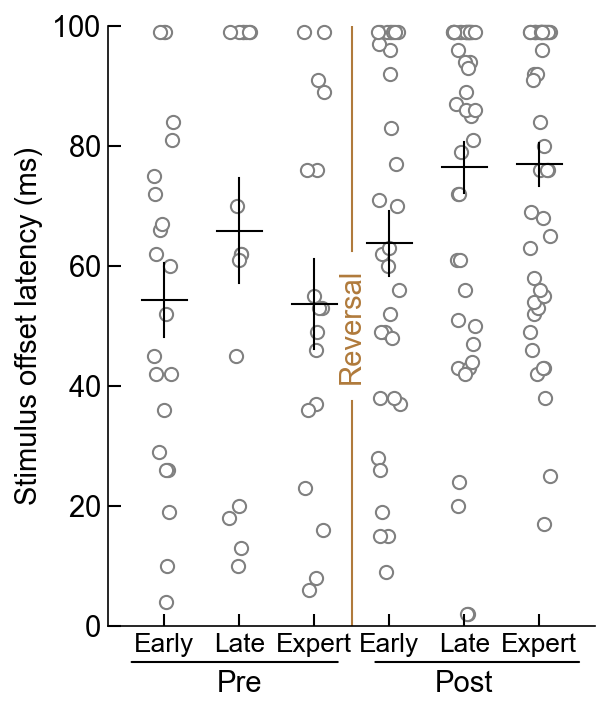

In [67]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [AC_peaklatency_offset_preearly-100,AC_peaklatency_offset_prelate-100,AC_peaklatency_offset_preexpert-100,AC_peaklatency_offset_postearly-100,AC_peaklatency_offset_postlate-100,AC_peaklatency_offset_postexpert-100]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white', clip_on = False)
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus offset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus offset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

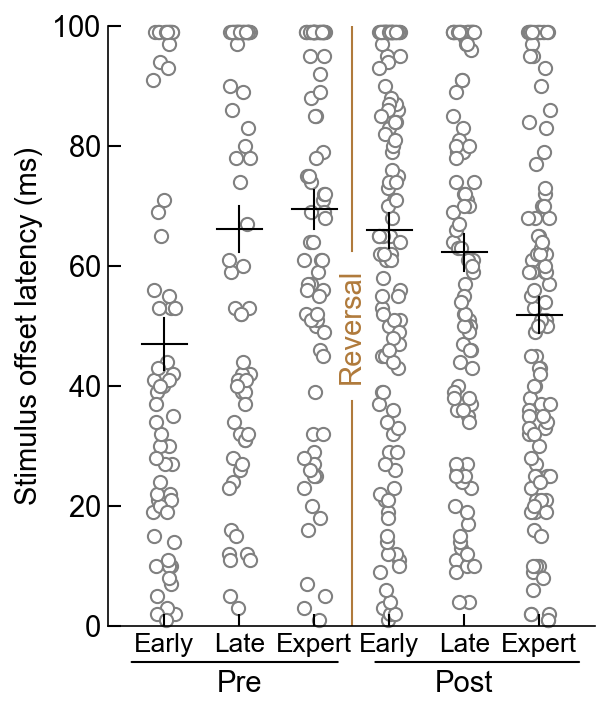

In [70]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_offset_preearly-100,M2_peaklatency_offset_prelate-100,M2_peaklatency_offset_preexpert-100,M2_peaklatency_offset_postearly-100,M2_peaklatency_offset_postlate-100,M2_peaklatency_offset_postexpert-100]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white', clip_on = False)
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Stimulus offset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\M2 stimulus offset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [71]:
ACData = SimpleNamespace()
ACData.preearly = AC_peaklatency_offset_preearly-100
ACData.prelate = AC_peaklatency_offset_prelate-100
ACData.preexpert = AC_peaklatency_offset_preexpert-100
ACData.postearly = AC_peaklatency_offset_postearly-100
ACData.postlate = AC_peaklatency_offset_postlate-100
ACData.postexpert = AC_peaklatency_offset_postexpert-100
ilep.nonparametricIndependentStatsCompareToPrevious(ACData)

            Source             SS     DF           MS         F     p-unc  \
0            phase   11902.865409    3.0  3967.621803  4.661394  0.003493   
1          context    1094.058361    1.0  1094.058361  1.285364  0.258079   
2  phase * context    4385.659381    3.0  1461.886460  1.717510  0.164135   
3         Residual  196619.432013  231.0   851.166372       NaN       NaN   

        np2  
0  0.057082  
1  0.005534  
2  0.021819  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.967217  0.967217 -0.017498
8     post-late  baseline  experimental  0.064305  0.257220 -0.427771
9    pre-expert  baseline  experimental  0.196313  0.359208  0.362136
10     pre-late  baseline  experimental  0.269406  0.359208 -0.358128
key preearly has 22 non-nan elements
key prelate has 16 non-nan elements
key preexpert has 17 non-nan elements
key postearly has 32 non-nan elements
key postlate has 45 non-nan elements
key pos

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric   U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  3863.0   two-sided  0.240276  0.288332   fdr_bh  0.195766  
1        False  1931.5   two-sided  0.012665  0.037994   fdr_bh  0.603278  
2        False  2252.0   two-sided  0.005649  0.033895   fdr_bh  0.622429  
3        False  1509.0   two-sided  0.114542  0.171812   fdr_bh  0.375504  
4        False  1754.5   two-sided  0.078818  0.157636   fdr_bh  0.392759  
5        False   628.0   two-sided  0.995355  0.995355   fdr_bh  0.011985  
6        False  6485.0   two-sided  0.217930       NaN      NaN -0.163558  
7        False  1040.5   two-sided  0.967217  0.967217   fdr_bh -0.017498  
8        False   544.0   two-sided  0.064305  0.257220   fdr_bh -0.427771  
9        False   172.0   two-sided  0.196313  0.359208   fdr_bh  0.362136  
10       False   138.5   two-sided  0.269406  0.359208   fdr_bh -0.358128

In [72]:
M2Data = SimpleNamespace()
M2Data.preearly = M2_peaklatency_offset_preearly-100
M2Data.prelate = M2_peaklatency_offset_prelate-100
M2Data.preexpert = M2_peaklatency_offset_preexpert-100
M2Data.postearly = M2_peaklatency_offset_postearly-100
M2Data.postlate = M2_peaklatency_offset_postlate-100
M2Data.postexpert = M2_peaklatency_offset_postexpert-100
ilep.nonparametricIndependentStatsCompareToPrevious(M2Data)

            Source             SS     DF           MS         F     p-unc  \
0            phase   14511.431486    3.0  4837.143829  4.840014  0.002425   
1          context      14.331835    1.0    14.331835  0.014340  0.904714   
2  phase * context   19069.597174    3.0  6356.532391  6.360305  0.000294   
3         Residual  716574.750039  717.0   999.406904       NaN       NaN   

        np2  
0  0.019849  
1  0.000020  
2  0.025922  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.015501  0.031002  0.338205
8     post-late  baseline  experimental  0.299612  0.399483  0.116535
9    pre-expert  baseline  experimental  0.669032  0.669032 -0.103616
10     pre-late  baseline  experimental  0.001013  0.004051 -0.564886
key preearly has 62 non-nan elements
key prelate has 75 non-nan elements
key preexpert has 85 non-nan elements
key postearly has 123 non-nan elements
key postlate has 101 non-nan elements
key p

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  19700.0   two-sided  0.013243  0.026486   fdr_bh -0.232562  
1        False  12879.0   two-sided  0.000486  0.002916   fdr_bh -0.347261  
2        False  13789.5   two-sided  0.835602  0.835602   fdr_bh -0.013564  
3        False  16379.5   two-sided  0.144670  0.173604   fdr_bh -0.115336  
4        False  16820.5   two-sided  0.120859  0.173604   fdr_bh  0.207457  
5        False  12828.0   two-sided  0.009714  0.026486   fdr_bh  0.313067  
6        False  65626.0   two-sided  0.978409       NaN      NaN -0.003656  
7        False   6219.0   two-sided  0.015501  0.031002   fdr_bh  0.338205  
8        False   6708.0   two-sided  0.299612  0.399483   fdr_bh  0.116535  
9        False   3065.5   two-sided  0.669032  0.669032   fdr_bh -0.103616  
10       False   1575.5   two-sided  0.001013  0.004051   fdr_bh -0.564886

In [100]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

### Onset latency fig

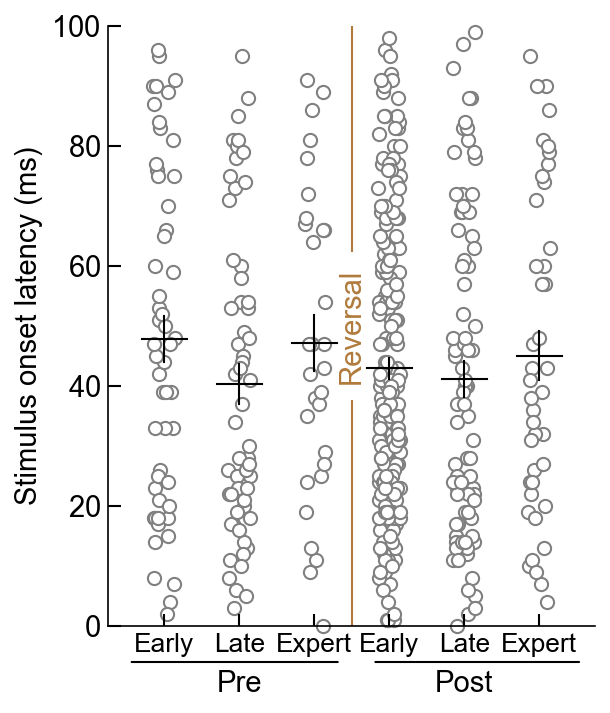

In [75]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [AC_peaklatency_onset_preearly,AC_peaklatency_onset_prelate,AC_peaklatency_onset_preexpert,AC_peaklatency_onset_postearly,AC_peaklatency_onset_postlate,AC_peaklatency_onset_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white',clip_on = False)
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([40,50,60.100])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus onset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

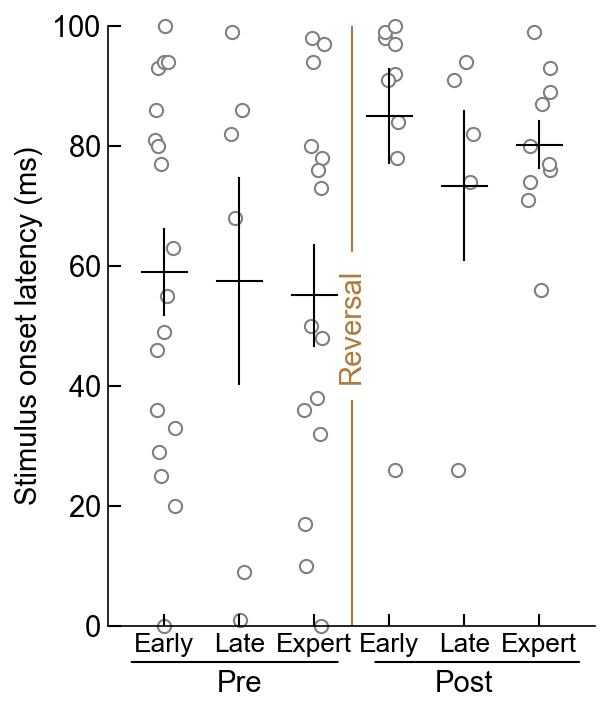

In [76]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
################################################################################################################

#Plot figure
data = [M2_peaklatency_onset_preearly,M2_peaklatency_onset_prelate,M2_peaklatency_onset_preexpert,M2_peaklatency_onset_postearly,M2_peaklatency_onset_postlate,M2_peaklatency_onset_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white',clip_on = False)
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
#ax.set_yticks([40,50,60.100])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus onset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\M2 stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


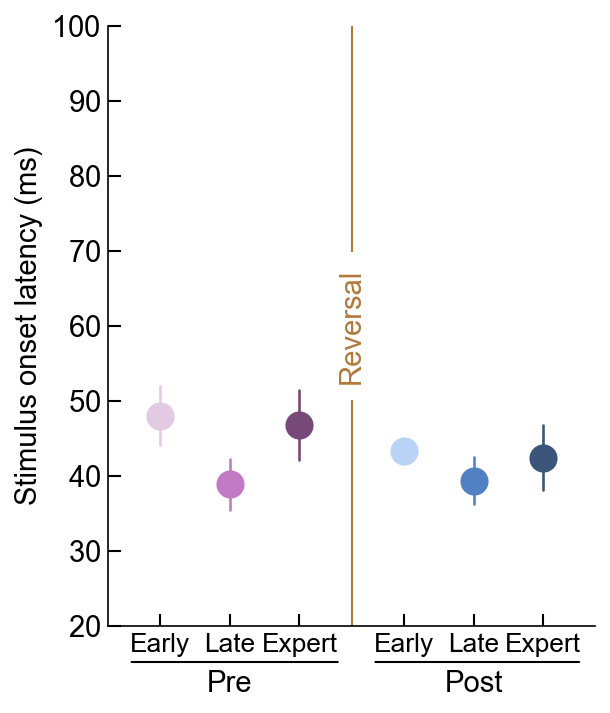

In [147]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [AC_peaklatency_onset_preearly,AC_peaklatency_onset_prelate,AC_peaklatency_onset_preexpert,AC_peaklatency_onset_postearly,AC_peaklatency_onset_postlate,AC_peaklatency_onset_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#numCon = len(data)
#X = [np.ones(len(l))*idx for idx,l in enumerate(data)]
#X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
# numunits = [len(d) for d in data]
# cumsumunits = np.cumsum(numunits)
# unitsperphase= np.concatenate([[0],cumsumunits])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([20,100])
#ax.set_yticks([40,50,60.100])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus onset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\AC stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


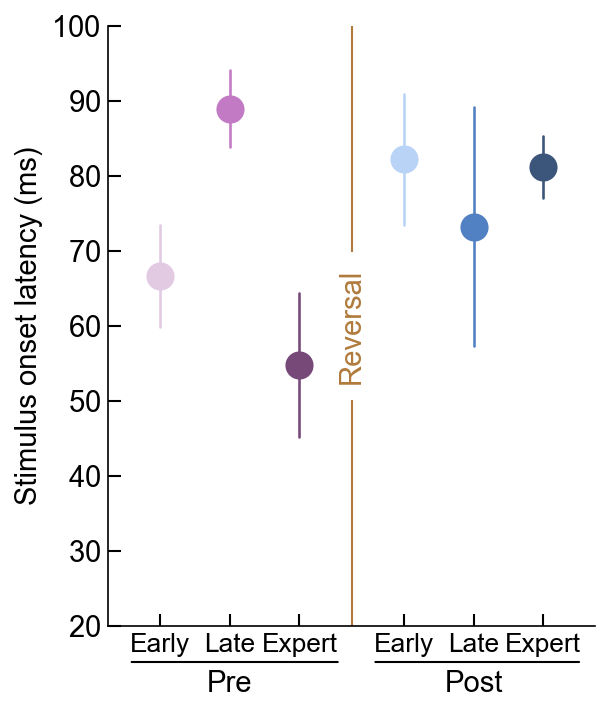

In [148]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

#data = [M2_peaklatency_pre_early,M2_peaklatency_pre_late,M2_peaklatency_pre_expert,M2_peaklatency_post_early,M2_peaklatency_post_late,M2_peaklatency_post_expert]
data = [M2_peaklatency_onset_preearly,M2_peaklatency_onset_prelate,M2_peaklatency_onset_preexpert,M2_peaklatency_onset_postearly,M2_peaklatency_onset_postlate,M2_peaklatency_onset_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#numCon = len(data)
#X = [np.ones(len(l))*idx for idx,l in enumerate(data)]
#X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
# numunits = [len(d) for d in data]
# cumsumunits = np.cumsum(numunits)
# unitsperphase= np.concatenate([[0],cumsumunits])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([20,100])
#ax.set_yticks([0,40,80,120])
#ax.set_yticklabels(['0','40','80','120'])
ylab = ax.set_ylabel('Stimulus onset latency (ms)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\M2 stimulus onset latency.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [77]:
ACData = SimpleNamespace()
ACData.preearly = AC_peaklatency_onset_preearly
ACData.prelate = AC_peaklatency_onset_prelate
ACData.preexpert = AC_peaklatency_onset_preexpert
ACData.postearly = AC_peaklatency_onset_postearly
ACData.postlate = AC_peaklatency_onset_postlate
ACData.postexpert = AC_peaklatency_onset_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(ACData)

            Source             SS     DF           MS         F     p-unc  \
0            phase     224.035392    3.0    74.678464  0.112371  0.952867   
1          context      36.310674    1.0    36.310674  0.054638  0.815262   
2  phase * context    3066.408730    3.0  1022.136243  1.538036  0.203538   
3         Residual  392097.680007  590.0   664.572339       NaN       NaN   

        np2  
0  0.000571  
1  0.000093  
2  0.007760  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.413076  0.413076 -0.145633
8     post-late  baseline  experimental  0.385147  0.413076  0.072785
9    pre-expert  baseline  experimental  0.217745  0.413076 -0.264528
10     pre-late  baseline  experimental  0.161500  0.413076  0.281526
key preearly has 53 non-nan elements
key prelate has 57 non-nan elements
key preexpert has 30 non-nan elements
key postearly has 195 non-nan elements
key postlate has 82 non-nan elements
key po

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric    U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False  16963.5   two-sided  0.844770  0.959008   fdr_bh  0.001912  
1        False   5305.0   two-sided  0.839332  0.959008   fdr_bh -0.007528  
2        False   6558.5   two-sided  0.613516  0.959008   fdr_bh -0.055284  
3        False  12005.0   two-sided  0.959008  0.959008   fdr_bh -0.009847  
4        False  14884.0   two-sided  0.723968  0.959008   fdr_bh -0.060113  
5        False   4680.5   two-sided  0.793506  0.959008   fdr_bh -0.048834  
6        False  41360.5   two-sided  0.792329       NaN      NaN  0.011847  
7        False   1566.5   two-sided  0.413076  0.413076   fdr_bh -0.145633  
8        False   8524.0   two-sided  0.385147  0.413076   fdr_bh  0.072785  
9        False    716.5   two-sided  0.217745  0.413076   fdr_bh -0.264528  
10       False   1745.0   two-sided  0.161500  0.413076   fdr_bh  0.281526

In [78]:
M2Data = SimpleNamespace()
M2Data.preearly = M2_peaklatency_onset_preearly
M2Data.prelate = M2_peaklatency_onset_prelate
M2Data.preexpert = M2_peaklatency_onset_preexpert
M2Data.postearly = M2_peaklatency_onset_postearly
M2Data.postlate = M2_peaklatency_onset_postlate
M2Data.postexpert = M2_peaklatency_onset_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(M2Data)

            Source            SS    DF           MS         F     p-unc  \
0            phase   8733.306357   3.0  2911.102119  3.199776  0.028908   
1          context     63.737393   1.0    63.737393  0.070058  0.792077   
2  phase * context    556.303877   3.0   185.434626  0.203823  0.893397   
3         Residual  60045.677778  66.0   909.782997       NaN       NaN   

        np2  
0  0.126976  
1  0.001060  
2  0.009180  
3       NaN  

          phase         A             B     p-unc   p-corr    hedges
7   post-expert  baseline  experimental  1.000000  1.00000 -0.346587
8     post-late  baseline  experimental  0.181460  0.72584  0.437155
9    pre-expert  baseline  experimental  0.790985  1.00000  0.064480
10     pre-late  baseline  experimental  0.946824  1.00000  0.041691
key preearly has 18 non-nan elements
key prelate has 6 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 9 non-nan elements
key postlate has 5 non-nan elements
key postexpert has 10 non

Contrast        phase            A             B Paired  \
0             phase            -  post-expert     post-late  False   
1             phase            -  post-expert    pre-expert  False   
2             phase            -  post-expert      pre-late  False   
3             phase            -    post-late    pre-expert  False   
4             phase            -    post-late      pre-late  False   
5             phase            -   pre-expert      pre-late  False   
6           context            -     baseline  experimental  False   
7   phase * context  post-expert     baseline  experimental  False   
8   phase * context    post-late     baseline  experimental  False   
9   phase * context   pre-expert     baseline  experimental  False   
10  phase * context     pre-late     baseline  experimental  False   

    Parametric  U-val alternative     p-unc    p-corr p-adjust    hedges  
0        False   74.5   two-sided  0.189610  0.227532   fdr_bh -0.132476  
1        False  211.5   two-sided  0.085917  0.171835   fdr_bh  0.751127  
2        False  232.5   two-sided  0.133111  0.199666   fdr_bh  0.674568  
3        False  215.0   two-sided  0.022959  0.102156   fdr_bh  0.792766  
4        False  238.5   two-sided  0.034052  0.102156   fdr_bh  0.726150  
5        False  240.0   two-sided  0.793497  0.793497   fdr_bh -0.081361  
6        False  742.0   two-sided  0.533823       NaN      NaN  0.056177  
7        False   25.5   two-sided  1.000000  1.000000   fdr_bh -0.346587  
8        False   33.0   two-sided  0.181460  0.725840   fdr_bh  0.437155  
9        False   49.0   two-sided  0.790985  1.000000   fdr_bh  0.064480  
10       False   52.5   two-sided  0.946824  1.000000   fdr_bh  0.041691

### Percentage fig

meta NOT subset; don't know how to subset; dropped


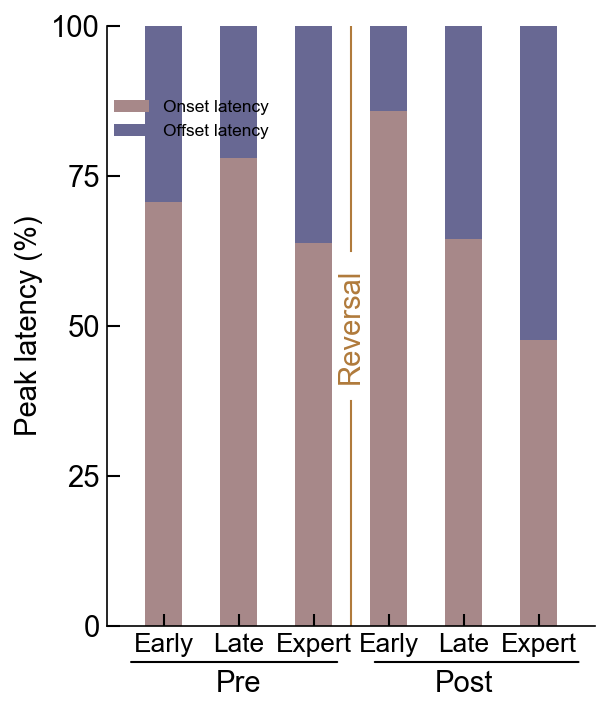

In [27]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0
################################################################################################################

#Plot figure
labels = ['Early','Late','Expert','Early','Late','Expert']

onset = [AC_preearly_per_onset,AC_prelate_per_onset,AC_preexpert_per_onset,AC_postearly_per_onset,AC_postlate_per_onset,AC_postexpert_per_onset]
offset = [100-AC_preearly_per_onset,100-AC_prelate_per_onset,100-AC_preexpert_per_onset,100-AC_postearly_per_onset,100-AC_postlate_per_onset,100-AC_postexpert_per_onset]

ax.bar(range(len(labels)),onset,label = 'Onset latency',width = 0.5, color='#A78889')
ax.bar(range(len(labels)),offset, bottom = onset, label = 'Offset latency',width = 0.5,  color='#686893')
    
################################################################################################################


ax.set_ylim([0,100])
ax.set_yticks([0,25,50,75,100])
ax.set_yticklabels(['0','25','50','75','100'])
ylab = ax.set_ylabel('Peak latency (%)')
ax.legend(frameon=False,loc=(0,0.8))

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\AC stimulus latency percentage.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


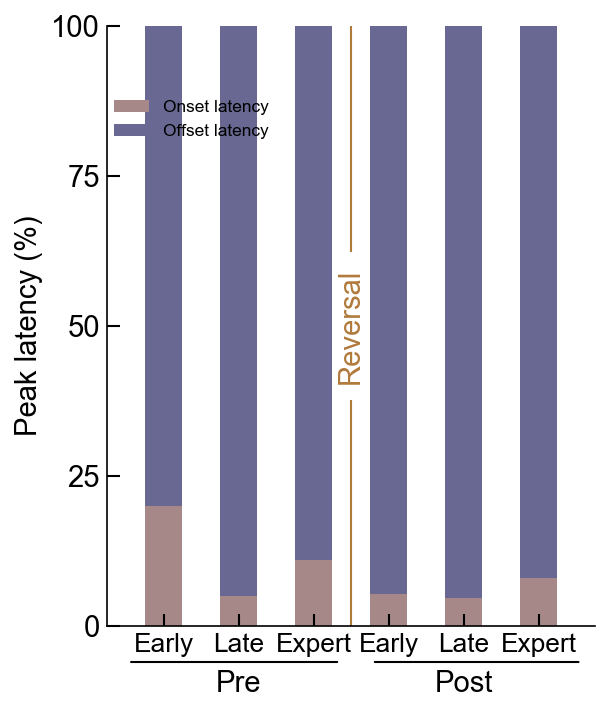

In [45]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0
################################################################################################################

#Plot figure
labels = ['Early','Late','Expert','Early','Late','Expert']

onset = [M2_preearly_per_onset,M2_prelate_per_onset,M2_preexpert_per_onset,M2_postearly_per_onset,M2_postlate_per_onset,M2_postexpert_per_onset]
offset = [100-M2_preearly_per_onset,100-M2_prelate_per_onset,100-M2_preexpert_per_onset,100-M2_postearly_per_onset,100-M2_postlate_per_onset,100-M2_postexpert_per_onset]

ax.bar(range(len(labels)),onset,label = 'Onset latency',width = 0.5, color='#A78889')
ax.bar(range(len(labels)),offset, bottom = onset, label = 'Offset latency',width = 0.5,  color='#686893')
    
################################################################################################################


ax.set_ylim([0,100])
ax.set_yticks([0,25,50,75,100])
ax.set_yticklabels(['0','25','50','75','100'])
ylab = ax.set_ylabel('Peak latency (%)')
ax.legend(frameon=False,loc=(0,0.8))

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\Peak_latency\\Stimulus\\M2 stimulus latency percentage.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')